In [1]:
# example of defining the discriminator model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from keras.utils.vis_utils import plot_model
from keras.layers import Embedding
from keras.layers import Reshape
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Conv2DTranspose
from keras.layers import UpSampling2D
from keras.layers import MaxPool2D
from keras.layers import AveragePooling2D
from matplotlib import pyplot
from keras.constraints import Constraint
import numpy as np
import tensorflow as tf
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from keras import backend
from keras.datasets.cifar10 import load_data


In [58]:
# clip model weights to a given hypercube
class ClipConstraint(Constraint):
    # set clip value when initialized
    def __init__(self, clip_value):
        self.clip_value = clip_value

    # clip model weights to hypercube
    def __call__(self, weights):
        return backend.clip(weights, -self.clip_value, self.clip_value)

    # get the config
    def get_config(self):
        return {'clip_value': self.clip_value}

# calculate wasserstein loss
def wasserstein_loss(y_true, y_pred):
    return backend.mean(y_true * y_pred)

# define the standalone discriminator model
def define_discriminator(in_shape=(64,64,3)):
    # 64
    in_image = Input(shape=in_shape)
    
    # 32
    fe = Conv2D(64, (3,3), strides=(2,2), padding='same')(in_image)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
   
    # 16
    fe = Dropout(0.2)(fe)
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    
    # 8
    fe = Dropout(0.2)(fe)
    fe = Conv2D(256, (3,3), strides=(2,2), padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    
    fe = Conv2D(256, (3,3), padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    
    # 4
    fe = Dropout(0.2)(fe)
    fe = Conv2D(512, (3,3), strides=(2,2), padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    
    fe = Conv2D(512, (3,3), padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    
    # flatten feature maps
    fe = Flatten()(fe)    
    # real/fake output
    #output = Dense(1)(fe)
    fe = Dropout(0.2)(fe)
    out_layer = Dense(1, activation='sigmoid')(fe)
    # define model
    model = Model(in_image, out_layer)
    # compile model
    #opt = RMSprop(learning_rate=0.00005)
    #model.compile(loss=wasserstein_loss, optimizer=opt)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# define the standalone generator model
def define_generator(latent_dim):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # define model
    in_lat = Input(shape=(latent_dim,))
    # 4
    n_nodes = 512 * 4 * 4
    gen = Dense(n_nodes)(in_lat)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((4, 4, 512))(gen)
    
    # 8
    gen = UpSampling2D(size=(2,2))(gen)
    gen = Conv2DTranspose(512, (3,3))(gen)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # 16
    gen = UpSampling2D(size=(2,2))(gen)
    gen = Conv2DTranspose(256, (3,3))(gen)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # 32
    gen = UpSampling2D(size=(2,2))(gen)
    gen = Conv2DTranspose(128, (3,3))(gen)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # 64
    gen = UpSampling2D(size=(2,2))(gen)
    gen = Conv2DTranspose(64, (3,3))(gen)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # 128
    gen = UpSampling2D(size=(2,2))(gen)
    gen = Conv2DTranspose(32, (3,3))(gen)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # 64
    gen = Conv2D(3, (3,3))(gen)
    gen = tf.nn.tanh(gen)
    out_layer = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(gen)
    model = Model(in_lat, out_layer)
    return model


Model: "model_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_119 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_192 (LeakyReLU)  (None, 32, 32, 64)       0         
                                                                 
 dropout_43 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 conv2d_120 (Conv2D)         (None, 16, 16, 128)       73856     
                                                                 
 batch_normalization_163 (Ba  (None, 16, 16, 128)      512       
 tchNormalization)                                               
                                                          

/Users/wuw/miniforge3/envs/env_tendorflow/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 100)]             0         
                                                                 
 dense_37 (Dense)            (None, 8192)              827392    
                                                                 
 batch_normalization_168 (Ba  (None, 8192)             32768     
 tchNormalization)                                               
                                                                 
 leaky_re_lu_198 (LeakyReLU)  (None, 8192)             0         
                                                                 
 reshape_18 (Reshape)        (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_73 (Conv2D  (None, 8, 8, 512)        2359808   
 Transpose)                                               

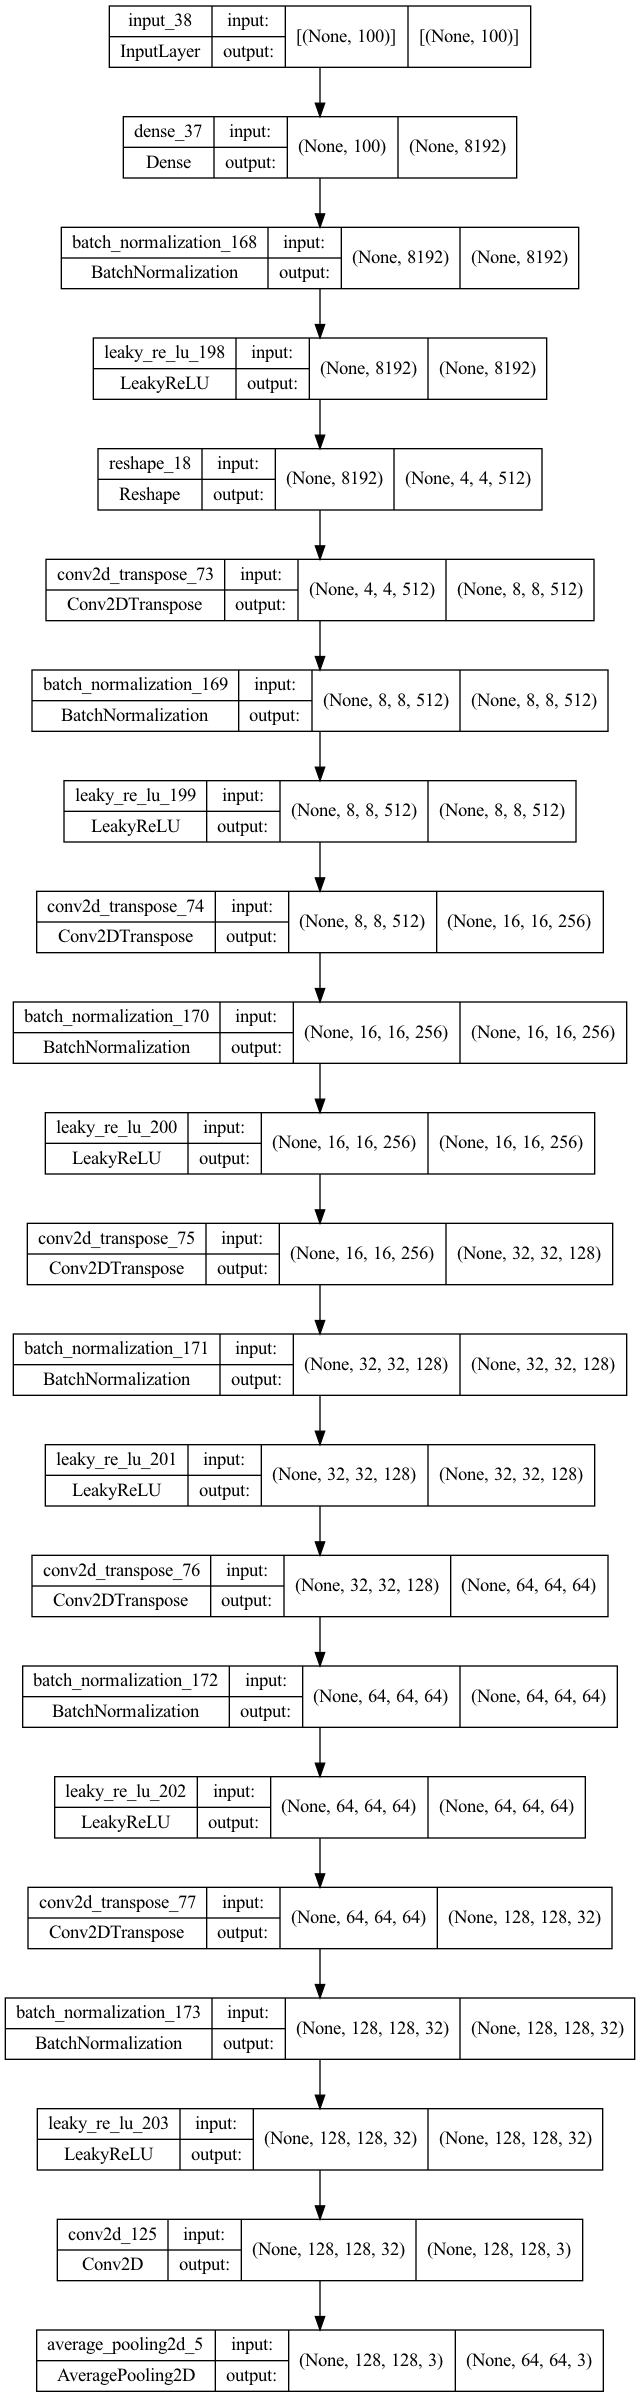

In [59]:
# define the discriminator model
model = define_discriminator()
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='Our_descriminator.png', show_shapes=True, show_layer_names=True)

# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='Our_generator_plot.png', show_shapes=True, show_layer_names=True)

In [60]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
            
    gen_output = g_model.output
    
    gan_output = d_model(gen_output)
    
    model = Model(g_model.input, gan_output)
    # compile model
    #opt = RMSprop(lr=0.00005)
    #model.compile(loss=wasserstein_loss, optimizer=opt)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

Model: "model_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 100)]             0         
                                                                 
 dense_39 (Dense)            (None, 8192)              827392    
                                                                 
 batch_normalization_179 (Ba  (None, 8192)             32768     
 tchNormalization)                                               
                                                                 
 leaky_re_lu_210 (LeakyReLU)  (None, 8192)             0         
                                                                 
 reshape_19 (Reshape)        (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_78 (Conv2D  (None, 8, 8, 512)        2359808   
 Transpose)                                               

/Users/wuw/miniforge3/envs/env_tendorflow/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


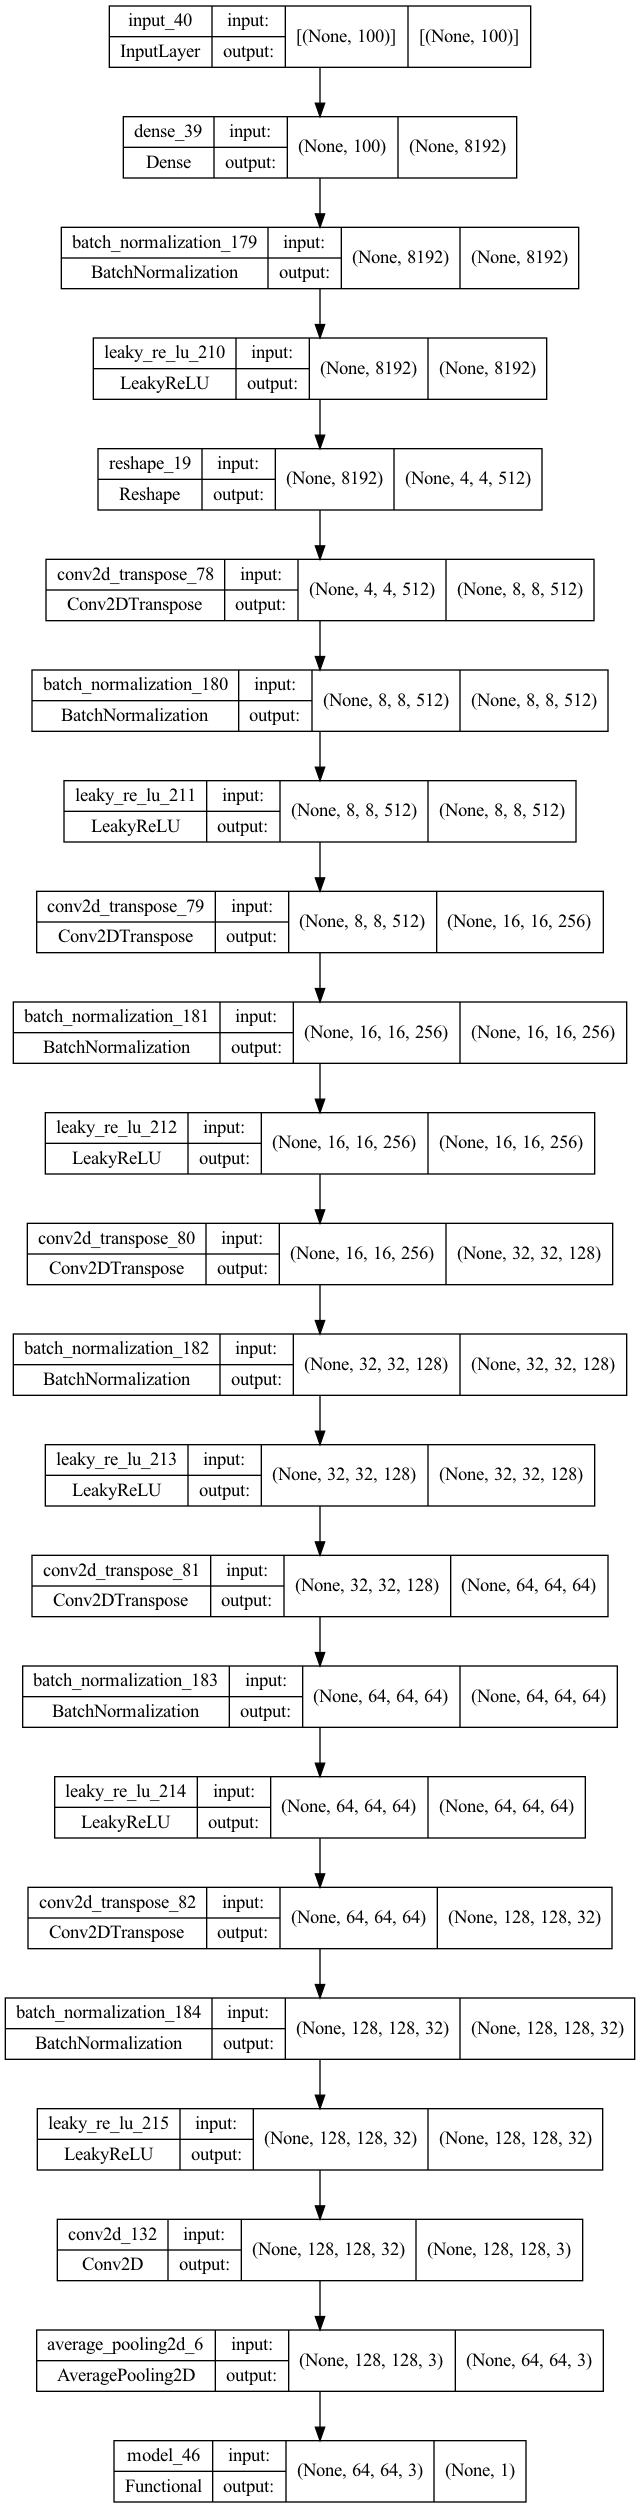

In [61]:
np.random.seed(1234)
tf.random.set_seed(1234)

# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)

gan_model.summary()
# plot the model
plot_model(gan_model, to_file='Our_GAN.png', show_shapes=True, show_layer_names=True)

In [46]:
WikiArt_Emotion_DIR = "/Users/wuw/Downloads/WikiArt-Emotions/WikiArt-Emotions-Ag4.tsv"
WikiArt_DIR = "/Users/wuw/Downloads/archive"
BATCH_SIZE = 256

def load_img_list(filename):
    WikiArt_DIR = "/Users/wuw/Downloads/archive"
    path = os.path.join(WikiArt_DIR, filename)
    X = pd.read_csv(path, sep='\t', header=None)
    return [name for name in X[0]]

def get_image(my_data_dir, IMG_DIR, image_name):
    image = Image.open(os.path.join(my_data_dir, IMG_DIR, image_name))
    #image = image.resize((64, 64), resample=Image.LANCZOS)
    image = tf.image.resize(image, [64, 64])
    image = np.asarray(image).astype("float32")
    image = (image - 127.5) / 127.5
    return image

def show_image(img):
    if len(img.shape) == 2:
        img = gray2rgb(img)
    plt.imshow(img, interpolation='nearest')

def load_data(my_data_dir, IMG_DIR, filename):
    img_list = load_img_list(filename)
    data = []
    for i, img_name in enumerate(img_list):
        img = get_image(my_data_dir, IMG_DIR, img_name)
        if img.shape != (64, 64, 3):
            print(f"Cannot read image {i}: {img_name}")
            #data.append(data[-1])
        else:
            data.append(img)
    return np.stack(data)

In [10]:
temp = load_img_list("flower.txt")

In [40]:
img.shape

(64, 64, 3)

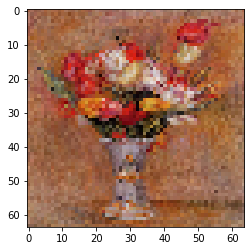

In [47]:
img = get_image(WikiArt_DIR, "flower-painting", temp[4])
show_image((img+1)/2)

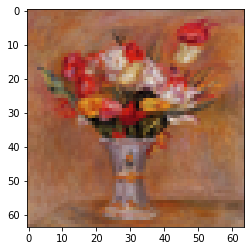

In [45]:
img = get_image(WikiArt_DIR, "flower-painting", temp[4])
show_image((img+1)/2)

In [48]:
tf.data

<module 'tensorflow._api.v2.data' from '/Users/wuw/miniforge3/envs/env_tendorflow/lib/python3.9/site-packages/tensorflow/_api/v2/data/__init__.py'>

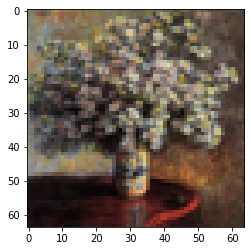

In [29]:
img = get_image(WikiArt_DIR, "flower-painting", temp[2])
show_image((img+1)/2)

In [13]:
import scipy.misc

image = scipy.misc.imread(f"/Users/wuw/Downloads/archive/flower-painting/{temp[0]}")

AttributeError: module 'scipy.misc' has no attribute 'imread'

In [24]:
import cv2
im = cv2.imread(f"/Users/wuw/Downloads/archive/flower-painting/{temp[2]}")
im = cv2.resize(im, (64, 64), interpolation = cv2.INTER_AREA)
cv2.imshow(im)

error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'imshow'
> Overload resolution failed:
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)


In [29]:
img_train = load_data(WikiArt_DIR, "landscape", "landscape.txt")

Cannot read image 16: 005614d74c1636a9aaf812a1dfe74ff8c.jpg
Cannot read image 47: 00e1fdb4502048b1709e5a707e2c479bc.jpg
Cannot read image 366: 063431a73b43d104d1ad8a7aa1dbd7fac.jpg
Cannot read image 566: 09a1fff9a0e3c9e09af757c1026e60bac.jpg
Cannot read image 640: 0b20fbe735bc4641dd719030a07d932cc.jpg
Cannot read image 744: 0cbc5d5b9842a056ca5ab4bf79ba72c7c.jpg
Cannot read image 747: 0cbdca5e7d18030401ec21f53cf5294fc.jpg
Cannot read image 955: 1063334d832fa401142aec66895fa7eac.jpg
Cannot read image 1265: 15a7cf2e223ee35aaa8286b2b680013fc.jpg
Cannot read image 1727: 1d2f153f4814b70c8f330bcf42615d9cc.jpg
Cannot read image 2637: 2cab0efe825732b3c26fb730d0bf9d22c.jpg
Cannot read image 2862: 30b0068747d64d06445a70e01c8dd560c.jpg
Cannot read image 2992: 32b518d4508caaeb50881ef1875e74dbc.jpg
Cannot read image 3303: 37e0b420eee86ae6a03731f47057d643c.jpg
Cannot read image 3676: 3e1c4a4a44e4d95ef6db554c25be4f15c.jpg
Cannot read image 3828: 403a7891722c7969469e25643c7af6acc.jpg
Cannot read image 

/Users/wuw/miniforge3/envs/env_tendorflow/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Cannot read image 6241: 6a6ddd4d03c2a04b9f63b3f81737f574c.jpg
Cannot read image 6249: 6a98757d4d57d5c85518d802bd5e3282c.jpg
Cannot read image 6273: 6af82a7fde23509f62838e442a429a0cc.jpg
Cannot read image 6366: 6c9cb45cda7fbb5c08f359310659672ec.jpg
Cannot read image 6445: 6e01b651af4b0ef5cd40cbd0fef0a443c.jpg
Cannot read image 6492: 6ec6335c7659320c25186c2c1c68b99cc.jpg
Cannot read image 6682: 7266f1d4b6071ba267e830036233d84fc.jpg
Cannot read image 7033: 781c7bae1d2b9e383935184d1afb8a2cc.jpg
Cannot read image 7405: 7e9b2b382edcc43fa56af36fbfcafd9cc.jpg
Cannot read image 7492: 801a7f9eb8b95ffe92add9477b395ccac.jpg
Cannot read image 7851: 86097df99e934037aff9eac75d86689fc.jpg
Cannot read image 8058: 896c5ec21f57cc30aea60906c33d55b3c.jpg
Cannot read image 8232: 8cf8e9c1ba49cdd6fd6b7f750a75b096c.jpg
Cannot read image 8297: 8e300c43f743b4d56f1cfbc0b15e1bdec.jpg
Cannot read image 9203: 9cd4a629232233c053829651a81e8bf6c.jpg
Cannot read image 9233: 9d6696229abc7895875b49b38a09c3c1c.jpg
Cannot r

In [6]:
img_flower = load_data(WikiArt_DIR, "flower-painting", "flower.txt")

Cannot read image 83: 0aa0e20cda65ecb535d3714d166af357c.jpg
Cannot read image 146: 13b904fb4feb1eac012827c2db8413c0c.jpg


KeyboardInterrupt: 

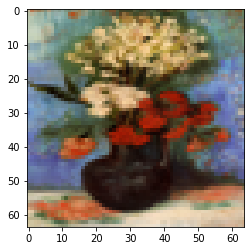

In [69]:
plt.imshow((img_flower[300]+1)/2)

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # select images
    X = dataset[ix]
    # generate class labels, -1 for 'real'
    #y = -np.ones((n_samples, 1))
    y = np.ones((n_samples, 1))
    return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create class labels with 1.0 for 'fake'
    #y = np.ones((n_samples, 1))
    y = np.zeros((n_samples, 1))
    return X, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=4):
    # prepare fake examples
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    
    # plot images
    for i in range(n_samples):
        # define subplot
        plt.subplot(2, 2, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(X[i])
    # save plot to file
    filename1 = 'flower_generated_plot_%04d.png' % (step)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    #filename2 = 'notW_g_model_%04d.h5' % (step)
    #g_model.save(filename2)
    
# train the generator and critic
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=4000, n_batch=128, n_critic=5):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = n_batch // 2
    
    summarize_performance(0, g_model, latent_dim)
    for epoch in range(n_epochs):
        for cur_batch in range(bat_per_epo):
            for _ in range(1):
                X_real, y_real = generate_real_samples(dataset, half_batch)
                X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

                d_loss1 = d_model.train_on_batch(X_real, y_real)
                d_loss2 = d_model.train_on_batch(X_fake, y_fake)
            
            X_gan = generate_latent_points(latent_dim, n_batch)
            #y_gan = -np.ones((n_batch, 1))
            y_gan = np.ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            print(">%d-%d, d1=%.3f, d2=%.3f, g=%.3f" % (epoch+1, cur_batch+1, d_loss1, d_loss2, g_loss))
        if epoch % 20 == 0:
            summarize_performance(epoch+1, g_model, latent_dim)

np.random.seed(1234)
tf.random.set_seed(1234)
# size of the latent space
latent_dim = 100
# create the critic
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
#dataset = load_data()
#dataset = img_train
dataset = img_flower
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

2022-02-21 01:40:29.835719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-02-21 01:40:30.861915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-02-21 01:40:31.413253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-02-21 01:40:32.314307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


>1-1, d1=0.715, d2=5.912, g=0.264
>1-2, d1=0.090, d2=0.737, g=2.749
>1-3, d1=1.133, d2=0.075, g=0.638
>1-4, d1=0.288, d2=0.240, g=0.127
>1-5, d1=0.060, d2=0.007, g=0.065
>1-6, d1=0.055, d2=0.006, g=0.021
>1-7, d1=0.062, d2=0.012, g=0.010
>1-8, d1=0.010, d2=0.016, g=0.008
>1-9, d1=0.014, d2=0.010, g=0.006
>1-10, d1=0.009, d2=0.007, g=0.006
>1-11, d1=0.008, d2=0.006, g=0.006
>1-12, d1=0.012, d2=0.005, g=0.005
>1-13, d1=0.006, d2=0.004, g=0.004
>2-1, d1=0.004, d2=0.004, g=0.005
>2-2, d1=0.004, d2=0.003, g=0.004
>2-3, d1=0.006, d2=0.002, g=0.003
>2-4, d1=0.003, d2=0.002, g=0.004
>2-5, d1=0.002, d2=0.002, g=0.003
>2-6, d1=0.003, d2=0.002, g=0.003
>2-7, d1=0.004, d2=0.002, g=0.002
>2-8, d1=0.003, d2=0.002, g=0.002
>2-9, d1=0.003, d2=0.001, g=0.002
>2-10, d1=0.004, d2=0.001, g=0.002
>2-11, d1=0.003, d2=0.001, g=0.002
>2-12, d1=0.001, d2=0.001, g=0.002
>2-13, d1=0.002, d2=0.001, g=0.002
>3-1, d1=0.001, d2=0.001, g=0.001
>3-2, d1=0.002, d2=0.001, g=0.001
>3-3, d1=0.001, d2=0.001, g=0.001
>3-4, 

>19-3, d1=0.000, d2=0.000, g=0.000
>19-4, d1=0.000, d2=0.000, g=0.000
>19-5, d1=0.000, d2=0.000, g=0.000
>19-6, d1=0.000, d2=0.000, g=0.000
>19-7, d1=0.000, d2=0.000, g=0.000
>19-8, d1=0.000, d2=0.000, g=0.000
>19-9, d1=0.000, d2=0.000, g=0.000
>19-10, d1=0.000, d2=0.000, g=0.000
>19-11, d1=0.000, d2=0.000, g=0.000
>19-12, d1=0.000, d2=0.000, g=0.000
>19-13, d1=0.000, d2=0.000, g=0.000
>20-1, d1=0.000, d2=0.000, g=0.000
>20-2, d1=0.000, d2=0.000, g=0.000
>20-3, d1=0.000, d2=0.000, g=0.000
>20-4, d1=0.000, d2=0.000, g=0.000
>20-5, d1=0.000, d2=0.000, g=0.000
>20-6, d1=0.000, d2=0.000, g=0.000
>20-7, d1=0.000, d2=0.000, g=0.000
>20-8, d1=0.000, d2=0.000, g=0.000
>20-9, d1=0.000, d2=0.000, g=0.000
>20-10, d1=0.000, d2=0.000, g=0.000
>20-11, d1=0.000, d2=0.000, g=0.000
>20-12, d1=0.000, d2=0.000, g=0.000
>20-13, d1=0.000, d2=0.000, g=0.000
>21-1, d1=0.000, d2=0.000, g=0.000
>21-2, d1=0.000, d2=0.000, g=0.000
>21-3, d1=0.000, d2=0.000, g=0.000
>21-4, d1=0.000, d2=0.000, g=0.000
>21-5, d1=0.

>37-1, d1=0.003, d2=0.001, g=0.002
>37-2, d1=0.003, d2=0.005, g=0.007
>37-3, d1=0.003, d2=0.003, g=0.004
>37-4, d1=0.002, d2=0.006, g=0.007
>37-5, d1=0.002, d2=0.001, g=0.007
>37-6, d1=0.006, d2=0.000, g=0.010
>37-7, d1=0.002, d2=0.000, g=0.004
>37-8, d1=0.002, d2=0.000, g=0.004
>37-9, d1=0.003, d2=0.001, g=0.003
>37-10, d1=0.001, d2=0.003, g=0.012
>37-11, d1=0.002, d2=0.002, g=0.004
>37-12, d1=0.001, d2=0.000, g=0.003
>37-13, d1=0.002, d2=0.000, g=0.005
>38-1, d1=0.002, d2=0.021, g=0.054
>38-2, d1=0.005, d2=0.000, g=0.097
>38-3, d1=0.036, d2=0.120, g=6.275
>38-4, d1=1.701, d2=6.346, g=3.461
>38-5, d1=1.486, d2=0.100, g=0.505
>38-6, d1=0.174, d2=0.403, g=0.988
>38-7, d1=0.445, d2=0.024, g=0.589
>38-8, d1=0.109, d2=0.202, g=0.363
>38-9, d1=0.195, d2=0.006, g=0.083
>38-10, d1=0.157, d2=0.074, g=0.021
>38-11, d1=0.051, d2=0.013, g=0.027
>38-12, d1=0.040, d2=0.020, g=0.019
>38-13, d1=0.034, d2=0.006, g=0.014
>39-1, d1=0.048, d2=0.100, g=0.194
>39-2, d1=0.040, d2=0.002, g=0.271
>39-3, d1=0.

>54-13, d1=0.002, d2=0.000, g=0.002
>55-1, d1=0.001, d2=0.001, g=0.003
>55-2, d1=0.001, d2=0.001, g=0.003
>55-3, d1=0.002, d2=0.000, g=0.002
>55-4, d1=0.001, d2=0.002, g=0.003
>55-5, d1=0.001, d2=0.001, g=0.002
>55-6, d1=0.000, d2=0.000, g=0.004
>55-7, d1=0.001, d2=0.000, g=0.003
>55-8, d1=0.001, d2=0.001, g=0.003
>55-9, d1=0.001, d2=0.001, g=0.002
>55-10, d1=0.001, d2=0.000, g=0.002
>55-11, d1=0.001, d2=0.003, g=0.008
>55-12, d1=0.001, d2=0.000, g=0.005
>55-13, d1=0.002, d2=0.000, g=0.006
>56-1, d1=0.001, d2=0.001, g=0.003
>56-2, d1=0.001, d2=0.000, g=0.003
>56-3, d1=0.000, d2=0.000, g=0.003
>56-4, d1=0.001, d2=0.007, g=0.014
>56-5, d1=0.003, d2=0.000, g=0.040
>56-6, d1=0.002, d2=0.000, g=0.005
>56-7, d1=0.003, d2=0.002, g=0.003
>56-8, d1=0.002, d2=0.000, g=0.002
>56-9, d1=0.002, d2=0.001, g=0.001
>56-10, d1=0.002, d2=0.000, g=0.001
>56-11, d1=0.002, d2=0.006, g=0.003
>56-12, d1=0.002, d2=0.000, g=0.014
>56-13, d1=0.005, d2=0.000, g=0.005
>57-1, d1=0.001, d2=0.000, g=0.004
>57-2, d1=0

>72-12, d1=0.001, d2=0.001, g=0.000
>72-13, d1=0.004, d2=0.000, g=0.000
>73-1, d1=0.000, d2=0.002, g=0.000
>73-2, d1=0.000, d2=0.000, g=0.001
>73-3, d1=0.000, d2=0.000, g=0.000
>73-4, d1=0.000, d2=0.000, g=0.000
>73-5, d1=0.001, d2=0.000, g=0.000
>73-6, d1=0.001, d2=0.002, g=0.001
>73-7, d1=0.002, d2=0.000, g=0.001
>73-8, d1=0.001, d2=0.000, g=0.001
>73-9, d1=0.000, d2=0.000, g=0.001
>73-10, d1=0.000, d2=0.000, g=0.000
>73-11, d1=0.000, d2=0.000, g=0.001
>73-12, d1=0.002, d2=0.001, g=0.001
>73-13, d1=0.000, d2=0.000, g=0.002
>74-1, d1=0.000, d2=0.000, g=0.001
>74-2, d1=0.000, d2=0.000, g=0.000
>74-3, d1=0.000, d2=0.000, g=0.000
>74-4, d1=0.002, d2=0.000, g=0.000
>74-5, d1=0.000, d2=0.000, g=0.001
>74-6, d1=0.001, d2=0.000, g=0.000
>74-7, d1=0.001, d2=0.000, g=0.000
>74-8, d1=0.000, d2=0.004, g=0.017
>74-9, d1=0.006, d2=0.000, g=0.001
>74-10, d1=0.001, d2=0.000, g=0.000
>74-11, d1=0.001, d2=0.000, g=0.000
>74-12, d1=0.000, d2=0.000, g=0.000
>74-13, d1=0.001, d2=0.003, g=0.000
>75-1, d1=

>90-11, d1=0.001, d2=0.002, g=0.003
>90-12, d1=0.001, d2=0.001, g=0.003
>90-13, d1=0.001, d2=0.001, g=0.003
>91-1, d1=0.002, d2=0.012, g=0.030
>91-2, d1=0.002, d2=0.244, g=0.912
>91-3, d1=0.090, d2=0.359, g=3.010
>91-4, d1=2.311, d2=4.272, g=7.450
>91-5, d1=0.811, d2=0.008, g=3.295
>91-6, d1=0.449, d2=0.270, g=1.156
>91-7, d1=0.248, d2=0.024, g=0.157
>91-8, d1=0.058, d2=0.028, g=0.030
>91-9, d1=0.047, d2=0.019, g=0.019
>91-10, d1=0.032, d2=0.020, g=0.010
>91-11, d1=0.023, d2=0.016, g=0.007
>91-12, d1=0.052, d2=0.010, g=0.006
>91-13, d1=0.038, d2=0.014, g=0.005
>92-1, d1=0.019, d2=0.011, g=0.003
>92-2, d1=0.020, d2=0.002, g=0.003
>92-3, d1=0.016, d2=0.002, g=0.002
>92-4, d1=0.016, d2=0.003, g=0.002
>92-5, d1=0.017, d2=0.003, g=0.001
>92-6, d1=0.014, d2=0.006, g=0.001
>92-7, d1=0.013, d2=0.006, g=0.001
>92-8, d1=0.007, d2=0.003, g=0.001
>92-9, d1=0.007, d2=0.002, g=0.001
>92-10, d1=0.007, d2=0.002, g=0.001
>92-11, d1=0.005, d2=0.002, g=0.001
>92-12, d1=0.005, d2=0.004, g=0.001
>92-13, d1

>108-6, d1=0.001, d2=0.000, g=0.000
>108-7, d1=0.001, d2=0.000, g=0.000
>108-8, d1=0.000, d2=0.000, g=0.000
>108-9, d1=0.000, d2=0.000, g=0.000
>108-10, d1=0.000, d2=0.000, g=0.000
>108-11, d1=0.000, d2=0.001, g=0.002
>108-12, d1=0.000, d2=0.000, g=0.001
>108-13, d1=0.000, d2=0.000, g=0.002
>109-1, d1=0.000, d2=0.000, g=0.001
>109-2, d1=0.001, d2=0.000, g=0.000
>109-3, d1=0.002, d2=0.001, g=0.001
>109-4, d1=0.001, d2=0.000, g=0.000
>109-5, d1=0.001, d2=0.000, g=0.000
>109-6, d1=0.000, d2=0.001, g=0.001
>109-7, d1=0.000, d2=0.001, g=0.003
>109-8, d1=0.000, d2=0.000, g=0.001
>109-9, d1=0.001, d2=0.000, g=0.001
>109-10, d1=0.001, d2=0.000, g=0.000
>109-11, d1=0.000, d2=0.002, g=0.002
>109-12, d1=0.001, d2=0.000, g=0.007
>109-13, d1=0.001, d2=0.000, g=0.001
>110-1, d1=0.001, d2=0.000, g=0.000
>110-2, d1=0.001, d2=0.004, g=0.003
>110-3, d1=0.001, d2=0.000, g=0.015
>110-4, d1=0.001, d2=0.000, g=0.000
>110-5, d1=0.001, d2=0.023, g=8.763
>110-6, d1=0.038, d2=5.977, g=17.104
>110-7, d1=12.013, 

>125-11, d1=0.006, d2=0.001, g=0.002
>125-12, d1=0.003, d2=0.001, g=0.002
>125-13, d1=0.004, d2=0.003, g=0.002
>126-1, d1=0.005, d2=0.003, g=0.004
>126-2, d1=0.003, d2=0.002, g=0.003
>126-3, d1=0.003, d2=0.001, g=0.003
>126-4, d1=0.006, d2=0.003, g=0.003
>126-5, d1=0.002, d2=0.002, g=0.004
>126-6, d1=0.004, d2=0.011, g=0.012
>126-7, d1=0.003, d2=0.002, g=0.024
>126-8, d1=0.003, d2=0.002, g=0.006
>126-9, d1=0.005, d2=0.006, g=0.004
>126-10, d1=0.008, d2=0.007, g=0.005
>126-11, d1=0.007, d2=0.001, g=0.005
>126-12, d1=0.005, d2=0.005, g=0.006
>126-13, d1=0.024, d2=0.004, g=0.004
>127-1, d1=0.008, d2=0.001, g=0.003
>127-2, d1=0.007, d2=0.009, g=0.005
>127-3, d1=0.003, d2=0.001, g=0.015
>127-4, d1=0.004, d2=0.001, g=0.009
>127-5, d1=0.005, d2=0.003, g=0.004
>127-6, d1=0.009, d2=0.002, g=0.005
>127-7, d1=0.003, d2=0.005, g=0.006
>127-8, d1=0.005, d2=0.004, g=0.007
>127-9, d1=0.005, d2=0.002, g=0.008
>127-10, d1=0.006, d2=0.001, g=0.005
>127-11, d1=0.006, d2=0.003, g=0.005
>127-12, d1=0.005, 

>143-3, d1=0.119, d2=0.067, g=0.115
>143-4, d1=0.063, d2=0.025, g=0.107
>143-5, d1=0.060, d2=0.051, g=0.067
>143-6, d1=0.054, d2=0.194, g=1.003
>143-7, d1=0.077, d2=0.051, g=0.699
>143-8, d1=0.250, d2=0.139, g=0.068
>143-9, d1=0.096, d2=0.890, g=3.506
>143-10, d1=2.822, d2=1.430, g=0.125
>143-11, d1=0.205, d2=0.301, g=0.319
>143-12, d1=0.281, d2=0.160, g=0.203
>143-13, d1=0.362, d2=0.433, g=0.318
>144-1, d1=0.238, d2=0.175, g=0.126
>144-2, d1=0.231, d2=0.128, g=0.067
>144-3, d1=0.175, d2=0.243, g=0.086
>144-4, d1=0.471, d2=0.851, g=0.363
>144-5, d1=0.648, d2=0.088, g=0.229
>144-6, d1=0.606, d2=1.233, g=0.382
>144-7, d1=0.681, d2=0.270, g=0.609
>144-8, d1=0.297, d2=1.175, g=2.287
>144-9, d1=1.287, d2=0.276, g=0.904
>144-10, d1=0.232, d2=0.926, g=1.861
>144-11, d1=1.327, d2=0.700, g=1.221
>144-12, d1=0.644, d2=0.851, g=1.475
>144-13, d1=0.769, d2=0.395, g=0.988
>145-1, d1=0.546, d2=0.611, g=0.908
>145-2, d1=0.339, d2=0.866, g=2.570
>145-3, d1=1.151, d2=0.500, g=0.928
>145-4, d1=0.438, d2

>160-8, d1=0.001, d2=0.001, g=0.014
>160-9, d1=0.002, d2=0.004, g=0.013
>160-10, d1=0.003, d2=0.001, g=0.007
>160-11, d1=0.006, d2=0.003, g=0.011
>160-12, d1=0.002, d2=0.040, g=0.012
>160-13, d1=0.001, d2=0.000, g=0.032
>161-1, d1=0.007, d2=0.001, g=0.055
>161-2, d1=0.013, d2=0.000, g=0.012
>161-3, d1=0.005, d2=0.004, g=0.003
>161-4, d1=0.039, d2=0.002, g=0.001
>161-5, d1=0.010, d2=0.007, g=0.002
>161-6, d1=0.003, d2=0.002, g=0.002
>161-7, d1=0.002, d2=0.002, g=0.003
>161-8, d1=0.005, d2=0.002, g=0.001
>161-9, d1=0.001, d2=0.002, g=0.003
>161-10, d1=0.001, d2=0.125, g=0.869
>161-11, d1=0.007, d2=0.000, g=0.184
>161-12, d1=0.055, d2=0.002, g=0.008
>161-13, d1=0.011, d2=0.013, g=0.003
>162-1, d1=0.030, d2=0.004, g=0.002
>162-2, d1=0.040, d2=0.036, g=0.006
>162-3, d1=0.020, d2=0.002, g=0.007
>162-4, d1=0.018, d2=0.003, g=0.004
>162-5, d1=0.010, d2=0.002, g=0.007
>162-6, d1=0.004, d2=0.008, g=0.002
>162-7, d1=0.007, d2=0.001, g=0.005
>162-8, d1=0.035, d2=0.012, g=0.003
>162-9, d1=0.032, d2

>177-13, d1=0.001, d2=0.000, g=0.006
>178-1, d1=0.001, d2=0.005, g=0.004
>178-2, d1=0.001, d2=0.002, g=0.005
>178-3, d1=0.008, d2=0.032, g=0.055
>178-4, d1=0.001, d2=0.000, g=0.164
>178-5, d1=0.045, d2=0.002, g=0.001
>178-6, d1=0.003, d2=0.105, g=0.389
>178-7, d1=0.028, d2=0.000, g=0.645
>178-8, d1=1.073, d2=7.569, g=0.837
>178-9, d1=0.063, d2=0.029, g=1.592
>178-10, d1=0.450, d2=0.284, g=0.733
>178-11, d1=0.273, d2=0.173, g=0.352
>178-12, d1=0.106, d2=0.021, g=0.147
>178-13, d1=0.196, d2=0.139, g=0.068
>179-1, d1=0.059, d2=0.019, g=0.117
>179-2, d1=0.095, d2=0.016, g=0.012
>179-3, d1=0.027, d2=0.039, g=0.018
>179-4, d1=0.024, d2=0.013, g=0.013
>179-5, d1=0.047, d2=0.044, g=0.009
>179-6, d1=0.029, d2=0.006, g=0.011
>179-7, d1=0.062, d2=0.012, g=0.006
>179-8, d1=0.016, d2=0.032, g=0.008
>179-9, d1=0.026, d2=0.013, g=0.007
>179-10, d1=0.007, d2=0.004, g=0.008
>179-11, d1=0.012, d2=0.002, g=0.007
>179-12, d1=0.040, d2=0.009, g=0.004
>179-13, d1=0.013, d2=0.008, g=0.004
>180-1, d1=0.023, d

>195-5, d1=0.002, d2=0.008, g=0.009
>195-6, d1=0.007, d2=0.019, g=0.013
>195-7, d1=0.009, d2=0.008, g=0.028
>195-8, d1=0.006, d2=0.008, g=0.027
>195-9, d1=0.013, d2=0.001, g=0.018
>195-10, d1=0.009, d2=0.002, g=0.017
>195-11, d1=0.004, d2=0.002, g=0.013
>195-12, d1=0.005, d2=0.001, g=0.014
>195-13, d1=0.008, d2=0.002, g=0.008
>196-1, d1=0.003, d2=0.003, g=0.009
>196-2, d1=0.003, d2=0.001, g=0.008
>196-3, d1=0.002, d2=0.004, g=0.010
>196-4, d1=0.003, d2=0.003, g=0.009
>196-5, d1=0.002, d2=0.007, g=0.012
>196-6, d1=0.005, d2=0.002, g=0.014
>196-7, d1=0.004, d2=0.003, g=0.011
>196-8, d1=0.003, d2=0.002, g=0.008
>196-9, d1=0.002, d2=0.011, g=0.016
>196-10, d1=0.010, d2=0.002, g=0.022
>196-11, d1=0.003, d2=0.001, g=0.015
>196-12, d1=0.006, d2=0.003, g=0.013
>196-13, d1=0.016, d2=0.001, g=0.008
>197-1, d1=0.002, d2=0.003, g=0.009
>197-2, d1=0.006, d2=0.005, g=0.008
>197-3, d1=0.005, d2=0.002, g=0.009
>197-4, d1=0.004, d2=0.002, g=0.012
>197-5, d1=0.009, d2=0.003, g=0.009
>197-6, d1=0.004, d2

>212-10, d1=0.012, d2=0.004, g=0.040
>212-11, d1=0.028, d2=0.220, g=0.920
>212-12, d1=0.288, d2=0.139, g=0.053
>212-13, d1=0.066, d2=0.080, g=0.067
>213-1, d1=0.110, d2=0.195, g=0.336
>213-2, d1=0.501, d2=0.714, g=0.757
>213-3, d1=0.251, d2=0.131, g=0.430
>213-4, d1=0.124, d2=0.003, g=0.012
>213-5, d1=0.021, d2=0.025, g=0.004
>213-6, d1=0.005, d2=0.246, g=0.910
>213-7, d1=0.165, d2=0.000, g=0.018
>213-8, d1=0.007, d2=0.014, g=0.003
>213-9, d1=0.001, d2=0.004, g=0.001
>213-10, d1=0.008, d2=0.023, g=0.003
>213-11, d1=0.041, d2=0.000, g=0.002
>213-12, d1=0.004, d2=0.011, g=0.001
>213-13, d1=0.009, d2=0.003, g=0.001
>214-1, d1=0.001, d2=0.003, g=0.001
>214-2, d1=0.003, d2=0.002, g=0.002
>214-3, d1=0.001, d2=0.002, g=0.002
>214-4, d1=0.005, d2=0.005, g=0.004
>214-5, d1=0.002, d2=0.007, g=0.002
>214-6, d1=0.003, d2=0.007, g=0.007
>214-7, d1=0.003, d2=0.000, g=0.007
>214-8, d1=0.010, d2=0.000, g=0.006
>214-9, d1=0.003, d2=0.026, g=0.020
>214-10, d1=0.003, d2=0.000, g=0.059
>214-11, d1=0.026, 

>230-2, d1=0.003, d2=0.005, g=0.000
>230-3, d1=0.000, d2=0.000, g=0.000
>230-4, d1=0.001, d2=0.001, g=0.000
>230-5, d1=0.000, d2=0.007, g=0.000
>230-6, d1=0.000, d2=0.000, g=0.000
>230-7, d1=0.007, d2=0.000, g=0.000
>230-8, d1=0.003, d2=0.003, g=0.000
>230-9, d1=0.000, d2=0.006, g=0.000
>230-10, d1=0.002, d2=0.000, g=0.000
>230-11, d1=0.001, d2=0.003, g=0.000
>230-12, d1=0.003, d2=0.003, g=0.000
>230-13, d1=0.005, d2=0.001, g=0.000
>231-1, d1=0.001, d2=0.008, g=0.000
>231-2, d1=0.000, d2=0.004, g=0.000
>231-3, d1=0.067, d2=0.002, g=0.000
>231-4, d1=0.001, d2=0.014, g=0.000
>231-5, d1=0.000, d2=0.001, g=0.000
>231-6, d1=0.000, d2=0.063, g=0.000
>231-7, d1=0.002, d2=0.001, g=0.000
>231-8, d1=0.022, d2=0.000, g=0.000
>231-9, d1=0.004, d2=0.000, g=0.000
>231-10, d1=0.000, d2=0.000, g=0.000
>231-11, d1=0.000, d2=0.022, g=0.000
>231-12, d1=0.001, d2=0.001, g=0.000
>231-13, d1=0.018, d2=0.001, g=0.000
>232-1, d1=0.003, d2=0.001, g=0.000
>232-2, d1=0.000, d2=0.000, g=0.000
>232-3, d1=0.001, d2

>247-7, d1=0.002, d2=0.000, g=0.004
>247-8, d1=0.004, d2=0.026, g=0.013
>247-9, d1=0.007, d2=0.001, g=0.042
>247-10, d1=0.033, d2=0.015, g=0.003
>247-11, d1=0.004, d2=0.001, g=0.008
>247-12, d1=0.002, d2=0.007, g=0.003
>247-13, d1=0.012, d2=0.005, g=0.005
>248-1, d1=0.003, d2=0.002, g=0.014
>248-2, d1=0.006, d2=0.002, g=0.005
>248-3, d1=0.002, d2=0.006, g=0.010
>248-4, d1=0.006, d2=0.002, g=0.003
>248-5, d1=0.004, d2=0.003, g=0.003
>248-6, d1=0.002, d2=0.003, g=0.002
>248-7, d1=0.032, d2=0.007, g=0.001
>248-8, d1=0.011, d2=0.005, g=0.004
>248-9, d1=0.010, d2=0.004, g=0.002
>248-10, d1=0.000, d2=0.002, g=0.002
>248-11, d1=0.003, d2=0.007, g=0.002
>248-12, d1=0.001, d2=0.003, g=0.004
>248-13, d1=0.003, d2=0.009, g=0.017
>249-1, d1=0.003, d2=0.004, g=0.018
>249-2, d1=0.001, d2=0.003, g=0.008
>249-3, d1=0.002, d2=0.006, g=0.007
>249-4, d1=0.002, d2=0.002, g=0.012
>249-5, d1=0.001, d2=0.006, g=0.005
>249-6, d1=0.003, d2=0.001, g=0.015
>249-7, d1=0.007, d2=0.001, g=0.003
>249-8, d1=0.001, d2

>264-12, d1=0.003, d2=0.001, g=0.037
>264-13, d1=0.017, d2=0.001, g=0.015
>265-1, d1=0.010, d2=0.006, g=0.011
>265-2, d1=0.008, d2=0.003, g=0.011
>265-3, d1=0.012, d2=0.009, g=0.011
>265-4, d1=0.001, d2=0.005, g=0.015
>265-5, d1=0.009, d2=0.005, g=0.009
>265-6, d1=0.002, d2=0.010, g=0.019
>265-7, d1=0.005, d2=0.001, g=0.018
>265-8, d1=0.004, d2=0.003, g=0.016
>265-9, d1=0.006, d2=0.002, g=0.010
>265-10, d1=0.002, d2=0.003, g=0.012
>265-11, d1=0.002, d2=0.010, g=0.022
>265-12, d1=0.004, d2=0.001, g=0.037
>265-13, d1=0.004, d2=0.002, g=0.011
>266-1, d1=0.006, d2=0.006, g=0.010
>266-2, d1=0.005, d2=0.005, g=0.022
>266-3, d1=0.002, d2=0.002, g=0.010
>266-4, d1=0.010, d2=0.005, g=0.019
>266-5, d1=0.004, d2=0.008, g=0.017
>266-6, d1=0.007, d2=0.002, g=0.010
>266-7, d1=0.009, d2=0.008, g=0.022
>266-8, d1=0.043, d2=0.008, g=0.007
>266-9, d1=0.009, d2=0.011, g=0.011
>266-10, d1=0.001, d2=0.007, g=0.011
>266-11, d1=0.005, d2=0.002, g=0.022
>266-12, d1=0.018, d2=0.006, g=0.018
>266-13, d1=0.005, 

>282-4, d1=0.004, d2=0.003, g=0.005
>282-5, d1=0.008, d2=0.007, g=0.019
>282-6, d1=0.004, d2=0.002, g=0.014
>282-7, d1=0.001, d2=0.020, g=0.006
>282-8, d1=0.013, d2=0.010, g=0.009
>282-9, d1=0.033, d2=0.033, g=0.018
>282-10, d1=0.003, d2=0.001, g=0.010
>282-11, d1=0.139, d2=0.010, g=0.000
>282-12, d1=0.001, d2=0.137, g=0.006
>282-13, d1=0.003, d2=0.001, g=0.074
>283-1, d1=0.017, d2=0.027, g=0.184
>283-2, d1=0.073, d2=0.541, g=9.532
>283-3, d1=5.983, d2=2.942, g=1.421
>283-4, d1=0.058, d2=0.682, g=2.343
>283-5, d1=1.317, d2=0.712, g=0.306
>283-6, d1=0.461, d2=0.666, g=0.378
>283-7, d1=1.528, d2=0.876, g=0.107
>283-8, d1=0.224, d2=0.015, g=0.035
>283-9, d1=0.142, d2=0.040, g=0.020
>283-10, d1=0.070, d2=0.034, g=0.006
>283-11, d1=0.056, d2=0.086, g=0.005
>283-12, d1=0.022, d2=0.049, g=0.009
>283-13, d1=0.058, d2=0.008, g=0.017
>284-1, d1=0.050, d2=0.086, g=0.017
>284-2, d1=0.037, d2=0.013, g=0.038
>284-3, d1=0.073, d2=0.013, g=0.009
>284-4, d1=0.016, d2=0.029, g=0.007
>284-5, d1=0.016, d2

>299-9, d1=0.001, d2=0.012, g=0.008
>299-10, d1=0.002, d2=0.002, g=0.031
>299-11, d1=0.001, d2=0.002, g=0.004
>299-12, d1=0.001, d2=0.001, g=0.004
>299-13, d1=0.001, d2=0.001, g=0.002
>300-1, d1=0.006, d2=0.002, g=0.002
>300-2, d1=0.003, d2=0.002, g=0.002
>300-3, d1=0.001, d2=0.017, g=0.005
>300-4, d1=0.001, d2=0.000, g=0.022
>300-5, d1=0.003, d2=0.000, g=0.027
>300-6, d1=0.002, d2=0.001, g=0.009
>300-7, d1=0.005, d2=0.001, g=0.002
>300-8, d1=0.018, d2=0.010, g=0.001
>300-9, d1=0.002, d2=0.001, g=0.001
>300-10, d1=0.015, d2=0.012, g=0.001
>300-11, d1=0.002, d2=0.006, g=0.004
>300-12, d1=0.004, d2=0.005, g=0.010
>300-13, d1=0.002, d2=0.002, g=0.023
>301-1, d1=0.006, d2=0.001, g=0.007
>301-2, d1=0.005, d2=0.001, g=0.004
>301-3, d1=0.006, d2=0.001, g=0.002
>301-4, d1=0.002, d2=0.008, g=0.003
>301-5, d1=0.011, d2=0.006, g=0.002
>301-6, d1=0.023, d2=0.002, g=0.001
>301-7, d1=0.000, d2=0.007, g=0.002
>301-8, d1=0.001, d2=0.009, g=0.007
>301-9, d1=0.006, d2=0.002, g=0.005
>301-10, d1=0.001, d

>317-1, d1=0.198, d2=0.278, g=0.316
>317-2, d1=0.337, d2=0.029, g=0.006
>317-3, d1=0.086, d2=0.072, g=0.005
>317-4, d1=0.014, d2=0.041, g=0.018
>317-5, d1=0.060, d2=0.076, g=0.013
>317-6, d1=0.019, d2=0.007, g=0.007
>317-7, d1=0.169, d2=0.026, g=0.004
>317-8, d1=0.008, d2=0.063, g=0.007
>317-9, d1=0.018, d2=0.051, g=0.016
>317-10, d1=0.052, d2=0.001, g=0.010
>317-11, d1=0.075, d2=0.005, g=0.003
>317-12, d1=0.010, d2=0.003, g=0.003
>317-13, d1=0.003, d2=0.026, g=0.003
>318-1, d1=0.013, d2=0.003, g=0.002
>318-2, d1=0.006, d2=0.004, g=0.004
>318-3, d1=0.006, d2=0.012, g=0.004
>318-4, d1=0.003, d2=0.001, g=0.009
>318-5, d1=0.002, d2=0.002, g=0.003
>318-6, d1=0.008, d2=0.015, g=0.003
>318-7, d1=0.010, d2=0.002, g=0.003
>318-8, d1=0.009, d2=0.000, g=0.005
>318-9, d1=0.003, d2=0.002, g=0.003
>318-10, d1=0.012, d2=0.006, g=0.003
>318-11, d1=0.003, d2=0.001, g=0.003
>318-12, d1=0.003, d2=0.008, g=0.003
>318-13, d1=0.005, d2=0.006, g=0.004
>319-1, d1=0.006, d2=0.000, g=0.004
>319-2, d1=0.006, d2

>334-6, d1=0.009, d2=0.014, g=0.018
>334-7, d1=0.010, d2=0.004, g=0.010
>334-8, d1=0.022, d2=0.009, g=0.005
>334-9, d1=0.038, d2=0.009, g=0.005
>334-10, d1=0.012, d2=0.005, g=0.005
>334-11, d1=0.002, d2=0.015, g=0.005
>334-12, d1=0.024, d2=0.022, g=0.007
>334-13, d1=0.005, d2=0.005, g=0.007
>335-1, d1=0.026, d2=0.006, g=0.007
>335-2, d1=0.008, d2=0.020, g=0.008
>335-3, d1=0.002, d2=0.008, g=0.014
>335-4, d1=0.021, d2=0.006, g=0.010
>335-5, d1=0.019, d2=0.008, g=0.005
>335-6, d1=0.004, d2=0.008, g=0.007
>335-7, d1=0.013, d2=0.020, g=0.008
>335-8, d1=0.019, d2=0.004, g=0.005
>335-9, d1=0.005, d2=0.012, g=0.005
>335-10, d1=0.002, d2=0.011, g=0.012
>335-11, d1=0.008, d2=0.005, g=0.011
>335-12, d1=0.004, d2=0.013, g=0.009
>335-13, d1=0.005, d2=0.021, g=0.025
>336-1, d1=0.054, d2=0.013, g=0.016
>336-2, d1=0.019, d2=0.044, g=0.041
>336-3, d1=0.001, d2=0.009, g=0.071
>336-4, d1=0.011, d2=0.005, g=0.028
>336-5, d1=0.004, d2=0.010, g=0.023
>336-6, d1=0.004, d2=0.013, g=0.021
>336-7, d1=0.002, d2

>351-11, d1=0.019, d2=0.000, g=0.004
>351-12, d1=0.004, d2=0.000, g=0.009
>351-13, d1=0.008, d2=0.000, g=0.001
>352-1, d1=0.028, d2=0.001, g=0.001
>352-2, d1=0.001, d2=0.002, g=0.000
>352-3, d1=0.001, d2=0.001, g=0.001
>352-4, d1=0.000, d2=0.000, g=0.001
>352-5, d1=0.001, d2=0.000, g=0.001
>352-6, d1=0.004, d2=0.008, g=0.000
>352-7, d1=0.000, d2=0.000, g=0.001
>352-8, d1=0.002, d2=0.000, g=0.001
>352-9, d1=0.002, d2=0.000, g=0.000
>352-10, d1=0.004, d2=0.023, g=0.001
>352-11, d1=0.001, d2=0.003, g=0.014
>352-12, d1=0.003, d2=0.002, g=0.007
>352-13, d1=0.006, d2=0.067, g=0.024
>353-1, d1=0.002, d2=0.000, g=0.342
>353-2, d1=0.023, d2=0.000, g=0.008
>353-3, d1=0.014, d2=0.028, g=0.002
>353-4, d1=0.089, d2=0.033, g=0.013
>353-5, d1=0.003, d2=0.012, g=0.028
>353-6, d1=0.022, d2=0.020, g=0.020
>353-7, d1=0.013, d2=0.002, g=0.028
>353-8, d1=0.016, d2=0.125, g=3.465
>353-9, d1=0.041, d2=0.052, g=1.218
>353-10, d1=0.186, d2=3.464, g=13.654
>353-11, d1=7.668, d2=0.014, g=1.767
>353-12, d1=0.015,

>369-3, d1=0.001, d2=0.001, g=0.005
>369-4, d1=0.002, d2=0.002, g=0.006
>369-5, d1=0.003, d2=0.002, g=0.004
>369-6, d1=0.007, d2=0.005, g=0.005
>369-7, d1=0.007, d2=0.009, g=0.008
>369-8, d1=0.001, d2=0.001, g=0.018
>369-9, d1=0.000, d2=0.002, g=0.010
>369-10, d1=0.004, d2=0.001, g=0.009
>369-11, d1=0.002, d2=0.001, g=0.012
>369-12, d1=0.003, d2=0.001, g=0.005
>369-13, d1=0.003, d2=0.006, g=0.006
>370-1, d1=0.000, d2=0.003, g=0.009
>370-2, d1=0.010, d2=0.001, g=0.004
>370-3, d1=0.006, d2=0.013, g=0.020
>370-4, d1=0.003, d2=0.000, g=0.010
>370-5, d1=0.002, d2=0.000, g=0.006
>370-6, d1=0.008, d2=0.001, g=0.005
>370-7, d1=0.048, d2=0.016, g=0.004
>370-8, d1=0.000, d2=0.011, g=0.018
>370-9, d1=0.000, d2=0.035, g=0.369
>370-10, d1=0.001, d2=0.004, g=0.012
>370-11, d1=0.004, d2=0.183, g=9.985
>370-12, d1=0.613, d2=2.815, g=14.325
>370-13, d1=3.723, d2=0.078, g=1.614
>371-1, d1=0.007, d2=1.677, g=2.153
>371-2, d1=0.029, d2=0.057, g=2.690
>371-3, d1=0.192, d2=0.202, g=0.689
>371-4, d1=0.239, d

>386-8, d1=0.001, d2=0.005, g=0.000
>386-9, d1=0.002, d2=0.000, g=0.000
>386-10, d1=0.002, d2=0.001, g=0.000
>386-11, d1=0.030, d2=0.001, g=0.000
>386-12, d1=0.006, d2=0.014, g=0.000
>386-13, d1=0.000, d2=0.005, g=0.000
>387-1, d1=0.016, d2=0.120, g=0.002
>387-2, d1=0.029, d2=0.001, g=0.003
>387-3, d1=0.018, d2=0.000, g=0.004
>387-4, d1=0.012, d2=0.000, g=0.005
>387-5, d1=0.006, d2=0.000, g=0.004
>387-6, d1=0.051, d2=0.001, g=0.001
>387-7, d1=0.002, d2=0.000, g=0.001
>387-8, d1=0.007, d2=0.003, g=0.000
>387-9, d1=0.002, d2=0.001, g=0.001
>387-10, d1=0.003, d2=0.001, g=0.000
>387-11, d1=0.002, d2=0.001, g=0.000
>387-12, d1=0.003, d2=0.010, g=0.000
>387-13, d1=0.001, d2=0.014, g=0.001
>388-1, d1=0.001, d2=0.008, g=0.001
>388-2, d1=0.001, d2=0.009, g=0.003
>388-3, d1=0.010, d2=0.001, g=0.001
>388-4, d1=0.007, d2=0.001, g=0.002
>388-5, d1=0.013, d2=0.027, g=0.002
>388-6, d1=0.005, d2=0.001, g=0.012
>388-7, d1=0.004, d2=0.020, g=0.009
>388-8, d1=0.080, d2=0.001, g=0.001
>388-9, d1=0.005, d2

>403-13, d1=0.005, d2=0.005, g=0.003
>404-1, d1=0.003, d2=0.028, g=0.007
>404-2, d1=0.002, d2=0.001, g=0.019
>404-3, d1=0.001, d2=0.003, g=0.029
>404-4, d1=0.003, d2=0.002, g=0.012
>404-5, d1=0.004, d2=0.003, g=0.014
>404-6, d1=0.001, d2=0.000, g=0.007
>404-7, d1=0.002, d2=0.014, g=0.005
>404-8, d1=0.011, d2=0.011, g=0.016
>404-9, d1=0.005, d2=0.001, g=0.019
>404-10, d1=0.013, d2=0.002, g=0.012
>404-11, d1=0.011, d2=0.002, g=0.010
>404-12, d1=0.002, d2=0.010, g=0.007
>404-13, d1=0.002, d2=0.005, g=0.007
>405-1, d1=0.020, d2=0.021, g=0.014
>405-2, d1=0.004, d2=0.001, g=0.014
>405-3, d1=0.005, d2=0.000, g=0.009
>405-4, d1=0.020, d2=0.014, g=0.009
>405-5, d1=0.036, d2=0.005, g=0.002
>405-6, d1=0.008, d2=0.005, g=0.003
>405-7, d1=0.002, d2=0.018, g=0.007
>405-8, d1=0.001, d2=0.003, g=0.017
>405-9, d1=0.002, d2=0.009, g=0.009
>405-10, d1=0.027, d2=0.002, g=0.007
>405-11, d1=0.004, d2=0.003, g=0.005
>405-12, d1=0.003, d2=0.004, g=0.005
>405-13, d1=0.009, d2=0.061, g=0.221
>406-1, d1=0.004, d

>421-5, d1=0.007, d2=0.000, g=0.004
>421-6, d1=0.003, d2=0.005, g=0.002
>421-7, d1=0.001, d2=0.000, g=0.003
>421-8, d1=0.002, d2=0.006, g=0.005
>421-9, d1=0.005, d2=0.002, g=0.003
>421-10, d1=0.001, d2=0.039, g=0.036
>421-11, d1=0.003, d2=0.000, g=0.017
>421-12, d1=0.004, d2=0.001, g=0.010
>421-13, d1=0.051, d2=0.000, g=0.001
>422-1, d1=0.001, d2=0.008, g=0.000
>422-2, d1=0.002, d2=0.019, g=0.002
>422-3, d1=0.060, d2=0.011, g=0.001
>422-4, d1=0.000, d2=0.001, g=0.000
>422-5, d1=0.000, d2=0.002, g=0.002
>422-6, d1=0.004, d2=0.006, g=0.001
>422-7, d1=0.000, d2=0.011, g=0.001
>422-8, d1=0.014, d2=0.017, g=0.001
>422-9, d1=0.026, d2=0.034, g=0.005
>422-10, d1=0.057, d2=0.013, g=0.002
>422-11, d1=0.000, d2=0.002, g=0.002
>422-12, d1=0.005, d2=0.000, g=0.002
>422-13, d1=0.000, d2=0.003, g=0.005
>423-1, d1=0.001, d2=0.007, g=0.001
>423-2, d1=0.001, d2=0.003, g=0.001
>423-3, d1=0.000, d2=0.002, g=0.017
>423-4, d1=0.004, d2=0.026, g=0.007
>423-5, d1=0.000, d2=0.001, g=0.021
>423-6, d1=0.024, d2

>438-10, d1=0.002, d2=0.013, g=0.002
>438-11, d1=0.027, d2=0.013, g=0.003
>438-12, d1=0.004, d2=0.036, g=0.003
>438-13, d1=0.026, d2=0.017, g=0.016
>439-1, d1=0.008, d2=0.003, g=0.009
>439-2, d1=0.018, d2=0.001, g=0.008
>439-3, d1=0.022, d2=0.023, g=0.005
>439-4, d1=0.021, d2=0.003, g=0.009
>439-5, d1=0.007, d2=0.004, g=0.005
>439-6, d1=0.004, d2=0.024, g=0.017
>439-7, d1=0.010, d2=0.029, g=0.013
>439-8, d1=0.010, d2=0.001, g=0.032
>439-9, d1=0.003, d2=0.001, g=0.012
>439-10, d1=0.011, d2=0.021, g=0.021
>439-11, d1=0.029, d2=0.001, g=0.014
>439-12, d1=0.032, d2=0.004, g=0.008
>439-13, d1=0.009, d2=0.001, g=0.009
>440-1, d1=0.004, d2=0.039, g=0.009
>440-2, d1=0.008, d2=0.001, g=0.011
>440-3, d1=0.004, d2=0.004, g=0.009
>440-4, d1=0.003, d2=0.008, g=0.009
>440-5, d1=0.006, d2=0.007, g=0.015
>440-6, d1=0.040, d2=0.002, g=0.005
>440-7, d1=0.004, d2=0.027, g=0.006
>440-8, d1=0.002, d2=0.006, g=0.012
>440-9, d1=0.009, d2=0.001, g=0.008
>440-10, d1=0.004, d2=0.001, g=0.012
>440-11, d1=0.014, 

>456-2, d1=0.002, d2=0.001, g=0.003
>456-3, d1=0.004, d2=0.003, g=0.002
>456-4, d1=0.006, d2=0.004, g=0.005
>456-5, d1=0.001, d2=0.002, g=0.002
>456-6, d1=0.001, d2=0.002, g=0.004
>456-7, d1=0.001, d2=0.001, g=0.005
>456-8, d1=0.051, d2=0.000, g=0.001
>456-9, d1=0.000, d2=0.062, g=0.011
>456-10, d1=0.008, d2=0.000, g=0.031
>456-11, d1=0.007, d2=0.000, g=0.054
>456-12, d1=0.005, d2=0.000, g=0.005
>456-13, d1=0.020, d2=0.000, g=0.007
>457-1, d1=0.006, d2=0.000, g=0.002
>457-2, d1=0.026, d2=0.014, g=0.001
>457-3, d1=0.001, d2=0.014, g=0.003
>457-4, d1=0.001, d2=0.000, g=0.004
>457-5, d1=0.027, d2=0.000, g=0.002
>457-6, d1=0.004, d2=0.001, g=0.001
>457-7, d1=0.001, d2=0.005, g=0.001
>457-8, d1=0.001, d2=0.001, g=0.001
>457-9, d1=0.000, d2=0.000, g=0.001
>457-10, d1=0.001, d2=0.001, g=0.001
>457-11, d1=0.016, d2=0.001, g=0.002
>457-12, d1=0.000, d2=0.014, g=0.003
>457-13, d1=0.002, d2=0.002, g=0.003
>458-1, d1=0.003, d2=0.001, g=0.004
>458-2, d1=0.001, d2=0.001, g=0.001
>458-3, d1=0.008, d2

>473-7, d1=0.000, d2=0.003, g=0.001
>473-8, d1=0.002, d2=0.000, g=0.002
>473-9, d1=0.001, d2=0.001, g=0.000
>473-10, d1=0.000, d2=0.002, g=0.001
>473-11, d1=0.000, d2=0.000, g=0.001
>473-12, d1=0.002, d2=0.000, g=0.001
>473-13, d1=0.003, d2=0.005, g=0.001
>474-1, d1=0.001, d2=0.000, g=0.001
>474-2, d1=0.000, d2=0.001, g=0.001
>474-3, d1=0.004, d2=0.000, g=0.001
>474-4, d1=0.000, d2=0.000, g=0.001
>474-5, d1=0.001, d2=0.007, g=0.001
>474-6, d1=0.001, d2=0.001, g=0.001
>474-7, d1=0.000, d2=0.012, g=0.002
>474-8, d1=0.002, d2=0.002, g=0.001
>474-9, d1=0.004, d2=0.000, g=0.006
>474-10, d1=0.001, d2=0.003, g=0.003
>474-11, d1=0.002, d2=0.000, g=0.002
>474-12, d1=0.000, d2=0.001, g=0.002
>474-13, d1=0.000, d2=0.001, g=0.001
>475-1, d1=0.000, d2=0.000, g=0.002
>475-2, d1=0.000, d2=0.001, g=0.002
>475-3, d1=0.002, d2=0.001, g=0.001
>475-4, d1=0.020, d2=0.011, g=0.001
>475-5, d1=0.002, d2=0.000, g=0.001
>475-6, d1=0.000, d2=0.000, g=0.003
>475-7, d1=0.004, d2=0.028, g=0.006
>475-8, d1=0.001, d2

>490-12, d1=0.005, d2=0.003, g=0.001
>490-13, d1=0.004, d2=0.008, g=0.002
>491-1, d1=0.011, d2=0.001, g=0.001
>491-2, d1=0.001, d2=0.001, g=0.001
>491-3, d1=0.005, d2=0.000, g=0.001
>491-4, d1=0.001, d2=0.003, g=0.001
>491-5, d1=0.001, d2=0.014, g=0.002
>491-6, d1=0.001, d2=0.001, g=0.007
>491-7, d1=0.002, d2=0.001, g=0.004
>491-8, d1=0.017, d2=0.000, g=0.005
>491-9, d1=0.006, d2=0.008, g=0.002
>491-10, d1=0.000, d2=0.002, g=0.002
>491-11, d1=0.001, d2=0.014, g=0.002
>491-12, d1=0.004, d2=0.000, g=0.003
>491-13, d1=0.003, d2=0.001, g=0.003
>492-1, d1=0.006, d2=0.001, g=0.008
>492-2, d1=0.001, d2=0.001, g=0.005
>492-3, d1=0.006, d2=0.003, g=0.002
>492-4, d1=0.001, d2=0.001, g=0.001
>492-5, d1=0.007, d2=0.003, g=0.002
>492-6, d1=0.006, d2=0.011, g=0.002
>492-7, d1=0.001, d2=0.001, g=0.006
>492-8, d1=0.004, d2=0.002, g=0.003
>492-9, d1=0.003, d2=0.003, g=0.002
>492-10, d1=0.000, d2=0.001, g=0.003
>492-11, d1=0.003, d2=0.001, g=0.004
>492-12, d1=0.004, d2=0.002, g=0.003
>492-13, d1=0.002, 

>508-4, d1=0.001, d2=0.000, g=0.012
>508-5, d1=0.005, d2=0.001, g=0.008
>508-6, d1=0.001, d2=0.006, g=0.007
>508-7, d1=0.006, d2=0.002, g=0.003
>508-8, d1=0.003, d2=0.001, g=0.003
>508-9, d1=0.000, d2=0.005, g=0.003
>508-10, d1=0.017, d2=0.011, g=0.011
>508-11, d1=0.002, d2=0.000, g=0.018
>508-12, d1=0.003, d2=0.003, g=0.003
>508-13, d1=0.005, d2=0.002, g=0.009
>509-1, d1=0.001, d2=0.002, g=0.007
>509-2, d1=0.001, d2=0.002, g=0.004
>509-3, d1=0.001, d2=0.004, g=0.002
>509-4, d1=0.001, d2=0.006, g=0.011
>509-5, d1=0.007, d2=0.001, g=0.008
>509-6, d1=0.001, d2=0.047, g=0.081
>509-7, d1=0.021, d2=0.000, g=0.290
>509-8, d1=0.011, d2=0.001, g=0.003
>509-9, d1=0.004, d2=0.022, g=0.001
>509-10, d1=0.064, d2=0.140, g=0.200
>509-11, d1=0.060, d2=0.001, g=0.032
>509-12, d1=0.278, d2=1.217, g=13.611
>509-13, d1=5.233, d2=4.953, g=0.221
>510-1, d1=0.005, d2=0.066, g=0.945
>510-2, d1=0.012, d2=0.046, g=0.150
>510-3, d1=0.032, d2=0.858, g=0.345
>510-4, d1=0.171, d2=0.037, g=0.147
>510-5, d1=0.261, d

>525-9, d1=0.008, d2=0.007, g=0.017
>525-10, d1=0.015, d2=0.007, g=0.007
>525-11, d1=0.016, d2=0.015, g=0.013
>525-12, d1=0.024, d2=0.011, g=0.012
>525-13, d1=0.012, d2=0.015, g=0.026
>526-1, d1=0.035, d2=0.006, g=0.016
>526-2, d1=0.036, d2=0.032, g=0.035
>526-3, d1=0.014, d2=0.004, g=0.018
>526-4, d1=0.007, d2=0.007, g=0.014
>526-5, d1=0.001, d2=0.006, g=0.028
>526-6, d1=0.042, d2=0.040, g=0.059
>526-7, d1=0.003, d2=0.005, g=0.059
>526-8, d1=0.013, d2=0.016, g=0.094
>526-9, d1=0.038, d2=0.254, g=5.248
>526-10, d1=0.440, d2=3.522, g=12.573
>526-11, d1=4.350, d2=0.062, g=0.345
>526-12, d1=0.283, d2=2.411, g=2.282
>526-13, d1=0.288, d2=0.130, g=1.131
>527-1, d1=1.746, d2=2.773, g=0.198
>527-2, d1=0.100, d2=0.082, g=0.805
>527-3, d1=0.612, d2=1.330, g=1.172
>527-4, d1=1.215, d2=1.313, g=1.192
>527-5, d1=0.904, d2=0.174, g=0.285
>527-6, d1=0.302, d2=2.381, g=2.243
>527-7, d1=1.518, d2=0.103, g=0.455
>527-8, d1=0.246, d2=1.746, g=3.255
>527-9, d1=1.609, d2=1.240, g=2.672
>527-10, d1=0.137, 

>543-1, d1=0.022, d2=0.015, g=0.014
>543-2, d1=0.032, d2=0.031, g=0.012
>543-3, d1=0.011, d2=0.022, g=0.016
>543-4, d1=0.005, d2=0.011, g=0.023
>543-5, d1=0.013, d2=0.006, g=0.022
>543-6, d1=0.024, d2=0.006, g=0.012
>543-7, d1=0.048, d2=0.009, g=0.013
>543-8, d1=0.009, d2=0.019, g=0.007
>543-9, d1=0.023, d2=0.008, g=0.010
>543-10, d1=0.019, d2=0.014, g=0.012
>543-11, d1=0.006, d2=0.012, g=0.013
>543-12, d1=0.032, d2=0.023, g=0.012
>543-13, d1=0.022, d2=0.006, g=0.027
>544-1, d1=0.031, d2=0.048, g=0.015
>544-2, d1=0.010, d2=0.029, g=0.020
>544-3, d1=0.022, d2=0.006, g=0.045
>544-4, d1=0.007, d2=0.004, g=0.027
>544-5, d1=0.010, d2=0.004, g=0.022
>544-6, d1=0.011, d2=0.003, g=0.023
>544-7, d1=0.011, d2=0.007, g=0.014
>544-8, d1=0.009, d2=0.006, g=0.017
>544-9, d1=0.009, d2=0.014, g=0.015
>544-10, d1=0.021, d2=0.034, g=0.024
>544-11, d1=0.032, d2=0.007, g=0.027
>544-12, d1=0.005, d2=0.010, g=0.031
>544-13, d1=0.011, d2=0.006, g=0.017
>545-1, d1=0.004, d2=0.020, g=0.057
>545-2, d1=0.008, d2

>560-6, d1=0.022, d2=0.024, g=0.028
>560-7, d1=0.025, d2=0.006, g=0.059
>560-8, d1=0.012, d2=0.491, g=3.884
>560-9, d1=0.325, d2=0.048, g=0.658
>560-10, d1=0.366, d2=1.767, g=6.593
>560-11, d1=1.010, d2=0.601, g=6.119
>560-12, d1=1.035, d2=1.189, g=5.480
>560-13, d1=0.648, d2=0.176, g=2.047
>561-1, d1=0.749, d2=2.633, g=4.842
>561-2, d1=1.154, d2=0.012, g=1.799
>561-3, d1=0.086, d2=1.140, g=3.255
>561-4, d1=0.599, d2=0.226, g=2.346
>561-5, d1=0.322, d2=0.335, g=1.467
>561-6, d1=0.629, d2=0.446, g=0.330
>561-7, d1=0.301, d2=0.056, g=0.042
>561-8, d1=0.032, d2=0.054, g=0.035
>561-9, d1=0.042, d2=0.077, g=0.063
>561-10, d1=0.038, d2=0.044, g=0.105
>561-11, d1=0.068, d2=0.015, g=0.062
>561-12, d1=0.031, d2=0.017, g=0.035
>561-13, d1=0.075, d2=0.133, g=0.131
>562-1, d1=0.033, d2=0.003, g=0.093
>562-2, d1=0.009, d2=0.008, g=0.058
>562-3, d1=0.028, d2=0.003, g=0.053
>562-4, d1=0.050, d2=0.015, g=0.027
>562-5, d1=0.025, d2=0.021, g=0.020
>562-6, d1=0.059, d2=0.010, g=0.017
>562-7, d1=0.039, d2

>577-11, d1=0.000, d2=0.007, g=0.000
>577-12, d1=0.002, d2=0.001, g=0.000
>577-13, d1=0.001, d2=0.476, g=6.087
>578-1, d1=2.070, d2=0.469, g=0.002
>578-2, d1=0.000, d2=0.177, g=0.038
>578-3, d1=0.001, d2=0.003, g=0.143
>578-4, d1=0.000, d2=0.002, g=0.077
>578-5, d1=0.000, d2=0.003, g=0.084
>578-6, d1=0.000, d2=0.006, g=0.043
>578-7, d1=0.001, d2=0.015, g=0.055
>578-8, d1=0.002, d2=0.064, g=0.049
>578-9, d1=0.004, d2=0.002, g=0.087
>578-10, d1=0.034, d2=0.004, g=0.039
>578-11, d1=0.003, d2=0.002, g=0.020
>578-12, d1=0.001, d2=0.002, g=0.024
>578-13, d1=0.006, d2=0.012, g=0.023
>579-1, d1=0.003, d2=0.011, g=0.044
>579-2, d1=0.002, d2=0.002, g=0.039
>579-3, d1=0.002, d2=0.017, g=0.012
>579-4, d1=0.013, d2=0.025, g=0.034
>579-5, d1=0.004, d2=0.006, g=0.050
>579-6, d1=0.001, d2=0.013, g=0.082
>579-7, d1=0.010, d2=0.004, g=0.022
>579-8, d1=0.004, d2=0.003, g=0.026
>579-9, d1=0.005, d2=0.034, g=0.033
>579-10, d1=0.029, d2=0.012, g=0.043
>579-11, d1=0.030, d2=0.003, g=0.032
>579-12, d1=0.004, 

>595-3, d1=0.036, d2=0.006, g=0.009
>595-4, d1=0.011, d2=0.002, g=0.010
>595-5, d1=0.008, d2=0.031, g=0.017
>595-6, d1=0.003, d2=0.001, g=0.022
>595-7, d1=0.003, d2=0.006, g=0.021
>595-8, d1=0.012, d2=0.001, g=0.028
>595-9, d1=0.008, d2=0.004, g=0.011
>595-10, d1=0.003, d2=0.004, g=0.016
>595-11, d1=0.007, d2=0.003, g=0.013
>595-12, d1=0.003, d2=0.007, g=0.010
>595-13, d1=0.002, d2=0.003, g=0.012
>596-1, d1=0.001, d2=0.008, g=0.011
>596-2, d1=0.004, d2=0.021, g=0.036
>596-3, d1=0.013, d2=0.002, g=0.035
>596-4, d1=0.015, d2=0.004, g=0.028
>596-5, d1=0.002, d2=0.005, g=0.018
>596-6, d1=0.007, d2=0.004, g=0.014
>596-7, d1=0.005, d2=0.002, g=0.010
>596-8, d1=0.012, d2=0.001, g=0.006
>596-9, d1=0.007, d2=0.004, g=0.005
>596-10, d1=0.006, d2=0.015, g=0.006
>596-11, d1=0.001, d2=0.007, g=0.014
>596-12, d1=0.006, d2=0.045, g=0.061
>596-13, d1=0.016, d2=0.001, g=0.073
>597-1, d1=0.012, d2=0.000, g=0.017
>597-2, d1=0.021, d2=0.000, g=0.012
>597-3, d1=0.008, d2=0.002, g=0.010
>597-4, d1=0.004, d2

>612-8, d1=0.004, d2=0.081, g=0.024
>612-9, d1=0.060, d2=0.013, g=0.022
>612-10, d1=0.043, d2=0.011, g=0.019
>612-11, d1=0.029, d2=0.331, g=0.256
>612-12, d1=0.044, d2=0.000, g=1.038
>612-13, d1=0.190, d2=0.007, g=0.052
>613-1, d1=0.080, d2=0.028, g=0.008
>613-2, d1=0.024, d2=0.026, g=0.004
>613-3, d1=0.018, d2=0.084, g=0.009
>613-4, d1=0.006, d2=0.002, g=0.028
>613-5, d1=0.047, d2=0.023, g=0.009
>613-6, d1=0.039, d2=0.091, g=0.046
>613-7, d1=0.070, d2=0.001, g=0.016
>613-8, d1=0.010, d2=0.008, g=0.022
>613-9, d1=0.029, d2=0.012, g=0.018
>613-10, d1=0.007, d2=0.002, g=0.021
>613-11, d1=0.038, d2=0.001, g=0.012
>613-12, d1=0.043, d2=0.081, g=0.016
>613-13, d1=0.041, d2=0.003, g=0.023
>614-1, d1=0.481, d2=0.837, g=1.605
>614-2, d1=0.125, d2=0.000, g=3.235
>614-3, d1=1.152, d2=1.939, g=0.656
>614-4, d1=0.040, d2=0.005, g=2.095
>614-5, d1=0.155, d2=0.005, g=0.291
>614-6, d1=0.048, d2=0.094, g=0.069
>614-7, d1=0.003, d2=0.021, g=0.044
>614-8, d1=0.054, d2=0.028, g=0.023
>614-9, d1=0.025, d2

>629-13, d1=0.001, d2=0.003, g=0.014
>630-1, d1=0.001, d2=0.006, g=0.017
>630-2, d1=0.001, d2=0.000, g=0.017
>630-3, d1=0.002, d2=0.000, g=0.027
>630-4, d1=0.001, d2=0.002, g=0.013
>630-5, d1=0.002, d2=0.001, g=0.009
>630-6, d1=0.003, d2=0.001, g=0.012
>630-7, d1=0.008, d2=0.007, g=0.007
>630-8, d1=0.002, d2=0.004, g=0.008
>630-9, d1=0.002, d2=0.003, g=0.007
>630-10, d1=0.005, d2=0.005, g=0.010
>630-11, d1=0.010, d2=0.003, g=0.015
>630-12, d1=0.003, d2=0.002, g=0.010
>630-13, d1=0.008, d2=0.001, g=0.006
>631-1, d1=0.001, d2=0.004, g=0.006
>631-2, d1=0.002, d2=0.001, g=0.007
>631-3, d1=0.001, d2=0.003, g=0.009
>631-4, d1=0.001, d2=0.017, g=0.037
>631-5, d1=0.002, d2=0.000, g=0.017
>631-6, d1=0.003, d2=0.001, g=0.019
>631-7, d1=0.010, d2=0.001, g=0.011
>631-8, d1=0.005, d2=0.003, g=0.005
>631-9, d1=0.002, d2=0.004, g=0.005
>631-10, d1=0.024, d2=0.002, g=0.008
>631-11, d1=0.003, d2=0.038, g=0.016
>631-12, d1=0.038, d2=0.004, g=0.022
>631-13, d1=0.016, d2=0.008, g=0.013
>632-1, d1=0.003, d

>647-5, d1=0.005, d2=0.002, g=0.056
>647-6, d1=0.090, d2=0.005, g=0.006
>647-7, d1=0.009, d2=0.010, g=0.007
>647-8, d1=0.005, d2=0.031, g=0.011
>647-9, d1=0.008, d2=0.006, g=0.023
>647-10, d1=0.004, d2=0.002, g=0.022
>647-11, d1=0.021, d2=0.001, g=0.024
>647-12, d1=0.013, d2=0.065, g=0.087
>647-13, d1=0.017, d2=0.011, g=0.074
>648-1, d1=0.018, d2=0.005, g=0.028
>648-2, d1=0.014, d2=0.054, g=0.150
>648-3, d1=0.032, d2=0.004, g=0.035
>648-4, d1=0.035, d2=0.003, g=0.018
>648-5, d1=0.043, d2=0.034, g=0.008
>648-6, d1=0.011, d2=0.126, g=0.242
>648-7, d1=0.215, d2=0.006, g=0.022
>648-8, d1=0.080, d2=0.104, g=0.026
>648-9, d1=0.039, d2=0.010, g=0.077
>648-10, d1=0.017, d2=0.036, g=0.167
>648-11, d1=0.117, d2=0.003, g=0.006
>648-12, d1=0.005, d2=0.060, g=0.011
>648-13, d1=0.005, d2=0.005, g=0.015
>649-1, d1=0.008, d2=0.015, g=0.071
>649-2, d1=0.311, d2=0.473, g=1.015
>649-3, d1=0.624, d2=0.095, g=0.012
>649-4, d1=0.004, d2=0.156, g=0.097
>649-5, d1=0.012, d2=0.001, g=0.418
>649-6, d1=0.032, d2

>664-10, d1=0.002, d2=0.030, g=0.007
>664-11, d1=0.008, d2=0.000, g=0.009
>664-12, d1=0.005, d2=0.002, g=0.009
>664-13, d1=0.003, d2=0.007, g=0.021
>665-1, d1=0.017, d2=0.001, g=0.008
>665-2, d1=0.008, d2=0.002, g=0.007
>665-3, d1=0.034, d2=0.006, g=0.004
>665-4, d1=0.004, d2=0.029, g=0.009
>665-5, d1=0.002, d2=0.002, g=0.022
>665-6, d1=0.003, d2=0.000, g=0.020
>665-7, d1=0.008, d2=0.001, g=0.018
>665-8, d1=0.058, d2=0.000, g=0.005
>665-9, d1=0.002, d2=0.028, g=0.009
>665-10, d1=0.007, d2=0.006, g=0.014
>665-11, d1=0.015, d2=0.004, g=0.016
>665-12, d1=0.004, d2=0.001, g=0.015
>665-13, d1=0.005, d2=0.003, g=0.008
>666-1, d1=0.003, d2=0.005, g=0.008
>666-2, d1=0.003, d2=0.013, g=0.012
>666-3, d1=0.002, d2=0.000, g=0.017
>666-4, d1=0.002, d2=0.053, g=0.059
>666-5, d1=0.018, d2=0.001, g=0.097
>666-6, d1=0.005, d2=0.000, g=0.044
>666-7, d1=0.004, d2=0.000, g=0.024
>666-8, d1=0.010, d2=0.001, g=0.012
>666-9, d1=0.001, d2=0.015, g=0.022
>666-10, d1=0.003, d2=0.003, g=0.035
>666-11, d1=0.005, 

>682-2, d1=0.007, d2=0.033, g=0.024
>682-3, d1=0.034, d2=0.003, g=0.002
>682-4, d1=0.002, d2=0.007, g=0.009
>682-5, d1=0.002, d2=0.003, g=0.003
>682-6, d1=0.004, d2=0.022, g=0.004
>682-7, d1=0.007, d2=0.001, g=0.005
>682-8, d1=0.022, d2=0.004, g=0.004
>682-9, d1=0.004, d2=0.016, g=0.007
>682-10, d1=0.005, d2=0.007, g=0.007
>682-11, d1=0.001, d2=0.001, g=0.015
>682-12, d1=0.007, d2=0.004, g=0.009
>682-13, d1=0.001, d2=0.003, g=0.007
>683-1, d1=0.022, d2=0.001, g=0.003
>683-2, d1=0.030, d2=0.019, g=0.003
>683-3, d1=0.003, d2=0.019, g=0.004
>683-4, d1=0.006, d2=0.009, g=0.016
>683-5, d1=0.006, d2=0.013, g=0.021
>683-6, d1=0.002, d2=0.010, g=0.020
>683-7, d1=0.007, d2=0.001, g=0.038
>683-8, d1=0.005, d2=0.001, g=0.027
>683-9, d1=0.016, d2=0.001, g=0.008
>683-10, d1=0.002, d2=0.012, g=0.009
>683-11, d1=0.002, d2=0.000, g=0.013
>683-12, d1=0.001, d2=0.005, g=0.028
>683-13, d1=0.002, d2=0.000, g=0.009
>684-1, d1=0.000, d2=0.000, g=0.009
>684-2, d1=0.002, d2=0.014, g=0.025
>684-3, d1=0.006, d2

>699-7, d1=0.033, d2=0.098, g=0.027
>699-8, d1=0.052, d2=0.004, g=0.025
>699-9, d1=0.079, d2=0.029, g=0.002
>699-10, d1=0.002, d2=0.012, g=0.002
>699-11, d1=0.005, d2=0.022, g=0.003
>699-12, d1=0.006, d2=0.006, g=0.005
>699-13, d1=0.003, d2=0.001, g=0.006
>700-1, d1=0.006, d2=0.017, g=0.011
>700-2, d1=0.007, d2=0.002, g=0.022
>700-3, d1=0.019, d2=0.001, g=0.011
>700-4, d1=0.002, d2=0.048, g=0.084
>700-5, d1=0.009, d2=0.001, g=0.092
>700-6, d1=0.001, d2=0.000, g=0.064
>700-7, d1=0.020, d2=0.002, g=0.010
>700-8, d1=0.009, d2=0.011, g=0.018
>700-9, d1=0.002, d2=0.003, g=0.012
>700-10, d1=0.004, d2=0.017, g=0.021
>700-11, d1=0.008, d2=0.003, g=0.018
>700-12, d1=0.011, d2=0.002, g=0.015
>700-13, d1=0.019, d2=0.004, g=0.011
>701-1, d1=0.004, d2=0.015, g=0.007
>701-2, d1=0.011, d2=0.002, g=0.007
>701-3, d1=0.010, d2=0.006, g=0.009
>701-4, d1=0.001, d2=0.013, g=0.021
>701-5, d1=0.002, d2=0.002, g=0.020
>701-6, d1=0.037, d2=0.043, g=0.050
>701-7, d1=0.006, d2=0.001, g=0.146
>701-8, d1=0.009, d2

>716-12, d1=0.002, d2=0.010, g=0.002
>716-13, d1=0.004, d2=0.015, g=0.002
>717-1, d1=0.002, d2=0.003, g=0.004
>717-2, d1=0.027, d2=0.006, g=0.006
>717-3, d1=0.002, d2=0.004, g=0.003
>717-4, d1=0.007, d2=0.004, g=0.003
>717-5, d1=0.003, d2=0.011, g=0.003
>717-6, d1=0.006, d2=0.003, g=0.004
>717-7, d1=0.079, d2=0.006, g=0.002
>717-8, d1=0.000, d2=0.057, g=0.005
>717-9, d1=0.000, d2=0.000, g=0.024
>717-10, d1=0.002, d2=0.000, g=0.020
>717-11, d1=0.002, d2=0.001, g=0.015
>717-12, d1=0.000, d2=0.000, g=0.012
>717-13, d1=0.006, d2=0.004, g=0.008
>718-1, d1=0.001, d2=0.003, g=0.009
>718-2, d1=0.003, d2=0.000, g=0.008
>718-3, d1=0.001, d2=0.002, g=0.012
>718-4, d1=0.002, d2=0.003, g=0.005
>718-5, d1=0.001, d2=0.032, g=0.021
>718-6, d1=0.008, d2=0.006, g=0.042
>718-7, d1=0.009, d2=0.002, g=0.068
>718-8, d1=0.002, d2=0.000, g=0.029
>718-9, d1=0.008, d2=0.008, g=0.021
>718-10, d1=0.008, d2=0.001, g=0.015
>718-11, d1=0.005, d2=0.013, g=0.020
>718-12, d1=0.002, d2=0.001, g=0.018
>718-13, d1=0.004, 

>734-4, d1=0.036, d2=0.001, g=0.011
>734-5, d1=0.121, d2=0.041, g=0.004
>734-6, d1=0.003, d2=0.010, g=0.004
>734-7, d1=0.004, d2=0.052, g=0.019
>734-8, d1=0.017, d2=0.007, g=0.019
>734-9, d1=0.005, d2=0.009, g=0.034
>734-10, d1=0.001, d2=0.010, g=0.056
>734-11, d1=0.008, d2=0.013, g=0.030
>734-12, d1=0.030, d2=0.001, g=0.020
>734-13, d1=0.021, d2=0.007, g=0.006
>735-1, d1=0.004, d2=0.013, g=0.007
>735-2, d1=0.003, d2=0.021, g=0.019
>735-3, d1=0.005, d2=0.005, g=0.016
>735-4, d1=0.008, d2=0.007, g=0.027
>735-5, d1=0.003, d2=0.003, g=0.013
>735-6, d1=0.002, d2=0.009, g=0.017
>735-7, d1=0.007, d2=0.042, g=0.094
>735-8, d1=0.008, d2=0.001, g=0.115
>735-9, d1=0.003, d2=0.005, g=0.017
>735-10, d1=0.010, d2=0.000, g=0.018
>735-11, d1=0.012, d2=0.023, g=0.009
>735-12, d1=0.035, d2=0.012, g=0.003
>735-13, d1=0.015, d2=0.010, g=0.016
>736-1, d1=0.015, d2=0.005, g=0.009
>736-2, d1=0.005, d2=0.004, g=0.006
>736-3, d1=0.007, d2=0.014, g=0.028
>736-4, d1=0.002, d2=0.024, g=0.034
>736-5, d1=0.031, d2

>751-9, d1=0.001, d2=0.002, g=0.006
>751-10, d1=0.012, d2=0.005, g=0.004
>751-11, d1=0.003, d2=0.004, g=0.006
>751-12, d1=0.009, d2=0.004, g=0.003
>751-13, d1=0.016, d2=0.006, g=0.013
>752-1, d1=0.006, d2=0.014, g=0.003
>752-2, d1=0.001, d2=0.003, g=0.016
>752-3, d1=0.001, d2=0.005, g=0.021
>752-4, d1=0.003, d2=0.007, g=0.013
>752-5, d1=0.011, d2=0.007, g=0.021
>752-6, d1=0.003, d2=0.003, g=0.057
>752-7, d1=0.005, d2=0.003, g=0.012
>752-8, d1=0.008, d2=0.002, g=0.003
>752-9, d1=0.006, d2=0.023, g=0.014
>752-10, d1=0.002, d2=0.000, g=0.033
>752-11, d1=0.012, d2=0.000, g=0.019
>752-12, d1=0.002, d2=0.062, g=0.175
>752-13, d1=0.005, d2=0.000, g=0.296
>753-1, d1=0.017, d2=0.001, g=0.039
>753-2, d1=0.039, d2=0.015, g=0.017
>753-3, d1=0.001, d2=0.010, g=0.002
>753-4, d1=0.014, d2=0.006, g=0.002
>753-5, d1=0.064, d2=0.002, g=0.001
>753-6, d1=0.001, d2=0.030, g=0.008
>753-7, d1=0.001, d2=0.007, g=0.017
>753-8, d1=0.003, d2=0.003, g=0.002
>753-9, d1=0.005, d2=0.001, g=0.005
>753-10, d1=0.017, d

>769-1, d1=0.002, d2=0.000, g=0.017
>769-2, d1=0.003, d2=0.001, g=0.009
>769-3, d1=0.001, d2=0.000, g=0.009
>769-4, d1=0.002, d2=0.000, g=0.004
>769-5, d1=0.005, d2=0.000, g=0.003
>769-6, d1=0.000, d2=0.003, g=0.003
>769-7, d1=0.001, d2=0.000, g=0.004
>769-8, d1=0.006, d2=0.000, g=0.003
>769-9, d1=0.001, d2=0.001, g=0.007
>769-10, d1=0.001, d2=0.035, g=0.015
>769-11, d1=0.006, d2=0.001, g=0.035
>769-12, d1=0.020, d2=0.000, g=0.026
>769-13, d1=0.009, d2=0.002, g=0.012
>770-1, d1=0.000, d2=0.002, g=0.015
>770-2, d1=0.001, d2=0.002, g=0.009
>770-3, d1=0.001, d2=0.003, g=0.014
>770-4, d1=0.001, d2=0.003, g=0.009
>770-5, d1=0.003, d2=0.001, g=0.014
>770-6, d1=0.001, d2=0.000, g=0.016
>770-7, d1=0.002, d2=0.002, g=0.014
>770-8, d1=0.001, d2=0.020, g=0.009
>770-9, d1=0.001, d2=0.001, g=0.110
>770-10, d1=0.054, d2=0.023, g=0.008
>770-11, d1=0.001, d2=0.000, g=0.010
>770-12, d1=0.003, d2=0.004, g=0.006
>770-13, d1=0.000, d2=0.034, g=0.057
>771-1, d1=0.001, d2=0.000, g=0.229
>771-2, d1=0.013, d2

>786-6, d1=0.001, d2=0.004, g=0.002
>786-7, d1=0.000, d2=0.001, g=0.007
>786-8, d1=0.007, d2=0.015, g=0.015
>786-9, d1=0.000, d2=0.002, g=0.009
>786-10, d1=0.005, d2=0.000, g=0.011
>786-11, d1=0.000, d2=0.000, g=0.007
>786-12, d1=0.001, d2=0.011, g=0.013
>786-13, d1=0.001, d2=0.000, g=0.009
>787-1, d1=0.001, d2=0.000, g=0.012
>787-2, d1=0.001, d2=0.000, g=0.012
>787-3, d1=0.002, d2=0.000, g=0.004
>787-4, d1=0.024, d2=0.001, g=0.004
>787-5, d1=0.000, d2=0.014, g=0.007
>787-6, d1=0.001, d2=0.000, g=0.007
>787-7, d1=0.001, d2=0.005, g=0.006
>787-8, d1=0.001, d2=0.000, g=0.015
>787-9, d1=0.003, d2=0.000, g=0.010
>787-10, d1=0.012, d2=0.001, g=0.002
>787-11, d1=0.001, d2=0.003, g=0.003
>787-12, d1=0.000, d2=0.003, g=0.005
>787-13, d1=0.002, d2=0.002, g=0.005
>788-1, d1=0.002, d2=0.001, g=0.007
>788-2, d1=0.004, d2=0.003, g=0.004
>788-3, d1=0.003, d2=0.001, g=0.002
>788-4, d1=0.002, d2=0.000, g=0.002
>788-5, d1=0.001, d2=0.002, g=0.003
>788-6, d1=0.001, d2=0.001, g=0.004
>788-7, d1=0.000, d2

>803-11, d1=0.003, d2=0.003, g=0.007
>803-12, d1=0.015, d2=0.013, g=0.009
>803-13, d1=0.004, d2=0.003, g=0.009
>804-1, d1=0.006, d2=0.009, g=0.019
>804-2, d1=0.007, d2=0.004, g=0.018
>804-3, d1=0.010, d2=0.003, g=0.018
>804-4, d1=0.008, d2=0.004, g=0.012
>804-5, d1=0.002, d2=0.012, g=0.009
>804-6, d1=0.002, d2=0.004, g=0.052
>804-7, d1=0.009, d2=0.005, g=0.016
>804-8, d1=0.007, d2=0.000, g=0.010
>804-9, d1=0.002, d2=0.006, g=0.012
>804-10, d1=0.001, d2=0.002, g=0.019
>804-11, d1=0.003, d2=0.005, g=0.014
>804-12, d1=0.001, d2=0.002, g=0.018
>804-13, d1=0.005, d2=0.003, g=0.010
>805-1, d1=0.003, d2=0.005, g=0.010
>805-2, d1=0.008, d2=0.003, g=0.013
>805-3, d1=0.020, d2=0.001, g=0.006
>805-4, d1=0.001, d2=0.004, g=0.007
>805-5, d1=0.010, d2=0.003, g=0.008
>805-6, d1=0.003, d2=0.042, g=0.036
>805-7, d1=0.004, d2=0.000, g=0.128
>805-8, d1=0.016, d2=0.000, g=0.030
>805-9, d1=0.009, d2=0.002, g=0.016
>805-10, d1=0.004, d2=0.002, g=0.007
>805-11, d1=0.027, d2=0.005, g=0.005
>805-12, d1=0.003, 

>821-3, d1=0.007, d2=0.019, g=0.008
>821-4, d1=0.012, d2=0.006, g=0.012
>821-5, d1=0.009, d2=0.015, g=0.012
>821-6, d1=0.010, d2=0.031, g=0.011
>821-7, d1=0.003, d2=0.007, g=0.028
>821-8, d1=0.060, d2=0.008, g=0.009
>821-9, d1=0.020, d2=0.049, g=0.017
>821-10, d1=0.016, d2=0.007, g=0.009
>821-11, d1=0.033, d2=0.019, g=0.007
>821-12, d1=0.002, d2=0.006, g=0.011
>821-13, d1=0.004, d2=0.003, g=0.007
>822-1, d1=0.013, d2=0.027, g=0.019
>822-2, d1=0.004, d2=0.007, g=0.026
>822-3, d1=0.035, d2=0.045, g=0.015
>822-4, d1=0.004, d2=0.002, g=0.033
>822-5, d1=0.009, d2=0.005, g=0.019
>822-6, d1=0.006, d2=0.001, g=0.019
>822-7, d1=0.001, d2=0.014, g=0.015
>822-8, d1=0.021, d2=0.016, g=0.016
>822-9, d1=0.010, d2=0.008, g=0.017
>822-10, d1=0.022, d2=0.047, g=0.017
>822-11, d1=0.024, d2=0.007, g=0.043
>822-12, d1=0.002, d2=0.004, g=0.028
>822-13, d1=0.028, d2=0.005, g=0.013
>823-1, d1=0.012, d2=0.004, g=0.012
>823-2, d1=0.002, d2=0.017, g=0.015
>823-3, d1=0.005, d2=0.008, g=0.015
>823-4, d1=0.007, d2

>838-8, d1=0.001, d2=0.002, g=0.013
>838-9, d1=0.025, d2=0.002, g=0.002
>838-10, d1=0.002, d2=0.016, g=0.012
>838-11, d1=0.011, d2=0.002, g=0.008
>838-12, d1=0.000, d2=0.036, g=0.022
>838-13, d1=0.003, d2=0.000, g=0.069
>839-1, d1=0.002, d2=0.002, g=0.032
>839-2, d1=0.047, d2=0.008, g=0.021
>839-3, d1=0.001, d2=0.009, g=0.009
>839-4, d1=0.002, d2=0.014, g=0.018
>839-5, d1=0.002, d2=0.001, g=0.020
>839-6, d1=0.001, d2=0.002, g=0.022
>839-7, d1=0.001, d2=0.007, g=0.025
>839-8, d1=0.005, d2=0.002, g=0.028
>839-9, d1=0.006, d2=0.010, g=0.007
>839-10, d1=0.003, d2=0.003, g=0.005
>839-11, d1=0.004, d2=0.001, g=0.011
>839-12, d1=0.020, d2=0.008, g=0.008
>839-13, d1=0.002, d2=0.002, g=0.020
>840-1, d1=0.002, d2=0.086, g=0.223
>840-2, d1=0.027, d2=0.001, g=0.178
>840-3, d1=0.005, d2=0.001, g=0.026
>840-4, d1=0.002, d2=0.001, g=0.013
>840-5, d1=0.009, d2=0.001, g=0.007
>840-6, d1=0.012, d2=0.007, g=0.004
>840-7, d1=0.008, d2=0.044, g=0.017
>840-8, d1=0.018, d2=0.001, g=0.045
>840-9, d1=0.006, d2

>855-13, d1=0.002, d2=0.170, g=0.515
>856-1, d1=0.024, d2=0.003, g=0.664
>856-2, d1=0.094, d2=0.306, g=1.630
>856-3, d1=0.046, d2=0.002, g=1.479
>856-4, d1=0.455, d2=0.196, g=0.002
>856-5, d1=0.004, d2=0.059, g=0.034
>856-6, d1=0.037, d2=0.001, g=0.004
>856-7, d1=0.039, d2=0.008, g=0.001
>856-8, d1=0.002, d2=0.016, g=0.001
>856-9, d1=0.003, d2=0.002, g=0.002
>856-10, d1=0.009, d2=0.035, g=0.002
>856-11, d1=0.016, d2=0.003, g=0.002
>856-12, d1=0.002, d2=0.002, g=0.004
>856-13, d1=0.001, d2=0.000, g=0.001
>857-1, d1=0.000, d2=0.001, g=0.003
>857-2, d1=0.007, d2=0.002, g=0.001
>857-3, d1=0.004, d2=0.005, g=0.003
>857-4, d1=0.011, d2=0.001, g=0.002
>857-5, d1=0.000, d2=0.005, g=0.002
>857-6, d1=0.007, d2=0.003, g=0.001
>857-7, d1=0.005, d2=0.010, g=0.002
>857-8, d1=0.005, d2=0.003, g=0.001
>857-9, d1=0.001, d2=0.002, g=0.002
>857-10, d1=0.007, d2=0.005, g=0.001
>857-11, d1=0.001, d2=0.005, g=0.002
>857-12, d1=0.001, d2=0.002, g=0.003
>857-13, d1=0.001, d2=0.000, g=0.003
>858-1, d1=0.002, d

>873-5, d1=0.000, d2=0.020, g=0.013
>873-6, d1=0.000, d2=0.001, g=0.016
>873-7, d1=0.002, d2=0.003, g=0.008
>873-8, d1=0.001, d2=0.001, g=0.012
>873-9, d1=0.002, d2=0.003, g=0.007
>873-10, d1=0.001, d2=0.019, g=0.020
>873-11, d1=0.005, d2=0.001, g=0.022
>873-12, d1=0.008, d2=0.000, g=0.018
>873-13, d1=0.016, d2=0.020, g=0.013
>874-1, d1=0.001, d2=0.008, g=0.040
>874-2, d1=0.009, d2=0.001, g=0.010
>874-3, d1=0.002, d2=0.013, g=0.012
>874-4, d1=0.013, d2=0.003, g=0.015
>874-5, d1=0.001, d2=0.015, g=0.027
>874-6, d1=0.019, d2=0.003, g=0.008
>874-7, d1=0.007, d2=0.032, g=0.022
>874-8, d1=0.030, d2=0.003, g=0.018
>874-9, d1=0.018, d2=0.012, g=0.008
>874-10, d1=0.001, d2=0.002, g=0.013
>874-11, d1=0.016, d2=0.001, g=0.007
>874-12, d1=0.003, d2=0.081, g=0.172
>874-13, d1=0.040, d2=0.002, g=0.442
>875-1, d1=0.011, d2=0.023, g=0.059
>875-2, d1=0.094, d2=0.249, g=3.450
>875-3, d1=1.402, d2=13.127, g=1.158
>875-4, d1=0.023, d2=0.313, g=4.052
>875-5, d1=1.417, d2=0.632, g=0.229
>875-6, d1=0.031, d

>890-10, d1=0.008, d2=0.010, g=0.025
>890-11, d1=0.002, d2=0.057, g=0.026
>890-12, d1=0.021, d2=0.034, g=0.015
>890-13, d1=0.021, d2=0.001, g=0.015
>891-1, d1=0.009, d2=0.027, g=0.025
>891-2, d1=0.014, d2=0.110, g=0.094
>891-3, d1=0.029, d2=0.001, g=0.240
>891-4, d1=0.023, d2=0.003, g=0.063
>891-5, d1=0.073, d2=0.004, g=0.020
>891-6, d1=0.012, d2=0.010, g=0.012
>891-7, d1=0.004, d2=0.016, g=0.015
>891-8, d1=0.003, d2=0.003, g=0.007
>891-9, d1=0.010, d2=0.041, g=0.004
>891-10, d1=0.043, d2=0.007, g=0.012
>891-11, d1=0.021, d2=0.044, g=0.029
>891-12, d1=0.011, d2=0.011, g=0.019
>891-13, d1=0.022, d2=0.004, g=0.015
>892-1, d1=0.042, d2=0.003, g=0.007
>892-2, d1=0.020, d2=0.010, g=0.005
>892-3, d1=0.001, d2=0.007, g=0.007
>892-4, d1=0.003, d2=0.005, g=0.004
>892-5, d1=0.006, d2=0.021, g=0.009
>892-6, d1=0.012, d2=0.025, g=0.009
>892-7, d1=0.013, d2=0.013, g=0.018
>892-8, d1=0.026, d2=0.002, g=0.019
>892-9, d1=0.021, d2=0.028, g=0.013
>892-10, d1=0.005, d2=0.005, g=0.032
>892-11, d1=0.026, 

>908-2, d1=0.056, d2=0.001, g=0.313
>908-3, d1=0.044, d2=0.000, g=0.038
>908-4, d1=0.008, d2=0.008, g=0.017
>908-5, d1=0.007, d2=0.098, g=0.153
>908-6, d1=0.012, d2=0.001, g=0.140
>908-7, d1=0.032, d2=0.001, g=0.028
>908-8, d1=0.037, d2=0.051, g=0.057
>908-9, d1=0.014, d2=0.020, g=0.009
>908-10, d1=0.039, d2=0.011, g=0.019
>908-11, d1=0.048, d2=0.005, g=0.011
>908-12, d1=0.072, d2=0.072, g=0.003
>908-13, d1=0.009, d2=0.004, g=0.009
>909-1, d1=0.021, d2=0.006, g=0.020
>909-2, d1=0.002, d2=0.025, g=0.012
>909-3, d1=0.011, d2=0.001, g=0.028
>909-4, d1=0.075, d2=0.195, g=0.175
>909-5, d1=0.018, d2=0.002, g=0.999
>909-6, d1=0.467, d2=0.503, g=0.302
>909-7, d1=0.057, d2=0.005, g=1.108
>909-8, d1=0.043, d2=0.017, g=0.261
>909-9, d1=0.139, d2=0.198, g=0.032
>909-10, d1=0.142, d2=0.044, g=0.012
>909-11, d1=0.050, d2=0.009, g=0.003
>909-12, d1=0.008, d2=0.011, g=0.002
>909-13, d1=0.004, d2=0.030, g=0.005
>910-1, d1=0.037, d2=0.002, g=0.002
>910-2, d1=0.001, d2=0.001, g=0.003
>910-3, d1=0.007, d2

>925-7, d1=0.010, d2=0.013, g=0.017
>925-8, d1=0.008, d2=0.012, g=0.019
>925-9, d1=0.003, d2=0.016, g=0.024
>925-10, d1=0.003, d2=0.007, g=0.028
>925-11, d1=0.019, d2=0.007, g=0.022
>925-12, d1=0.005, d2=0.018, g=0.027
>925-13, d1=0.006, d2=0.011, g=0.034
>926-1, d1=0.002, d2=0.005, g=0.033
>926-2, d1=0.010, d2=0.011, g=0.034
>926-3, d1=0.011, d2=0.011, g=0.044
>926-4, d1=0.005, d2=0.005, g=0.016
>926-5, d1=0.014, d2=0.011, g=0.026
>926-6, d1=0.031, d2=0.009, g=0.011
>926-7, d1=0.011, d2=0.008, g=0.009
>926-8, d1=0.007, d2=0.051, g=0.040
>926-9, d1=0.016, d2=0.019, g=0.046
>926-10, d1=0.018, d2=0.006, g=0.050
>926-11, d1=0.012, d2=0.010, g=0.054
>926-12, d1=0.003, d2=0.019, g=0.043
>926-13, d1=0.013, d2=0.007, g=0.035
>927-1, d1=0.015, d2=0.009, g=0.049
>927-2, d1=0.005, d2=0.013, g=0.057
>927-3, d1=0.011, d2=0.030, g=0.037
>927-4, d1=0.261, d2=0.231, g=0.129
>927-5, d1=0.006, d2=0.002, g=0.398
>927-6, d1=0.060, d2=0.000, g=0.067
>927-7, d1=0.010, d2=0.013, g=0.057
>927-8, d1=0.006, d2

>942-12, d1=0.030, d2=0.007, g=0.045
>942-13, d1=0.004, d2=0.052, g=0.049
>943-1, d1=0.018, d2=0.009, g=0.073
>943-2, d1=0.231, d2=1.012, g=4.767
>943-3, d1=0.844, d2=0.004, g=0.669
>943-4, d1=0.003, d2=0.655, g=0.884
>943-5, d1=0.118, d2=0.008, g=0.479
>943-6, d1=0.188, d2=0.029, g=0.004
>943-7, d1=0.024, d2=1.330, g=4.636
>943-8, d1=3.435, d2=0.027, g=0.004
>943-9, d1=0.007, d2=0.577, g=0.120
>943-10, d1=0.028, d2=0.008, g=0.996
>943-11, d1=0.195, d2=0.005, g=0.061
>943-12, d1=0.047, d2=0.016, g=0.007
>943-13, d1=0.015, d2=0.120, g=0.017
>944-1, d1=0.016, d2=0.001, g=0.042
>944-2, d1=0.056, d2=0.024, g=0.018
>944-3, d1=0.074, d2=0.011, g=0.006
>944-4, d1=0.045, d2=0.096, g=0.021
>944-5, d1=0.018, d2=0.002, g=0.043
>944-6, d1=0.030, d2=0.020, g=0.074
>944-7, d1=0.004, d2=0.010, g=0.029
>944-8, d1=0.017, d2=0.003, g=0.021
>944-9, d1=0.010, d2=0.077, g=0.052
>944-10, d1=0.004, d2=0.009, g=0.150
>944-11, d1=0.010, d2=0.005, g=0.092
>944-12, d1=0.189, d2=0.008, g=0.011
>944-13, d1=0.019, 

>960-4, d1=0.003, d2=0.005, g=0.012
>960-5, d1=0.024, d2=0.008, g=0.006
>960-6, d1=0.008, d2=0.011, g=0.016
>960-7, d1=0.005, d2=0.014, g=0.007
>960-8, d1=0.014, d2=0.063, g=0.043
>960-9, d1=0.006, d2=0.006, g=0.044
>960-10, d1=0.004, d2=0.001, g=0.024
>960-11, d1=0.006, d2=0.005, g=0.021
>960-12, d1=0.023, d2=0.001, g=0.006
>960-13, d1=0.002, d2=0.021, g=0.018
>961-1, d1=0.002, d2=0.032, g=0.053
>961-2, d1=0.008, d2=0.004, g=0.043
>961-3, d1=0.001, d2=0.141, g=0.240
>961-4, d1=0.549, d2=0.216, g=0.045
>961-5, d1=0.004, d2=0.035, g=0.348
>961-6, d1=0.000, d2=0.196, g=0.925
>961-7, d1=0.025, d2=0.025, g=0.611
>961-8, d1=0.043, d2=0.741, g=7.459
>961-9, d1=5.388, d2=0.141, g=0.081
>961-10, d1=0.000, d2=1.309, g=6.512
>961-11, d1=0.030, d2=0.000, g=7.596
>961-12, d1=0.314, d2=0.016, g=1.747
>961-13, d1=0.037, d2=0.740, g=2.407
>962-1, d1=0.428, d2=0.234, g=1.414
>962-2, d1=0.087, d2=0.723, g=5.523
>962-3, d1=2.231, d2=0.298, g=0.025
>962-4, d1=0.002, d2=0.095, g=0.049
>962-5, d1=0.002, d2

>977-9, d1=0.015, d2=0.032, g=0.008
>977-10, d1=0.008, d2=0.006, g=0.012
>977-11, d1=0.001, d2=0.093, g=0.022
>977-12, d1=0.019, d2=0.001, g=0.047
>977-13, d1=0.012, d2=0.001, g=0.022
>978-1, d1=0.034, d2=0.025, g=0.033
>978-2, d1=0.008, d2=0.002, g=0.056
>978-3, d1=0.008, d2=0.005, g=0.013
>978-4, d1=0.003, d2=0.011, g=0.011
>978-5, d1=0.017, d2=0.009, g=0.010
>978-6, d1=0.003, d2=0.006, g=0.017
>978-7, d1=0.031, d2=0.001, g=0.016
>978-8, d1=0.008, d2=0.020, g=0.020
>978-9, d1=0.000, d2=0.020, g=0.007
>978-10, d1=0.023, d2=0.018, g=0.022
>978-11, d1=0.004, d2=0.009, g=0.012
>978-12, d1=0.008, d2=0.003, g=0.015
>978-13, d1=0.010, d2=0.002, g=0.010
>979-1, d1=0.054, d2=0.013, g=0.005
>979-2, d1=0.006, d2=0.057, g=0.005
>979-3, d1=0.005, d2=0.006, g=0.020
>979-4, d1=0.001, d2=0.016, g=0.034
>979-5, d1=0.025, d2=0.003, g=0.028
>979-6, d1=0.061, d2=0.001, g=0.008
>979-7, d1=0.001, d2=0.002, g=0.012
>979-8, d1=0.000, d2=0.039, g=0.021
>979-9, d1=0.003, d2=0.020, g=0.015
>979-10, d1=0.048, d

>995-1, d1=0.000, d2=0.003, g=0.008
>995-2, d1=0.001, d2=0.010, g=0.008
>995-3, d1=0.002, d2=0.003, g=0.010
>995-4, d1=0.003, d2=0.019, g=0.045
>995-5, d1=0.007, d2=0.001, g=0.027
>995-6, d1=0.003, d2=0.005, g=0.023
>995-7, d1=0.003, d2=0.003, g=0.014
>995-8, d1=0.004, d2=0.008, g=0.017
>995-9, d1=0.005, d2=0.014, g=0.020
>995-10, d1=0.013, d2=0.003, g=0.025
>995-11, d1=0.028, d2=0.018, g=0.015
>995-12, d1=0.007, d2=0.002, g=0.008
>995-13, d1=0.001, d2=0.048, g=0.077
>996-1, d1=0.002, d2=0.008, g=0.148
>996-2, d1=0.027, d2=0.001, g=0.019
>996-3, d1=0.008, d2=0.022, g=0.046
>996-4, d1=0.046, d2=0.058, g=0.096
>996-5, d1=0.022, d2=0.001, g=0.045
>996-6, d1=0.038, d2=0.015, g=0.022
>996-7, d1=0.001, d2=0.007, g=0.022
>996-8, d1=0.007, d2=0.018, g=0.029
>996-9, d1=0.001, d2=0.009, g=0.045
>996-10, d1=0.007, d2=0.003, g=0.033
>996-11, d1=0.096, d2=0.024, g=0.004
>996-12, d1=0.001, d2=0.144, g=0.248
>996-13, d1=0.011, d2=0.006, g=1.532
>997-1, d1=0.029, d2=0.001, g=2.510
>997-2, d1=0.085, d2

>1012-2, d1=0.007, d2=0.003, g=0.007
>1012-3, d1=0.004, d2=0.007, g=0.010
>1012-4, d1=0.004, d2=0.047, g=0.019
>1012-5, d1=0.004, d2=0.002, g=0.025
>1012-6, d1=0.010, d2=0.000, g=0.048
>1012-7, d1=0.013, d2=0.002, g=0.016
>1012-8, d1=0.015, d2=0.001, g=0.006
>1012-9, d1=0.027, d2=0.016, g=0.003
>1012-10, d1=0.008, d2=0.030, g=0.004
>1012-11, d1=0.002, d2=0.002, g=0.013
>1012-12, d1=0.011, d2=0.002, g=0.012
>1012-13, d1=0.002, d2=0.001, g=0.011
>1013-1, d1=0.009, d2=0.014, g=0.023
>1013-2, d1=0.018, d2=0.001, g=0.012
>1013-3, d1=0.077, d2=0.026, g=0.002
>1013-4, d1=0.012, d2=0.137, g=0.159
>1013-5, d1=0.008, d2=0.000, g=0.306
>1013-6, d1=0.085, d2=0.000, g=0.012
>1013-7, d1=0.021, d2=0.026, g=0.004
>1013-8, d1=0.002, d2=0.052, g=0.006
>1013-9, d1=0.009, d2=0.000, g=0.080
>1013-10, d1=0.016, d2=0.001, g=0.033
>1013-11, d1=0.013, d2=0.001, g=0.008
>1013-12, d1=0.141, d2=0.429, g=1.979
>1013-13, d1=0.787, d2=0.002, g=0.001
>1014-1, d1=0.000, d2=0.402, g=0.258
>1014-2, d1=0.000, d2=0.003, g

>1029-1, d1=0.006, d2=0.003, g=0.009
>1029-2, d1=0.001, d2=0.008, g=0.024
>1029-3, d1=0.001, d2=0.013, g=0.025
>1029-4, d1=0.003, d2=0.007, g=0.042
>1029-5, d1=0.000, d2=0.001, g=0.023
>1029-6, d1=0.003, d2=0.001, g=0.030
>1029-7, d1=0.001, d2=0.004, g=0.012
>1029-8, d1=0.002, d2=0.001, g=0.013
>1029-9, d1=0.001, d2=0.024, g=0.017
>1029-10, d1=0.134, d2=0.004, g=0.004
>1029-11, d1=0.010, d2=0.011, g=0.003
>1029-12, d1=0.000, d2=0.640, g=4.636
>1029-13, d1=0.348, d2=0.001, g=1.722
>1030-1, d1=0.050, d2=0.915, g=4.377
>1030-2, d1=0.831, d2=0.003, g=0.180
>1030-3, d1=0.019, d2=0.004, g=0.027
>1030-4, d1=0.013, d2=0.066, g=0.017
>1030-5, d1=0.027, d2=0.010, g=0.051
>1030-6, d1=0.004, d2=0.257, g=0.366
>1030-7, d1=0.018, d2=0.002, g=0.646
>1030-8, d1=0.047, d2=0.002, g=0.417
>1030-9, d1=0.112, d2=0.067, g=0.067
>1030-10, d1=0.062, d2=0.106, g=0.167
>1030-11, d1=0.005, d2=0.072, g=0.429
>1030-12, d1=0.039, d2=0.002, g=0.488
>1030-13, d1=0.026, d2=0.036, g=0.070
>1031-1, d1=0.007, d2=0.024, g

>1045-13, d1=0.002, d2=0.973, g=3.930
>1046-1, d1=0.071, d2=0.003, g=3.226
>1046-2, d1=0.153, d2=0.411, g=2.948
>1046-3, d1=1.207, d2=0.662, g=0.776
>1046-4, d1=0.034, d2=0.001, g=0.963
>1046-5, d1=0.037, d2=0.031, g=0.230
>1046-6, d1=0.012, d2=0.056, g=0.108
>1046-7, d1=0.003, d2=0.112, g=0.202
>1046-8, d1=0.253, d2=0.111, g=0.130
>1046-9, d1=0.015, d2=0.002, g=0.146
>1046-10, d1=0.006, d2=0.004, g=0.109
>1046-11, d1=0.024, d2=0.001, g=0.042
>1046-12, d1=0.027, d2=0.012, g=0.019
>1046-13, d1=0.006, d2=0.010, g=0.014
>1047-1, d1=0.010, d2=0.042, g=0.048
>1047-2, d1=0.009, d2=0.007, g=0.029
>1047-3, d1=0.011, d2=0.008, g=0.038
>1047-4, d1=0.016, d2=0.006, g=0.042
>1047-5, d1=0.019, d2=0.006, g=0.016
>1047-6, d1=0.031, d2=0.018, g=0.019
>1047-7, d1=0.005, d2=0.019, g=0.017
>1047-8, d1=0.008, d2=0.002, g=0.013
>1047-9, d1=0.060, d2=0.010, g=0.009
>1047-10, d1=0.004, d2=0.045, g=0.034
>1047-11, d1=0.003, d2=0.007, g=0.033
>1047-12, d1=0.034, d2=0.009, g=0.021
>1047-13, d1=0.002, d2=0.014, 

>1062-12, d1=0.000, d2=0.027, g=0.022
>1062-13, d1=0.003, d2=0.001, g=0.023
>1063-1, d1=0.001, d2=0.001, g=0.018
>1063-2, d1=0.001, d2=0.000, g=0.027
>1063-3, d1=0.001, d2=0.003, g=0.021
>1063-4, d1=0.001, d2=0.006, g=0.038
>1063-5, d1=0.001, d2=0.008, g=0.017
>1063-6, d1=0.003, d2=0.001, g=0.035
>1063-7, d1=0.003, d2=0.004, g=0.013
>1063-8, d1=0.004, d2=0.004, g=0.022
>1063-9, d1=0.001, d2=0.024, g=0.025
>1063-10, d1=0.001, d2=0.002, g=0.046
>1063-11, d1=0.011, d2=0.003, g=0.011
>1063-12, d1=0.001, d2=0.002, g=0.008
>1063-13, d1=0.007, d2=0.002, g=0.009
>1064-1, d1=0.007, d2=0.018, g=0.037
>1064-2, d1=0.009, d2=0.006, g=0.016
>1064-3, d1=0.026, d2=0.010, g=0.021
>1064-4, d1=0.002, d2=0.004, g=0.024
>1064-5, d1=0.002, d2=0.015, g=0.016
>1064-6, d1=0.004, d2=0.004, g=0.021
>1064-7, d1=0.036, d2=0.007, g=0.009
>1064-8, d1=0.027, d2=0.100, g=0.030
>1064-9, d1=0.074, d2=0.023, g=0.052
>1064-10, d1=0.002, d2=0.001, g=0.037
>1064-11, d1=0.005, d2=0.001, g=0.028
>1064-12, d1=0.001, d2=0.002, 

>1079-11, d1=0.040, d2=0.190, g=0.493
>1079-12, d1=0.340, d2=0.045, g=0.194
>1079-13, d1=0.056, d2=0.070, g=0.425
>1080-1, d1=0.028, d2=0.055, g=0.431
>1080-2, d1=0.031, d2=0.080, g=0.912
>1080-3, d1=0.090, d2=0.113, g=0.937
>1080-4, d1=0.422, d2=0.553, g=4.151
>1080-5, d1=0.035, d2=0.003, g=4.815
>1080-6, d1=0.230, d2=0.012, g=1.339
>1080-7, d1=0.021, d2=0.166, g=0.634
>1080-8, d1=0.011, d2=0.175, g=0.905
>1080-9, d1=0.039, d2=0.013, g=0.513
>1080-10, d1=0.154, d2=0.329, g=0.534
>1080-11, d1=0.329, d2=0.015, g=0.067
>1080-12, d1=0.041, d2=0.011, g=0.020
>1080-13, d1=0.011, d2=0.136, g=0.060
>1081-1, d1=0.018, d2=0.006, g=0.089
>1081-2, d1=0.088, d2=0.001, g=0.029
>1081-3, d1=0.084, d2=0.013, g=0.007
>1081-4, d1=0.021, d2=0.034, g=0.003
>1081-5, d1=0.018, d2=0.012, g=0.008
>1081-6, d1=0.016, d2=0.014, g=0.005
>1081-7, d1=0.006, d2=0.038, g=0.016
>1081-8, d1=0.011, d2=0.003, g=0.011
>1081-9, d1=0.011, d2=0.001, g=0.008
>1081-10, d1=0.004, d2=0.006, g=0.019
>1081-11, d1=0.002, d2=0.001, 

>1096-10, d1=0.003, d2=0.020, g=0.082
>1096-11, d1=0.002, d2=0.002, g=0.062
>1096-12, d1=0.011, d2=0.019, g=0.065
>1096-13, d1=0.021, d2=0.009, g=0.084
>1097-1, d1=0.002, d2=0.013, g=0.127
>1097-2, d1=0.007, d2=0.005, g=0.061
>1097-3, d1=0.002, d2=0.012, g=0.033
>1097-4, d1=0.006, d2=0.004, g=0.045
>1097-5, d1=0.011, d2=0.037, g=0.074
>1097-6, d1=0.010, d2=0.004, g=0.206
>1097-7, d1=0.010, d2=0.006, g=0.143
>1097-8, d1=0.036, d2=0.095, g=0.560
>1097-9, d1=0.020, d2=0.001, g=1.140
>1097-10, d1=0.021, d2=0.014, g=0.044
>1097-11, d1=0.037, d2=0.014, g=0.006
>1097-12, d1=0.005, d2=0.272, g=1.700
>1097-13, d1=0.372, d2=0.024, g=0.074
>1098-1, d1=0.002, d2=0.061, g=0.036
>1098-2, d1=0.004, d2=0.104, g=0.350
>1098-3, d1=0.023, d2=0.003, g=0.357
>1098-4, d1=0.038, d2=0.006, g=0.096
>1098-5, d1=0.030, d2=0.005, g=0.011
>1098-6, d1=0.003, d2=0.008, g=0.010
>1098-7, d1=0.006, d2=0.063, g=0.007
>1098-8, d1=0.034, d2=0.025, g=0.063
>1098-9, d1=0.043, d2=0.005, g=0.023
>1098-10, d1=0.007, d2=0.010, 

>1113-9, d1=0.001, d2=0.002, g=0.023
>1113-10, d1=0.001, d2=0.001, g=0.014
>1113-11, d1=0.004, d2=0.004, g=0.009
>1113-12, d1=0.007, d2=0.001, g=0.020
>1113-13, d1=0.005, d2=0.000, g=0.010
>1114-1, d1=0.003, d2=0.002, g=0.004
>1114-2, d1=0.002, d2=0.002, g=0.004
>1114-3, d1=0.002, d2=0.002, g=0.006
>1114-4, d1=0.006, d2=0.001, g=0.005
>1114-5, d1=0.014, d2=0.000, g=0.003
>1114-6, d1=0.002, d2=0.007, g=0.003
>1114-7, d1=0.004, d2=0.096, g=0.029
>1114-8, d1=0.012, d2=0.000, g=0.418
>1114-9, d1=0.009, d2=0.000, g=0.033
>1114-10, d1=0.019, d2=0.001, g=0.003
>1114-11, d1=0.016, d2=0.001, g=0.001
>1114-12, d1=0.003, d2=0.000, g=0.001
>1114-13, d1=0.006, d2=0.001, g=0.001
>1115-1, d1=0.002, d2=0.002, g=0.001
>1115-2, d1=0.008, d2=0.008, g=0.001
>1115-3, d1=0.002, d2=0.012, g=0.001
>1115-4, d1=0.007, d2=0.002, g=0.001
>1115-5, d1=0.011, d2=0.010, g=0.002
>1115-6, d1=0.011, d2=0.007, g=0.002
>1115-7, d1=0.011, d2=0.000, g=0.002
>1115-8, d1=0.015, d2=0.000, g=0.001
>1115-9, d1=0.010, d2=0.003, g

>1130-8, d1=0.024, d2=0.003, g=0.031
>1130-9, d1=0.014, d2=0.007, g=0.024
>1130-10, d1=0.008, d2=0.012, g=0.018
>1130-11, d1=0.013, d2=0.118, g=0.142
>1130-12, d1=0.042, d2=0.001, g=0.291
>1130-13, d1=0.004, d2=0.001, g=0.267
>1131-1, d1=0.062, d2=0.003, g=0.036
>1131-2, d1=0.020, d2=0.012, g=0.012
>1131-3, d1=0.049, d2=0.004, g=0.006
>1131-4, d1=0.004, d2=0.033, g=0.007
>1131-5, d1=0.003, d2=0.027, g=0.009
>1131-6, d1=0.009, d2=0.020, g=0.025
>1131-7, d1=0.008, d2=0.002, g=0.064
>1131-8, d1=0.022, d2=0.041, g=0.059
>1131-9, d1=0.015, d2=0.001, g=0.052
>1131-10, d1=0.027, d2=0.006, g=0.038
>1131-11, d1=0.011, d2=0.009, g=0.044
>1131-12, d1=0.018, d2=0.006, g=0.024
>1131-13, d1=0.002, d2=0.007, g=0.025
>1132-1, d1=0.002, d2=0.037, g=0.061
>1132-2, d1=0.042, d2=0.001, g=0.039
>1132-3, d1=0.006, d2=0.022, g=0.074
>1132-4, d1=0.009, d2=0.004, g=0.042
>1132-5, d1=0.020, d2=0.018, g=0.061
>1132-6, d1=0.011, d2=0.009, g=0.069
>1132-7, d1=0.026, d2=0.018, g=0.042
>1132-8, d1=0.008, d2=0.007, g

>1147-7, d1=0.017, d2=0.026, g=0.022
>1147-8, d1=0.017, d2=0.001, g=0.029
>1147-9, d1=0.002, d2=0.037, g=0.030
>1147-10, d1=0.004, d2=0.006, g=0.067
>1147-11, d1=0.008, d2=0.017, g=0.118
>1147-12, d1=0.006, d2=0.003, g=0.030
>1147-13, d1=0.002, d2=0.008, g=0.023
>1148-1, d1=0.017, d2=0.021, g=0.016
>1148-2, d1=0.018, d2=0.018, g=0.018
>1148-3, d1=0.186, d2=0.091, g=0.007
>1148-4, d1=0.004, d2=0.001, g=0.075
>1148-5, d1=0.005, d2=0.002, g=0.016
>1148-6, d1=0.029, d2=0.002, g=0.009
>1148-7, d1=0.005, d2=0.002, g=0.007
>1148-8, d1=0.002, d2=0.053, g=0.036
>1148-9, d1=0.010, d2=0.000, g=0.070
>1148-10, d1=0.007, d2=0.001, g=0.045
>1148-11, d1=0.048, d2=0.013, g=0.008
>1148-12, d1=0.011, d2=0.020, g=0.011
>1148-13, d1=0.010, d2=0.008, g=0.013
>1149-1, d1=0.005, d2=0.016, g=0.019
>1149-2, d1=0.009, d2=0.009, g=0.030
>1149-3, d1=0.068, d2=0.014, g=0.020
>1149-4, d1=0.009, d2=0.004, g=0.006
>1149-5, d1=0.000, d2=0.011, g=0.010
>1149-6, d1=0.001, d2=0.004, g=0.007
>1149-7, d1=0.004, d2=0.021, g

>1164-6, d1=0.008, d2=0.014, g=0.071
>1164-7, d1=0.009, d2=0.005, g=0.086
>1164-8, d1=0.046, d2=0.162, g=0.539
>1164-9, d1=0.009, d2=0.001, g=0.519
>1164-10, d1=0.058, d2=0.010, g=0.126
>1164-11, d1=0.056, d2=0.097, g=0.143
>1164-12, d1=0.052, d2=0.034, g=0.248
>1164-13, d1=0.022, d2=0.011, g=0.132
>1165-1, d1=0.006, d2=0.030, g=0.054
>1165-2, d1=0.042, d2=0.027, g=0.069
>1165-3, d1=0.107, d2=0.009, g=0.023
>1165-4, d1=0.001, d2=0.085, g=0.061
>1165-5, d1=0.039, d2=0.002, g=0.087
>1165-6, d1=0.043, d2=0.005, g=0.067
>1165-7, d1=0.050, d2=0.027, g=0.065
>1165-8, d1=0.005, d2=0.068, g=0.063
>1165-9, d1=0.008, d2=0.000, g=0.103
>1165-10, d1=0.016, d2=0.003, g=0.039
>1165-11, d1=0.025, d2=0.011, g=0.037
>1165-12, d1=0.003, d2=0.009, g=0.023
>1165-13, d1=0.005, d2=0.004, g=0.070
>1166-1, d1=0.001, d2=0.003, g=0.012
>1166-2, d1=0.003, d2=0.018, g=0.020
>1166-3, d1=0.006, d2=0.016, g=0.021
>1166-4, d1=0.010, d2=0.023, g=0.036
>1166-5, d1=0.002, d2=0.006, g=0.042
>1166-6, d1=0.001, d2=0.003, g

>1181-5, d1=0.003, d2=0.031, g=0.028
>1181-6, d1=0.009, d2=0.003, g=0.048
>1181-7, d1=0.002, d2=0.018, g=0.075
>1181-8, d1=0.019, d2=0.005, g=0.040
>1181-9, d1=0.028, d2=0.016, g=0.006
>1181-10, d1=0.028, d2=0.091, g=0.046
>1181-11, d1=0.015, d2=0.001, g=0.191
>1181-12, d1=0.014, d2=0.003, g=0.065
>1181-13, d1=0.064, d2=0.021, g=0.006
>1182-1, d1=0.085, d2=0.024, g=0.002
>1182-2, d1=0.004, d2=0.088, g=0.006
>1182-3, d1=0.017, d2=0.002, g=0.050
>1182-4, d1=0.029, d2=0.004, g=0.015
>1182-5, d1=0.023, d2=0.017, g=0.007
>1182-6, d1=0.010, d2=0.009, g=0.010
>1182-7, d1=0.005, d2=0.006, g=0.016
>1182-8, d1=0.099, d2=0.012, g=0.004
>1182-9, d1=0.002, d2=0.029, g=0.005
>1182-10, d1=0.001, d2=0.020, g=0.007
>1182-11, d1=0.007, d2=0.005, g=0.014
>1182-12, d1=0.004, d2=0.002, g=0.008
>1182-13, d1=0.016, d2=0.003, g=0.010
>1183-1, d1=0.001, d2=0.008, g=0.007
>1183-2, d1=0.008, d2=0.007, g=0.011
>1183-3, d1=0.010, d2=0.004, g=0.008
>1183-4, d1=0.001, d2=0.011, g=0.016
>1183-5, d1=0.006, d2=0.008, g

>1198-4, d1=0.005, d2=0.002, g=0.036
>1198-5, d1=0.052, d2=0.005, g=0.030
>1198-6, d1=0.005, d2=0.011, g=0.030
>1198-7, d1=0.007, d2=0.016, g=0.025
>1198-8, d1=0.010, d2=0.080, g=0.033
>1198-9, d1=0.005, d2=0.003, g=0.071
>1198-10, d1=0.007, d2=0.001, g=0.075
>1198-11, d1=0.017, d2=0.002, g=0.030
>1198-12, d1=0.003, d2=0.002, g=0.030
>1198-13, d1=0.011, d2=0.012, g=0.043
>1199-1, d1=0.013, d2=0.002, g=0.030
>1199-2, d1=0.012, d2=0.005, g=0.024
>1199-3, d1=0.002, d2=0.004, g=0.017
>1199-4, d1=0.003, d2=0.012, g=0.023
>1199-5, d1=0.017, d2=0.023, g=0.030
>1199-6, d1=0.004, d2=0.004, g=0.020
>1199-7, d1=0.015, d2=0.010, g=0.016
>1199-8, d1=0.005, d2=0.001, g=0.028
>1199-9, d1=0.002, d2=0.010, g=0.031
>1199-10, d1=0.022, d2=0.009, g=0.023
>1199-11, d1=0.014, d2=0.034, g=0.018
>1199-12, d1=0.005, d2=0.010, g=0.018
>1199-13, d1=0.002, d2=0.014, g=0.024
>1200-1, d1=0.002, d2=0.008, g=0.041
>1200-2, d1=0.004, d2=0.022, g=0.049
>1200-3, d1=0.009, d2=0.002, g=0.068
>1200-4, d1=0.015, d2=0.004, g

>1215-3, d1=0.093, d2=0.071, g=0.415
>1215-4, d1=0.356, d2=0.060, g=0.006
>1215-5, d1=0.000, d2=0.109, g=0.041
>1215-6, d1=0.000, d2=0.033, g=0.297
>1215-7, d1=0.001, d2=0.004, g=0.368
>1215-8, d1=0.013, d2=0.003, g=0.036
>1215-9, d1=0.004, d2=0.019, g=0.020
>1215-10, d1=0.015, d2=0.001, g=0.008
>1215-11, d1=0.001, d2=0.025, g=0.009
>1215-12, d1=0.023, d2=0.006, g=0.023
>1215-13, d1=0.001, d2=0.004, g=0.006
>1216-1, d1=0.011, d2=0.009, g=0.009
>1216-2, d1=0.003, d2=0.020, g=0.005
>1216-3, d1=0.022, d2=0.005, g=0.004
>1216-4, d1=0.014, d2=0.008, g=0.033
>1216-5, d1=0.003, d2=0.011, g=0.013
>1216-6, d1=0.009, d2=0.007, g=0.018
>1216-7, d1=0.002, d2=0.001, g=0.008
>1216-8, d1=0.003, d2=0.005, g=0.004
>1216-9, d1=0.002, d2=0.033, g=0.029
>1216-10, d1=0.007, d2=0.002, g=0.040
>1216-11, d1=0.001, d2=0.001, g=0.064
>1216-12, d1=0.003, d2=0.001, g=0.046
>1216-13, d1=0.025, d2=0.020, g=0.008
>1217-1, d1=0.007, d2=0.004, g=0.024
>1217-2, d1=0.002, d2=0.005, g=0.010
>1217-3, d1=0.002, d2=0.005, g

>1232-2, d1=0.018, d2=0.012, g=0.022
>1232-3, d1=0.010, d2=0.012, g=0.018
>1232-4, d1=0.008, d2=0.018, g=0.045
>1232-5, d1=0.008, d2=0.023, g=0.084
>1232-6, d1=0.035, d2=0.023, g=0.050
>1232-7, d1=0.006, d2=0.003, g=0.030
>1232-8, d1=0.003, d2=0.009, g=0.051
>1232-9, d1=0.012, d2=0.008, g=0.031
>1232-10, d1=0.008, d2=0.021, g=0.051
>1232-11, d1=0.016, d2=0.022, g=0.049
>1232-12, d1=0.086, d2=0.006, g=0.017
>1232-13, d1=0.012, d2=0.114, g=0.217
>1233-1, d1=0.024, d2=0.002, g=0.395
>1233-2, d1=0.015, d2=0.010, g=0.076
>1233-3, d1=0.102, d2=0.141, g=0.110
>1233-4, d1=0.021, d2=0.002, g=0.298
>1233-5, d1=0.125, d2=0.077, g=0.057
>1233-6, d1=0.185, d2=0.059, g=0.017
>1233-7, d1=0.001, d2=0.026, g=0.025
>1233-8, d1=0.003, d2=0.057, g=0.107
>1233-9, d1=0.003, d2=0.002, g=0.148
>1233-10, d1=0.005, d2=0.012, g=0.069
>1233-11, d1=0.008, d2=0.042, g=0.069
>1233-12, d1=0.010, d2=0.146, g=0.744
>1233-13, d1=0.052, d2=0.003, g=0.643
>1234-1, d1=0.075, d2=0.015, g=0.043
>1234-2, d1=0.019, d2=0.035, g

>1249-1, d1=0.001, d2=0.000, g=0.613
>1249-2, d1=0.005, d2=0.001, g=0.074
>1249-3, d1=0.031, d2=0.008, g=0.002
>1249-4, d1=0.001, d2=0.040, g=0.008
>1249-5, d1=0.001, d2=0.001, g=0.031
>1249-6, d1=0.002, d2=0.001, g=0.021
>1249-7, d1=0.014, d2=0.008, g=0.011
>1249-8, d1=0.004, d2=0.002, g=0.024
>1249-9, d1=0.005, d2=0.001, g=0.009
>1249-10, d1=0.003, d2=0.001, g=0.007
>1249-11, d1=0.004, d2=0.004, g=0.008
>1249-12, d1=0.003, d2=0.021, g=0.019
>1249-13, d1=0.046, d2=0.008, g=0.010
>1250-1, d1=0.032, d2=0.013, g=0.007
>1250-2, d1=0.004, d2=0.006, g=0.017
>1250-3, d1=0.001, d2=0.001, g=0.012
>1250-4, d1=0.002, d2=0.006, g=0.015
>1250-5, d1=0.004, d2=0.001, g=0.010
>1250-6, d1=0.001, d2=0.009, g=0.014
>1250-7, d1=0.001, d2=0.002, g=0.021
>1250-8, d1=0.001, d2=0.003, g=0.019
>1250-9, d1=0.000, d2=0.002, g=0.039
>1250-10, d1=0.004, d2=0.002, g=0.014
>1250-11, d1=0.002, d2=0.002, g=0.012
>1250-12, d1=0.002, d2=0.007, g=0.019
>1250-13, d1=0.000, d2=0.003, g=0.013
>1251-1, d1=0.011, d2=0.004, g

>1265-13, d1=0.061, d2=0.029, g=0.013
>1266-1, d1=0.003, d2=0.052, g=0.032
>1266-2, d1=0.001, d2=0.001, g=0.055
>1266-3, d1=0.001, d2=0.046, g=0.262
>1266-4, d1=0.011, d2=0.000, g=0.194
>1266-5, d1=0.141, d2=0.003, g=0.005
>1266-6, d1=0.000, d2=0.010, g=0.006
>1266-7, d1=0.000, d2=0.010, g=0.003
>1266-8, d1=0.001, d2=0.005, g=0.003
>1266-9, d1=0.000, d2=0.042, g=0.004
>1266-10, d1=0.001, d2=0.001, g=0.012
>1266-11, d1=0.000, d2=0.001, g=0.017
>1266-12, d1=0.000, d2=0.010, g=0.015
>1266-13, d1=0.002, d2=0.001, g=0.015
>1267-1, d1=0.003, d2=0.001, g=0.024
>1267-2, d1=0.001, d2=0.057, g=0.061
>1267-3, d1=0.016, d2=0.002, g=0.099
>1267-4, d1=0.023, d2=0.003, g=0.068
>1267-5, d1=0.003, d2=0.001, g=0.019
>1267-6, d1=0.010, d2=0.004, g=0.009
>1267-7, d1=0.018, d2=0.001, g=0.006
>1267-8, d1=0.005, d2=0.213, g=0.958
>1267-9, d1=0.081, d2=0.000, g=0.458
>1267-10, d1=0.067, d2=0.009, g=0.087
>1267-11, d1=0.002, d2=0.092, g=0.165
>1267-12, d1=0.003, d2=0.006, g=0.322
>1267-13, d1=0.118, d2=0.016, 

>1282-12, d1=0.001, d2=0.000, g=1.640
>1282-13, d1=0.001, d2=0.001, g=5.300
>1283-1, d1=0.002, d2=0.000, g=7.507
>1283-2, d1=0.001, d2=0.000, g=5.426
>1283-3, d1=0.000, d2=0.010, g=2.913
>1283-4, d1=0.001, d2=0.006, g=2.739
>1283-5, d1=0.001, d2=0.013, g=1.987
>1283-6, d1=0.001, d2=0.008, g=1.358
>1283-7, d1=0.001, d2=0.006, g=0.968
>1283-8, d1=0.001, d2=0.007, g=0.535
>1283-9, d1=0.001, d2=0.012, g=0.716
>1283-10, d1=0.000, d2=0.004, g=0.551
>1283-11, d1=0.001, d2=0.006, g=1.396
>1283-12, d1=0.002, d2=0.030, g=1.496
>1283-13, d1=0.001, d2=0.002, g=0.817
>1284-1, d1=0.001, d2=0.003, g=1.204
>1284-2, d1=0.000, d2=0.001, g=0.708
>1284-3, d1=0.001, d2=0.009, g=0.609
>1284-4, d1=0.001, d2=0.007, g=0.704
>1284-5, d1=0.002, d2=0.005, g=0.708
>1284-6, d1=0.002, d2=0.002, g=0.404
>1284-7, d1=0.004, d2=0.001, g=0.403
>1284-8, d1=0.001, d2=0.004, g=0.508
>1284-9, d1=0.001, d2=0.007, g=0.343
>1284-10, d1=0.001, d2=0.001, g=0.450
>1284-11, d1=0.000, d2=0.004, g=0.747
>1284-12, d1=0.001, d2=0.001, 

>1299-11, d1=0.000, d2=0.002, g=0.024
>1299-12, d1=0.001, d2=0.003, g=0.019
>1299-13, d1=0.002, d2=0.001, g=0.023
>1300-1, d1=0.003, d2=0.002, g=0.022
>1300-2, d1=0.000, d2=0.000, g=0.018
>1300-3, d1=0.002, d2=0.001, g=0.013
>1300-4, d1=0.003, d2=0.002, g=0.011
>1300-5, d1=0.001, d2=0.002, g=0.013
>1300-6, d1=0.003, d2=0.001, g=0.010
>1300-7, d1=0.001, d2=0.002, g=0.010
>1300-8, d1=0.001, d2=0.003, g=0.015
>1300-9, d1=0.003, d2=0.002, g=0.012
>1300-10, d1=0.001, d2=0.002, g=0.039
>1300-11, d1=0.001, d2=0.002, g=0.019
>1300-12, d1=0.002, d2=0.001, g=0.019
>1300-13, d1=0.001, d2=0.003, g=0.014
>1301-1, d1=0.003, d2=0.002, g=0.020
>1301-2, d1=0.008, d2=0.004, g=0.023
>1301-3, d1=0.000, d2=0.001, g=0.019
>1301-4, d1=0.001, d2=0.003, g=0.024
>1301-5, d1=0.001, d2=0.001, g=0.032
>1301-6, d1=0.001, d2=0.001, g=0.019
>1301-7, d1=0.001, d2=0.002, g=0.020
>1301-8, d1=0.001, d2=0.002, g=0.023
>1301-9, d1=0.000, d2=0.005, g=0.036
>1301-10, d1=0.001, d2=0.002, g=0.037
>1301-11, d1=0.001, d2=0.003, 

>1316-10, d1=0.001, d2=0.003, g=0.021
>1316-11, d1=0.004, d2=0.003, g=0.013
>1316-12, d1=0.006, d2=0.001, g=0.015
>1316-13, d1=0.001, d2=0.001, g=0.013
>1317-1, d1=0.004, d2=0.021, g=0.025
>1317-2, d1=0.003, d2=0.001, g=0.045
>1317-3, d1=0.002, d2=0.001, g=0.021
>1317-4, d1=0.005, d2=0.003, g=0.017
>1317-5, d1=0.002, d2=0.004, g=0.014
>1317-6, d1=0.001, d2=0.004, g=0.016
>1317-7, d1=0.002, d2=0.004, g=0.016
>1317-8, d1=0.006, d2=0.004, g=0.013
>1317-9, d1=0.001, d2=0.003, g=0.010
>1317-10, d1=0.005, d2=0.009, g=0.022
>1317-11, d1=0.004, d2=0.001, g=0.020
>1317-12, d1=0.002, d2=0.003, g=0.017
>1317-13, d1=0.002, d2=0.008, g=0.023
>1318-1, d1=0.003, d2=0.006, g=0.040
>1318-2, d1=0.002, d2=0.003, g=0.024
>1318-3, d1=0.007, d2=0.002, g=0.020
>1318-4, d1=0.004, d2=0.014, g=0.035
>1318-5, d1=0.012, d2=0.004, g=0.045
>1318-6, d1=0.003, d2=0.005, g=0.025
>1318-7, d1=0.002, d2=0.003, g=0.023
>1318-8, d1=0.004, d2=0.007, g=0.019
>1318-9, d1=0.015, d2=0.005, g=0.028
>1318-10, d1=0.001, d2=0.015, 

>1333-9, d1=0.032, d2=0.001, g=0.031
>1333-10, d1=0.017, d2=0.022, g=0.050
>1333-11, d1=0.009, d2=0.003, g=0.053
>1333-12, d1=0.003, d2=0.006, g=0.072
>1333-13, d1=0.001, d2=0.008, g=0.051
>1334-1, d1=0.002, d2=0.050, g=0.513
>1334-2, d1=0.014, d2=0.001, g=0.196
>1334-3, d1=0.016, d2=0.003, g=0.054
>1334-4, d1=0.001, d2=0.020, g=0.037
>1334-5, d1=0.007, d2=0.003, g=0.043
>1334-6, d1=0.026, d2=0.016, g=0.043
>1334-7, d1=0.001, d2=0.010, g=0.046
>1334-8, d1=0.018, d2=0.012, g=0.035
>1334-9, d1=0.054, d2=0.028, g=0.034
>1334-10, d1=0.002, d2=0.005, g=0.049
>1334-11, d1=0.001, d2=0.003, g=0.055
>1334-12, d1=0.001, d2=0.003, g=0.061
>1334-13, d1=0.001, d2=0.021, g=0.086
>1335-1, d1=0.004, d2=0.001, g=0.059
>1335-2, d1=0.002, d2=0.003, g=0.037
>1335-3, d1=0.004, d2=0.007, g=0.018
>1335-4, d1=0.005, d2=0.023, g=0.058
>1335-5, d1=0.004, d2=0.001, g=0.061
>1335-6, d1=0.014, d2=0.004, g=0.034
>1335-7, d1=0.022, d2=0.015, g=0.036
>1335-8, d1=0.001, d2=0.030, g=0.101
>1335-9, d1=0.030, d2=0.011, g

>1350-8, d1=0.057, d2=0.059, g=3.190
>1350-9, d1=0.181, d2=0.178, g=1.686
>1350-10, d1=0.173, d2=0.750, g=3.124
>1350-11, d1=0.455, d2=0.048, g=1.498
>1350-12, d1=0.106, d2=0.572, g=4.349
>1350-13, d1=0.124, d2=0.002, g=3.853
>1351-1, d1=0.121, d2=0.143, g=1.120
>1351-2, d1=0.025, d2=0.792, g=6.900
>1351-3, d1=2.026, d2=0.018, g=0.910
>1351-4, d1=0.006, d2=0.834, g=1.561
>1351-5, d1=0.004, d2=0.017, g=1.614
>1351-6, d1=0.063, d2=0.018, g=0.556
>1351-7, d1=0.062, d2=0.190, g=0.584
>1351-8, d1=0.147, d2=0.102, g=0.487
>1351-9, d1=0.063, d2=0.019, g=0.148
>1351-10, d1=0.112, d2=0.065, g=0.086
>1351-11, d1=0.045, d2=0.029, g=0.081
>1351-12, d1=0.010, d2=0.100, g=0.141
>1351-13, d1=0.056, d2=0.011, g=0.064
>1352-1, d1=0.018, d2=0.005, g=0.060
>1352-2, d1=0.236, d2=0.124, g=0.025
>1352-3, d1=0.005, d2=0.064, g=0.060
>1352-4, d1=0.010, d2=0.003, g=0.098
>1352-5, d1=0.003, d2=0.002, g=0.099
>1352-6, d1=0.054, d2=0.015, g=0.055
>1352-7, d1=0.005, d2=0.020, g=0.040
>1352-8, d1=0.055, d2=0.032, g

>1367-7, d1=0.051, d2=0.055, g=0.064
>1367-8, d1=0.005, d2=0.002, g=0.248
>1367-9, d1=0.005, d2=0.002, g=0.075
>1367-10, d1=0.002, d2=0.002, g=0.021
>1367-11, d1=0.003, d2=0.011, g=0.017
>1367-12, d1=0.014, d2=0.053, g=0.362
>1367-13, d1=0.004, d2=0.009, g=0.291
>1368-1, d1=0.009, d2=0.050, g=0.522
>1368-2, d1=0.053, d2=0.024, g=0.176
>1368-3, d1=0.014, d2=0.152, g=4.451
>1368-4, d1=0.154, d2=0.005, g=1.108
>1368-5, d1=0.033, d2=0.479, g=7.297
>1368-6, d1=2.472, d2=0.134, g=0.026
>1368-7, d1=0.000, d2=0.391, g=0.281
>1368-8, d1=0.001, d2=0.043, g=0.990
>1368-9, d1=0.004, d2=0.087, g=1.491
>1368-10, d1=0.001, d2=0.010, g=0.744
>1368-11, d1=0.001, d2=0.053, g=0.140
>1368-12, d1=0.009, d2=0.205, g=1.427
>1368-13, d1=0.124, d2=0.031, g=0.998
>1369-1, d1=0.018, d2=0.045, g=0.261
>1369-2, d1=0.071, d2=0.408, g=3.990
>1369-3, d1=0.587, d2=0.069, g=1.318
>1369-4, d1=0.016, d2=0.699, g=6.888
>1369-5, d1=0.266, d2=0.001, g=6.659
>1369-6, d1=0.229, d2=0.031, g=1.004
>1369-7, d1=0.003, d2=0.785, g

>1384-6, d1=0.022, d2=0.036, g=0.273
>1384-7, d1=0.009, d2=0.037, g=0.372
>1384-8, d1=0.009, d2=0.011, g=0.410
>1384-9, d1=0.099, d2=0.055, g=0.144
>1384-10, d1=0.008, d2=0.018, g=0.333
>1384-11, d1=0.035, d2=0.004, g=0.081
>1384-12, d1=0.002, d2=0.007, g=0.022
>1384-13, d1=0.046, d2=0.029, g=0.016
>1385-1, d1=0.013, d2=0.005, g=0.026
>1385-2, d1=0.002, d2=0.022, g=0.083
>1385-3, d1=0.001, d2=0.003, g=0.083
>1385-4, d1=0.001, d2=0.001, g=0.056
>1385-5, d1=0.003, d2=0.003, g=0.078
>1385-6, d1=0.008, d2=0.007, g=0.059
>1385-7, d1=0.001, d2=0.028, g=0.104
>1385-8, d1=0.036, d2=0.002, g=0.077
>1385-9, d1=0.002, d2=0.020, g=0.066
>1385-10, d1=0.002, d2=0.004, g=0.056
>1385-11, d1=0.094, d2=0.103, g=0.185
>1385-12, d1=0.025, d2=0.001, g=0.279
>1385-13, d1=0.015, d2=0.001, g=0.052
>1386-1, d1=0.004, d2=0.006, g=0.017
>1386-2, d1=0.016, d2=0.008, g=0.017
>1386-3, d1=0.003, d2=0.101, g=0.308
>1386-4, d1=0.045, d2=0.000, g=0.331
>1386-5, d1=0.026, d2=0.003, g=0.081
>1386-6, d1=0.003, d2=0.001, g

>1401-5, d1=0.042, d2=0.116, g=0.400
>1401-6, d1=0.010, d2=0.003, g=0.800
>1401-7, d1=0.044, d2=0.015, g=0.036
>1401-8, d1=0.038, d2=0.103, g=0.105
>1401-9, d1=0.042, d2=0.024, g=0.228
>1401-10, d1=0.035, d2=0.006, g=0.093
>1401-11, d1=0.018, d2=0.011, g=0.062
>1401-12, d1=0.030, d2=0.044, g=0.034
>1401-13, d1=0.058, d2=0.006, g=0.039
>1402-1, d1=0.007, d2=0.015, g=0.030
>1402-2, d1=0.005, d2=0.019, g=0.071
>1402-3, d1=0.009, d2=0.007, g=0.079
>1402-4, d1=0.319, d2=0.070, g=0.014
>1402-5, d1=0.000, d2=0.239, g=1.136
>1402-6, d1=0.005, d2=0.455, g=5.837
>1402-7, d1=0.427, d2=0.019, g=0.341
>1402-8, d1=0.036, d2=0.580, g=6.265
>1402-9, d1=0.261, d2=0.001, g=5.146
>1402-10, d1=1.152, d2=1.185, g=4.671
>1402-11, d1=0.006, d2=0.000, g=5.343
>1402-12, d1=0.006, d2=0.008, g=3.223
>1402-13, d1=0.015, d2=0.146, g=1.393
>1403-1, d1=0.029, d2=0.034, g=0.700
>1403-2, d1=0.094, d2=0.119, g=0.119
>1403-3, d1=0.008, d2=0.038, g=0.310
>1403-4, d1=0.045, d2=0.016, g=0.147
>1403-5, d1=0.057, d2=0.315, g

>1418-4, d1=0.020, d2=0.005, g=0.047
>1418-5, d1=0.038, d2=0.116, g=0.169
>1418-6, d1=0.146, d2=0.004, g=0.013
>1418-7, d1=0.013, d2=0.068, g=0.026
>1418-8, d1=0.002, d2=0.007, g=0.081
>1418-9, d1=0.012, d2=0.003, g=0.083
>1418-10, d1=0.005, d2=0.005, g=0.063
>1418-11, d1=0.020, d2=0.018, g=0.039
>1418-12, d1=0.015, d2=0.062, g=0.099
>1418-13, d1=0.066, d2=0.011, g=0.064
>1419-1, d1=0.007, d2=0.011, g=0.062
>1419-2, d1=0.010, d2=0.015, g=0.062
>1419-3, d1=0.010, d2=0.037, g=0.114
>1419-4, d1=0.018, d2=0.023, g=0.193
>1419-5, d1=0.017, d2=0.009, g=0.131
>1419-6, d1=0.230, d2=0.099, g=0.009
>1419-7, d1=0.003, d2=0.010, g=0.019
>1419-8, d1=0.008, d2=0.158, g=0.932
>1419-9, d1=0.014, d2=0.001, g=1.174
>1419-10, d1=0.097, d2=0.014, g=0.090
>1419-11, d1=0.016, d2=0.518, g=6.331
>1419-12, d1=2.138, d2=0.063, g=0.007
>1419-13, d1=0.000, d2=3.907, g=7.096
>1420-1, d1=0.433, d2=0.004, g=5.828
>1420-2, d1=0.484, d2=0.033, g=2.298
>1420-3, d1=0.062, d2=0.289, g=0.985
>1420-4, d1=0.020, d2=0.152, g

>1435-3, d1=0.001, d2=0.014, g=0.046
>1435-4, d1=0.006, d2=0.001, g=0.020
>1435-5, d1=0.002, d2=0.005, g=0.039
>1435-6, d1=0.004, d2=0.009, g=0.018
>1435-7, d1=0.010, d2=0.001, g=0.033
>1435-8, d1=0.003, d2=0.059, g=0.378
>1435-9, d1=0.020, d2=0.000, g=0.142
>1435-10, d1=0.017, d2=0.002, g=0.048
>1435-11, d1=0.038, d2=0.021, g=0.004
>1435-12, d1=0.013, d2=0.003, g=0.004
>1435-13, d1=0.001, d2=0.007, g=0.004
>1436-1, d1=0.002, d2=0.001, g=0.004
>1436-2, d1=0.009, d2=0.003, g=0.005
>1436-3, d1=0.001, d2=0.005, g=0.003
>1436-4, d1=0.010, d2=0.007, g=0.003
>1436-5, d1=0.004, d2=0.019, g=0.005
>1436-6, d1=0.001, d2=0.018, g=0.027
>1436-7, d1=0.003, d2=0.006, g=0.027
>1436-8, d1=0.007, d2=0.007, g=0.037
>1436-9, d1=0.003, d2=0.000, g=0.044
>1436-10, d1=0.010, d2=0.001, g=0.014
>1436-11, d1=0.009, d2=0.002, g=0.030
>1436-12, d1=0.007, d2=0.001, g=0.006
>1436-13, d1=0.025, d2=0.001, g=0.005
>1437-1, d1=0.002, d2=0.032, g=0.027
>1437-2, d1=0.004, d2=0.016, g=0.025
>1437-3, d1=0.009, d2=0.002, g

>1452-2, d1=0.151, d2=0.044, g=0.066
>1452-3, d1=0.017, d2=0.018, g=0.023
>1452-4, d1=0.039, d2=0.013, g=0.015
>1452-5, d1=0.009, d2=0.018, g=0.018
>1452-6, d1=0.015, d2=0.012, g=0.034
>1452-7, d1=0.012, d2=0.006, g=0.024
>1452-8, d1=0.028, d2=0.018, g=0.028
>1452-9, d1=0.021, d2=0.004, g=0.033
>1452-10, d1=0.004, d2=0.013, g=0.029
>1452-11, d1=0.088, d2=0.018, g=0.010
>1452-12, d1=0.005, d2=0.122, g=0.181
>1452-13, d1=0.030, d2=0.001, g=0.570
>1453-1, d1=0.033, d2=0.007, g=0.240
>1453-2, d1=0.007, d2=0.005, g=0.050
>1453-3, d1=0.024, d2=0.013, g=0.034
>1453-4, d1=0.017, d2=0.024, g=0.012
>1453-5, d1=0.024, d2=0.027, g=0.038
>1453-6, d1=0.041, d2=0.040, g=0.044
>1453-7, d1=0.008, d2=0.001, g=0.027
>1453-8, d1=0.011, d2=0.004, g=0.030
>1453-9, d1=0.011, d2=0.003, g=0.031
>1453-10, d1=0.011, d2=0.003, g=0.014
>1453-11, d1=0.003, d2=0.014, g=0.018
>1453-12, d1=0.018, d2=0.005, g=0.028
>1453-13, d1=0.006, d2=0.013, g=0.024
>1454-1, d1=0.009, d2=0.002, g=0.020
>1454-2, d1=0.008, d2=0.006, g

>1469-1, d1=0.025, d2=0.068, g=0.195
>1469-2, d1=0.018, d2=0.035, g=0.093
>1469-3, d1=0.044, d2=0.520, g=1.305
>1469-4, d1=0.529, d2=0.017, g=0.051
>1469-5, d1=0.014, d2=0.014, g=0.010
>1469-6, d1=0.004, d2=0.063, g=0.010
>1469-7, d1=0.014, d2=0.008, g=0.020
>1469-8, d1=0.012, d2=0.029, g=0.009
>1469-9, d1=0.016, d2=0.005, g=0.012
>1469-10, d1=0.004, d2=0.019, g=0.011
>1469-11, d1=0.014, d2=0.020, g=0.011
>1469-12, d1=0.019, d2=0.028, g=0.010
>1469-13, d1=0.011, d2=0.011, g=0.011
>1470-1, d1=0.003, d2=0.003, g=0.015
>1470-2, d1=0.022, d2=0.004, g=0.011
>1470-3, d1=0.012, d2=0.005, g=0.016
>1470-4, d1=0.007, d2=0.011, g=0.016
>1470-5, d1=0.002, d2=0.001, g=0.009
>1470-6, d1=0.018, d2=0.010, g=0.015
>1470-7, d1=0.007, d2=0.004, g=0.011
>1470-8, d1=0.002, d2=0.018, g=0.007
>1470-9, d1=0.011, d2=0.003, g=0.009
>1470-10, d1=0.007, d2=0.013, g=0.016
>1470-11, d1=0.010, d2=0.006, g=0.014
>1470-12, d1=0.004, d2=0.017, g=0.019
>1470-13, d1=0.004, d2=0.009, g=0.015
>1471-1, d1=0.019, d2=0.014, g

>1485-13, d1=0.001, d2=0.005, g=0.025
>1486-1, d1=0.014, d2=0.006, g=0.038
>1486-2, d1=0.004, d2=0.003, g=0.010
>1486-3, d1=0.011, d2=0.055, g=0.229
>1486-4, d1=0.009, d2=0.000, g=0.318
>1486-5, d1=0.006, d2=0.002, g=0.032
>1486-6, d1=0.007, d2=0.001, g=0.008
>1486-7, d1=0.011, d2=0.008, g=0.005
>1486-8, d1=0.005, d2=0.030, g=0.006
>1486-9, d1=0.061, d2=0.012, g=0.005
>1486-10, d1=0.005, d2=0.035, g=0.023
>1486-11, d1=0.046, d2=0.009, g=0.005
>1486-12, d1=0.006, d2=0.027, g=0.011
>1486-13, d1=0.004, d2=0.004, g=0.012
>1487-1, d1=0.195, d2=0.033, g=0.000
>1487-2, d1=0.000, d2=0.027, g=0.000
>1487-3, d1=0.001, d2=0.018, g=0.002
>1487-4, d1=0.000, d2=0.048, g=0.017
>1487-5, d1=0.002, d2=0.001, g=0.036
>1487-6, d1=0.003, d2=0.000, g=0.053
>1487-7, d1=0.005, d2=0.000, g=0.010
>1487-8, d1=0.008, d2=0.003, g=0.008
>1487-9, d1=0.001, d2=0.013, g=0.016
>1487-10, d1=0.001, d2=0.001, g=0.030
>1487-11, d1=0.006, d2=0.001, g=0.015
>1487-12, d1=0.018, d2=0.005, g=0.003
>1487-13, d1=0.001, d2=0.002, 

>1502-12, d1=0.009, d2=0.003, g=0.024
>1502-13, d1=0.004, d2=0.004, g=0.030
>1503-1, d1=0.001, d2=0.035, g=0.085
>1503-2, d1=0.003, d2=0.005, g=0.116
>1503-3, d1=0.003, d2=0.003, g=0.060
>1503-4, d1=0.012, d2=0.003, g=0.049
>1503-5, d1=0.001, d2=0.010, g=0.044
>1503-6, d1=0.003, d2=0.005, g=0.046
>1503-7, d1=0.010, d2=0.006, g=0.033
>1503-8, d1=0.007, d2=0.007, g=0.030
>1503-9, d1=0.003, d2=0.008, g=0.033
>1503-10, d1=0.002, d2=0.007, g=0.053
>1503-11, d1=0.020, d2=0.013, g=0.050
>1503-12, d1=0.002, d2=0.012, g=0.044
>1503-13, d1=0.003, d2=0.004, g=0.083
>1504-1, d1=0.004, d2=0.005, g=0.055
>1504-2, d1=0.003, d2=0.009, g=0.086
>1504-3, d1=0.001, d2=0.016, g=0.124
>1504-4, d1=0.001, d2=0.007, g=0.071
>1504-5, d1=0.002, d2=0.012, g=0.115
>1504-6, d1=0.003, d2=0.004, g=0.158
>1504-7, d1=0.003, d2=0.009, g=0.074
>1504-8, d1=0.008, d2=0.016, g=0.114
>1504-9, d1=0.002, d2=0.004, g=0.119
>1504-10, d1=0.010, d2=0.011, g=0.075
>1504-11, d1=0.003, d2=0.020, g=0.093
>1504-12, d1=0.004, d2=0.003, 

>1519-11, d1=0.009, d2=0.056, g=0.104
>1519-12, d1=0.040, d2=0.007, g=0.130
>1519-13, d1=0.006, d2=0.006, g=0.134
>1520-1, d1=0.027, d2=0.018, g=0.070
>1520-2, d1=0.030, d2=0.044, g=0.092
>1520-3, d1=0.293, d2=0.079, g=0.018
>1520-4, d1=0.002, d2=0.031, g=0.060
>1520-5, d1=0.001, d2=0.010, g=0.096
>1520-6, d1=0.001, d2=0.022, g=0.104
>1520-7, d1=0.002, d2=0.003, g=0.252
>1520-8, d1=0.001, d2=0.001, g=0.077
>1520-9, d1=0.001, d2=0.038, g=0.082
>1520-10, d1=0.003, d2=0.009, g=0.081
>1520-11, d1=0.005, d2=0.003, g=0.071
>1520-12, d1=0.014, d2=0.002, g=0.059
>1520-13, d1=0.019, d2=0.014, g=0.036
>1521-1, d1=0.007, d2=0.019, g=0.025
>1521-2, d1=0.012, d2=0.004, g=0.049
>1521-3, d1=0.026, d2=0.003, g=0.021
>1521-4, d1=0.022, d2=0.061, g=0.047
>1521-5, d1=0.007, d2=0.003, g=0.145
>1521-6, d1=0.023, d2=0.016, g=0.098
>1521-7, d1=0.002, d2=0.002, g=0.055
>1521-8, d1=0.009, d2=0.002, g=0.047
>1521-9, d1=0.005, d2=0.012, g=0.102
>1521-10, d1=0.022, d2=0.038, g=0.053
>1521-11, d1=0.003, d2=0.009, 

>1536-10, d1=0.006, d2=0.002, g=0.377
>1536-11, d1=0.142, d2=0.036, g=0.031
>1536-12, d1=0.002, d2=0.017, g=0.056
>1536-13, d1=0.006, d2=0.007, g=0.062
>1537-1, d1=0.013, d2=0.075, g=0.615
>1537-2, d1=0.016, d2=0.005, g=0.957
>1537-3, d1=0.166, d2=0.179, g=0.813
>1537-4, d1=0.003, d2=0.008, g=1.232
>1537-5, d1=0.002, d2=0.069, g=0.439
>1537-6, d1=0.014, d2=0.144, g=1.783
>1537-7, d1=0.308, d2=0.548, g=6.194
>1537-8, d1=0.102, d2=0.000, g=5.865
>1537-9, d1=0.129, d2=0.081, g=1.671
>1537-10, d1=0.012, d2=0.715, g=10.041
>1537-11, d1=5.328, d2=0.037, g=0.177
>1537-12, d1=0.000, d2=1.733, g=5.825
>1537-13, d1=0.010, d2=0.001, g=7.923
>1538-1, d1=1.511, d2=0.105, g=1.102
>1538-2, d1=0.000, d2=2.317, g=4.925
>1538-3, d1=0.024, d2=0.029, g=5.595
>1538-4, d1=1.679, d2=3.069, g=3.771
>1538-5, d1=0.027, d2=0.012, g=4.321
>1538-6, d1=0.135, d2=0.585, g=3.284
>1538-7, d1=0.572, d2=0.116, g=0.710
>1538-8, d1=0.132, d2=0.578, g=2.824
>1538-9, d1=0.358, d2=0.009, g=0.598
>1538-10, d1=0.005, d2=0.111,

>1553-9, d1=0.002, d2=0.006, g=0.027
>1553-10, d1=0.000, d2=0.002, g=0.013
>1553-11, d1=0.025, d2=0.018, g=0.018
>1553-12, d1=0.005, d2=0.012, g=0.013
>1553-13, d1=0.001, d2=0.010, g=0.015
>1554-1, d1=0.020, d2=0.004, g=0.021
>1554-2, d1=0.049, d2=0.037, g=0.012
>1554-3, d1=0.001, d2=0.020, g=0.009
>1554-4, d1=0.002, d2=0.006, g=0.026
>1554-5, d1=0.005, d2=0.009, g=0.033
>1554-6, d1=0.002, d2=0.006, g=0.039
>1554-7, d1=0.003, d2=0.007, g=0.021
>1554-8, d1=0.007, d2=0.004, g=0.029
>1554-9, d1=0.004, d2=0.008, g=0.020
>1554-10, d1=0.019, d2=0.013, g=0.014
>1554-11, d1=0.002, d2=0.005, g=0.019
>1554-12, d1=0.002, d2=0.009, g=0.036
>1554-13, d1=0.018, d2=0.016, g=0.018
>1555-1, d1=0.010, d2=0.011, g=0.016
>1555-2, d1=0.006, d2=0.021, g=0.049
>1555-3, d1=0.007, d2=0.015, g=0.032
>1555-4, d1=0.009, d2=0.006, g=0.027
>1555-5, d1=0.001, d2=0.006, g=0.041
>1555-6, d1=0.006, d2=0.003, g=0.032
>1555-7, d1=0.034, d2=0.013, g=0.023
>1555-8, d1=0.001, d2=0.011, g=0.017
>1555-9, d1=0.004, d2=0.006, g

>1570-8, d1=0.001, d2=0.036, g=0.082
>1570-9, d1=0.082, d2=0.009, g=0.008
>1570-10, d1=0.003, d2=0.038, g=0.017
>1570-11, d1=0.004, d2=0.003, g=0.010
>1570-12, d1=0.001, d2=0.002, g=0.030
>1570-13, d1=0.002, d2=0.011, g=0.025
>1571-1, d1=0.002, d2=0.001, g=0.021
>1571-2, d1=0.003, d2=0.002, g=0.008
>1571-3, d1=0.001, d2=0.004, g=0.006
>1571-4, d1=0.004, d2=0.002, g=0.005
>1571-5, d1=0.002, d2=0.010, g=0.007
>1571-6, d1=0.002, d2=0.001, g=0.014
>1571-7, d1=0.001, d2=0.002, g=0.011
>1571-8, d1=0.002, d2=0.026, g=0.012
>1571-9, d1=0.007, d2=0.002, g=0.050
>1571-10, d1=0.002, d2=0.004, g=0.028
>1571-11, d1=0.008, d2=0.002, g=0.009
>1571-12, d1=0.004, d2=0.003, g=0.005
>1571-13, d1=0.007, d2=0.013, g=0.013
>1572-1, d1=0.003, d2=0.007, g=0.012
>1572-2, d1=0.001, d2=0.001, g=0.013
>1572-3, d1=0.003, d2=0.016, g=0.011
>1572-4, d1=0.006, d2=0.013, g=0.045
>1572-5, d1=0.004, d2=0.001, g=0.033
>1572-6, d1=0.019, d2=0.005, g=0.016
>1572-7, d1=0.004, d2=0.006, g=0.011
>1572-8, d1=0.002, d2=0.002, g

>1587-7, d1=0.010, d2=0.003, g=0.085
>1587-8, d1=0.024, d2=0.010, g=0.051
>1587-9, d1=0.019, d2=0.004, g=0.029
>1587-10, d1=0.002, d2=0.011, g=0.025
>1587-11, d1=0.003, d2=0.028, g=0.051
>1587-12, d1=0.006, d2=0.003, g=0.034
>1587-13, d1=0.019, d2=0.007, g=0.044
>1588-1, d1=0.004, d2=0.099, g=0.118
>1588-2, d1=0.010, d2=0.002, g=0.530
>1588-3, d1=0.018, d2=0.002, g=0.358
>1588-4, d1=0.035, d2=0.017, g=0.076
>1588-5, d1=0.010, d2=0.019, g=0.041
>1588-6, d1=0.054, d2=0.015, g=0.013
>1588-7, d1=0.018, d2=0.205, g=0.851
>1588-8, d1=0.021, d2=0.001, g=1.367
>1588-9, d1=0.036, d2=0.003, g=0.558
>1588-10, d1=0.123, d2=0.010, g=0.050
>1588-11, d1=0.004, d2=0.074, g=0.033
>1588-12, d1=0.049, d2=0.021, g=0.061
>1588-13, d1=0.035, d2=0.005, g=0.030
>1589-1, d1=0.002, d2=0.111, g=0.141
>1589-2, d1=0.004, d2=0.003, g=0.513
>1589-3, d1=0.008, d2=0.002, g=0.358
>1589-4, d1=0.016, d2=0.007, g=0.120
>1589-5, d1=0.007, d2=0.018, g=0.148
>1589-6, d1=0.009, d2=0.007, g=0.128
>1589-7, d1=0.024, d2=0.025, g

>1604-6, d1=0.007, d2=0.102, g=0.011
>1604-7, d1=0.001, d2=0.015, g=0.055
>1604-8, d1=0.004, d2=0.001, g=0.087
>1604-9, d1=0.004, d2=0.040, g=0.086
>1604-10, d1=0.003, d2=0.001, g=0.083
>1604-11, d1=0.042, d2=0.004, g=0.023
>1604-12, d1=0.019, d2=0.002, g=0.013
>1604-13, d1=0.010, d2=0.006, g=0.008
>1605-1, d1=0.002, d2=0.019, g=0.016
>1605-2, d1=0.002, d2=0.002, g=0.014
>1605-3, d1=0.002, d2=0.003, g=0.013
>1605-4, d1=0.003, d2=0.001, g=0.009
>1605-5, d1=0.002, d2=0.009, g=0.013
>1605-6, d1=0.009, d2=0.000, g=0.011
>1605-7, d1=0.008, d2=0.003, g=0.029
>1605-8, d1=0.006, d2=0.004, g=0.011
>1605-9, d1=0.002, d2=0.008, g=0.009
>1605-10, d1=0.002, d2=0.001, g=0.012
>1605-11, d1=0.003, d2=0.005, g=0.007
>1605-12, d1=0.009, d2=0.002, g=0.010
>1605-13, d1=0.001, d2=0.016, g=0.010
>1606-1, d1=0.005, d2=0.047, g=0.050
>1606-2, d1=0.010, d2=0.001, g=0.068
>1606-3, d1=0.014, d2=0.001, g=0.050
>1606-4, d1=0.007, d2=0.001, g=0.028
>1606-5, d1=0.008, d2=0.004, g=0.032
>1606-6, d1=0.002, d2=0.006, g

>1621-5, d1=0.003, d2=0.013, g=0.030
>1621-6, d1=0.045, d2=0.016, g=0.020
>1621-7, d1=0.005, d2=0.015, g=0.031
>1621-8, d1=0.001, d2=0.003, g=0.031
>1621-9, d1=0.024, d2=0.002, g=0.026
>1621-10, d1=0.002, d2=0.005, g=0.016
>1621-11, d1=0.007, d2=0.012, g=0.028
>1621-12, d1=0.002, d2=0.039, g=0.208
>1621-13, d1=0.002, d2=0.007, g=0.321
>1622-1, d1=0.017, d2=0.023, g=0.109
>1622-2, d1=0.109, d2=0.043, g=0.021
>1622-3, d1=0.001, d2=0.022, g=0.061
>1622-4, d1=0.009, d2=0.034, g=0.391
>1622-5, d1=0.012, d2=0.011, g=0.258
>1622-6, d1=0.005, d2=0.015, g=0.078
>1622-7, d1=0.003, d2=0.042, g=0.389
>1622-8, d1=0.247, d2=2.793, g=10.656
>1622-9, d1=6.057, d2=0.001, g=6.092
>1622-10, d1=0.038, d2=0.068, g=3.814
>1622-11, d1=0.005, d2=0.430, g=4.153
>1622-12, d1=0.011, d2=0.086, g=4.128
>1622-13, d1=0.071, d2=0.053, g=3.175
>1623-1, d1=0.045, d2=0.251, g=2.830
>1623-2, d1=0.058, d2=0.085, g=2.886
>1623-3, d1=0.265, d2=0.298, g=1.931
>1623-4, d1=0.082, d2=0.257, g=2.732
>1623-5, d1=0.450, d2=0.037, 

>1638-4, d1=0.005, d2=0.011, g=0.009
>1638-5, d1=0.003, d2=0.007, g=0.016
>1638-6, d1=0.005, d2=0.008, g=0.017
>1638-7, d1=0.002, d2=0.005, g=0.027
>1638-8, d1=0.018, d2=0.005, g=0.020
>1638-9, d1=0.001, d2=0.005, g=0.014
>1638-10, d1=0.002, d2=0.005, g=0.015
>1638-11, d1=0.009, d2=0.018, g=0.008
>1638-12, d1=0.004, d2=0.007, g=0.014
>1638-13, d1=0.009, d2=0.017, g=0.015
>1639-1, d1=0.004, d2=0.007, g=0.043
>1639-2, d1=0.002, d2=0.006, g=0.020
>1639-3, d1=0.003, d2=0.004, g=0.041
>1639-4, d1=0.004, d2=0.003, g=0.015
>1639-5, d1=0.002, d2=0.014, g=0.025
>1639-6, d1=0.042, d2=0.006, g=0.011
>1639-7, d1=0.005, d2=0.011, g=0.008
>1639-8, d1=0.001, d2=0.008, g=0.009
>1639-9, d1=0.002, d2=0.005, g=0.010
>1639-10, d1=0.001, d2=0.008, g=0.011
>1639-11, d1=0.002, d2=0.015, g=0.018
>1639-12, d1=0.006, d2=0.005, g=0.023
>1639-13, d1=0.020, d2=0.063, g=0.036
>1640-1, d1=0.004, d2=0.001, g=0.132
>1640-2, d1=0.007, d2=0.005, g=0.126
>1640-3, d1=0.006, d2=0.005, g=0.031
>1640-4, d1=0.018, d2=0.007, g

>1655-3, d1=0.010, d2=0.011, g=0.012
>1655-4, d1=0.008, d2=0.009, g=0.011
>1655-5, d1=0.006, d2=0.006, g=0.008
>1655-6, d1=0.009, d2=0.002, g=0.012
>1655-7, d1=0.013, d2=0.006, g=0.006
>1655-8, d1=0.012, d2=0.017, g=0.011
>1655-9, d1=0.003, d2=0.004, g=0.009
>1655-10, d1=0.015, d2=0.003, g=0.009
>1655-11, d1=0.005, d2=0.008, g=0.008
>1655-12, d1=0.002, d2=0.007, g=0.009
>1655-13, d1=0.007, d2=0.019, g=0.011
>1656-1, d1=0.003, d2=0.004, g=0.015
>1656-2, d1=0.013, d2=0.005, g=0.016
>1656-3, d1=0.042, d2=0.014, g=0.006
>1656-4, d1=0.009, d2=0.024, g=0.015
>1656-5, d1=0.003, d2=0.010, g=0.020
>1656-6, d1=0.017, d2=0.008, g=0.019
>1656-7, d1=0.001, d2=0.002, g=0.010
>1656-8, d1=0.018, d2=0.014, g=0.015
>1656-9, d1=0.003, d2=0.018, g=0.013
>1656-10, d1=0.011, d2=0.002, g=0.019
>1656-11, d1=0.003, d2=0.005, g=0.022
>1656-12, d1=0.003, d2=0.005, g=0.015
>1656-13, d1=0.001, d2=0.004, g=0.011
>1657-1, d1=0.001, d2=0.008, g=0.014
>1657-2, d1=0.014, d2=0.029, g=0.024
>1657-3, d1=0.022, d2=0.004, g

>1672-2, d1=0.002, d2=0.010, g=0.015
>1672-3, d1=0.001, d2=0.004, g=0.029
>1672-4, d1=0.007, d2=0.005, g=0.030
>1672-5, d1=0.001, d2=0.001, g=0.018
>1672-6, d1=0.001, d2=0.002, g=0.013
>1672-7, d1=0.008, d2=0.007, g=0.010
>1672-8, d1=0.003, d2=0.005, g=0.014
>1672-9, d1=0.001, d2=0.006, g=0.008
>1672-10, d1=0.001, d2=0.011, g=0.063
>1672-11, d1=0.002, d2=0.002, g=0.027
>1672-12, d1=0.003, d2=0.004, g=0.013
>1672-13, d1=0.010, d2=0.007, g=0.007
>1673-1, d1=0.002, d2=0.015, g=0.021
>1673-2, d1=0.004, d2=0.003, g=0.036
>1673-3, d1=0.002, d2=0.004, g=0.017
>1673-4, d1=0.002, d2=0.003, g=0.078
>1673-5, d1=0.011, d2=0.004, g=0.013
>1673-6, d1=0.002, d2=0.009, g=0.028
>1673-7, d1=0.003, d2=0.008, g=0.018
>1673-8, d1=0.003, d2=0.005, g=0.108
>1673-9, d1=0.004, d2=0.007, g=0.085
>1673-10, d1=0.006, d2=0.013, g=0.174
>1673-11, d1=0.006, d2=0.002, g=4.133
>1673-12, d1=0.025, d2=2.314, g=10.609
>1673-13, d1=6.619, d2=0.005, g=3.511
>1674-1, d1=0.057, d2=0.414, g=1.614
>1674-2, d1=0.026, d2=0.040, 

>1689-1, d1=0.007, d2=0.002, g=7.077
>1689-2, d1=0.124, d2=0.013, g=4.498
>1689-3, d1=0.061, d2=0.041, g=1.280
>1689-4, d1=0.047, d2=0.229, g=0.783
>1689-5, d1=0.010, d2=0.049, g=0.618
>1689-6, d1=0.084, d2=0.199, g=0.449
>1689-7, d1=0.221, d2=0.037, g=0.124
>1689-8, d1=0.020, d2=0.004, g=0.033
>1689-9, d1=0.095, d2=0.056, g=0.016
>1689-10, d1=0.008, d2=0.029, g=0.022
>1689-11, d1=0.013, d2=0.007, g=0.029
>1689-12, d1=0.013, d2=0.133, g=0.044
>1689-13, d1=0.037, d2=0.002, g=0.069
>1690-1, d1=0.119, d2=0.004, g=0.021
>1690-2, d1=0.040, d2=0.106, g=0.032
>1690-3, d1=0.093, d2=0.007, g=0.013
>1690-4, d1=0.006, d2=0.003, g=0.009
>1690-5, d1=0.039, d2=0.363, g=0.241
>1690-6, d1=0.033, d2=0.000, g=0.584
>1690-7, d1=0.262, d2=0.001, g=0.017
>1690-8, d1=0.005, d2=0.005, g=0.006
>1690-9, d1=0.006, d2=0.005, g=0.002
>1690-10, d1=0.002, d2=0.006, g=0.003
>1690-11, d1=0.009, d2=0.008, g=0.003
>1690-12, d1=0.006, d2=0.007, g=0.003
>1690-13, d1=0.062, d2=0.026, g=0.001
>1691-1, d1=0.006, d2=0.102, g

>1705-13, d1=0.018, d2=0.001, g=0.008
>1706-1, d1=0.023, d2=0.000, g=0.004
>1706-2, d1=0.003, d2=0.050, g=0.005
>1706-3, d1=0.014, d2=0.002, g=0.017
>1706-4, d1=0.012, d2=0.008, g=0.019
>1706-5, d1=0.006, d2=0.001, g=0.049
>1706-6, d1=0.010, d2=0.000, g=0.009
>1706-7, d1=0.127, d2=0.003, g=0.001
>1706-8, d1=0.001, d2=0.056, g=0.001
>1706-9, d1=0.000, d2=0.000, g=0.005
>1706-10, d1=0.006, d2=0.003, g=0.006
>1706-11, d1=0.001, d2=0.020, g=0.015
>1706-12, d1=0.001, d2=0.000, g=0.004
>1706-13, d1=0.002, d2=0.001, g=0.009
>1707-1, d1=0.065, d2=0.006, g=0.003
>1707-2, d1=0.002, d2=0.009, g=0.002
>1707-3, d1=0.001, d2=0.000, g=0.003
>1707-4, d1=0.000, d2=0.014, g=0.008
>1707-5, d1=0.001, d2=0.001, g=0.008
>1707-6, d1=0.007, d2=0.004, g=0.008
>1707-7, d1=0.001, d2=0.004, g=0.007
>1707-8, d1=0.001, d2=0.002, g=0.008
>1707-9, d1=0.001, d2=0.002, g=0.006
>1707-10, d1=0.001, d2=0.008, g=0.010
>1707-11, d1=0.003, d2=0.002, g=0.028
>1707-12, d1=0.001, d2=0.004, g=0.015
>1707-13, d1=0.003, d2=0.000, 

>1722-12, d1=0.008, d2=0.004, g=0.012
>1722-13, d1=0.006, d2=0.012, g=0.017
>1723-1, d1=0.010, d2=0.002, g=0.036
>1723-2, d1=0.002, d2=0.005, g=0.011
>1723-3, d1=0.011, d2=0.005, g=0.019
>1723-4, d1=0.001, d2=0.007, g=0.014
>1723-5, d1=0.008, d2=0.001, g=0.018
>1723-6, d1=0.001, d2=0.006, g=0.009
>1723-7, d1=0.003, d2=0.008, g=0.021
>1723-8, d1=0.009, d2=0.010, g=0.017
>1723-9, d1=0.001, d2=0.006, g=0.019
>1723-10, d1=0.001, d2=0.003, g=0.021
>1723-11, d1=0.002, d2=0.002, g=0.019
>1723-12, d1=0.005, d2=0.004, g=0.025
>1723-13, d1=0.001, d2=0.001, g=0.017
>1724-1, d1=0.002, d2=0.003, g=0.010
>1724-2, d1=0.001, d2=0.001, g=0.015
>1724-3, d1=0.002, d2=0.003, g=0.016
>1724-4, d1=0.001, d2=0.002, g=0.017
>1724-5, d1=0.006, d2=0.002, g=0.017
>1724-6, d1=0.002, d2=0.003, g=0.014
>1724-7, d1=0.001, d2=0.006, g=0.015
>1724-8, d1=0.001, d2=0.002, g=0.027
>1724-9, d1=0.002, d2=0.002, g=0.036
>1724-10, d1=0.005, d2=0.015, g=0.028
>1724-11, d1=0.018, d2=0.010, g=0.022
>1724-12, d1=0.010, d2=0.003, 

>1739-11, d1=0.003, d2=0.005, g=0.022
>1739-12, d1=0.017, d2=0.050, g=0.070
>1739-13, d1=0.004, d2=0.002, g=0.118
>1740-1, d1=0.008, d2=0.003, g=0.164
>1740-2, d1=0.013, d2=0.002, g=0.024
>1740-3, d1=0.040, d2=0.013, g=0.008
>1740-4, d1=0.006, d2=0.036, g=0.013
>1740-5, d1=0.006, d2=0.008, g=0.053
>1740-6, d1=0.048, d2=0.007, g=0.017
>1740-7, d1=0.004, d2=0.008, g=0.014
>1740-8, d1=0.002, d2=0.064, g=0.036
>1740-9, d1=0.006, d2=0.002, g=0.194
>1740-10, d1=0.037, d2=0.005, g=0.043
>1740-11, d1=0.009, d2=0.036, g=0.056
>1740-12, d1=0.005, d2=0.009, g=0.057
>1740-13, d1=0.009, d2=0.004, g=0.097
>1741-1, d1=0.069, d2=0.026, g=0.025
>1741-2, d1=0.008, d2=0.007, g=0.006
>1741-3, d1=0.044, d2=0.028, g=0.009
>1741-4, d1=0.002, d2=0.028, g=0.029
>1741-5, d1=0.011, d2=0.015, g=0.052
>1741-6, d1=0.002, d2=0.012, g=0.108
>1741-7, d1=0.003, d2=0.001, g=0.054
>1741-8, d1=0.009, d2=0.017, g=0.023
>1741-9, d1=0.006, d2=0.002, g=0.036
>1741-10, d1=0.078, d2=0.008, g=0.004
>1741-11, d1=0.059, d2=0.154, 

>1756-10, d1=0.286, d2=9.038, g=10.739
>1756-11, d1=7.082, d2=0.004, g=0.747
>1756-12, d1=0.027, d2=0.812, g=1.952
>1756-13, d1=0.054, d2=0.011, g=2.362
>1757-1, d1=0.096, d2=0.087, g=1.000
>1757-2, d1=0.072, d2=0.049, g=0.169
>1757-3, d1=0.018, d2=0.417, g=1.114
>1757-4, d1=1.011, d2=0.039, g=0.030
>1757-5, d1=0.012, d2=1.668, g=2.649
>1757-6, d1=0.227, d2=0.000, g=3.997
>1757-7, d1=1.060, d2=0.082, g=0.061
>1757-8, d1=0.010, d2=1.086, g=0.756
>1757-9, d1=0.068, d2=0.004, g=1.963
>1757-10, d1=0.872, d2=0.074, g=0.012
>1757-11, d1=0.016, d2=0.700, g=0.041
>1757-12, d1=0.036, d2=0.004, g=0.338
>1757-13, d1=0.142, d2=0.003, g=0.090
>1758-1, d1=0.027, d2=0.005, g=0.030
>1758-2, d1=0.057, d2=0.040, g=0.011
>1758-3, d1=0.031, d2=0.128, g=0.025
>1758-4, d1=0.033, d2=0.004, g=0.032
>1758-5, d1=0.110, d2=0.024, g=0.020
>1758-6, d1=0.070, d2=0.025, g=0.008
>1758-7, d1=0.011, d2=0.008, g=0.008
>1758-8, d1=0.005, d2=0.034, g=0.016
>1758-9, d1=0.006, d2=0.019, g=0.019
>1758-10, d1=0.015, d2=0.008,

>1773-9, d1=0.002, d2=0.009, g=0.021
>1773-10, d1=0.002, d2=0.006, g=0.029
>1773-11, d1=0.003, d2=0.002, g=0.054
>1773-12, d1=0.002, d2=0.001, g=0.035
>1773-13, d1=0.007, d2=0.002, g=0.036
>1774-1, d1=0.006, d2=0.009, g=0.053
>1774-2, d1=0.015, d2=0.001, g=0.016
>1774-3, d1=0.006, d2=0.002, g=0.011
>1774-4, d1=0.001, d2=0.006, g=0.013
>1774-5, d1=0.003, d2=0.010, g=0.014
>1774-6, d1=0.004, d2=0.005, g=0.033
>1774-7, d1=0.003, d2=0.003, g=0.032
>1774-8, d1=0.002, d2=0.001, g=0.035
>1774-9, d1=0.004, d2=0.008, g=0.026
>1774-10, d1=0.007, d2=0.002, g=0.037
>1774-11, d1=0.008, d2=0.009, g=0.029
>1774-12, d1=0.005, d2=0.007, g=0.036
>1774-13, d1=0.006, d2=0.008, g=0.048
>1775-1, d1=0.009, d2=0.004, g=0.046
>1775-2, d1=0.001, d2=0.004, g=0.104
>1775-3, d1=0.001, d2=0.003, g=0.047
>1775-4, d1=0.002, d2=0.002, g=0.030
>1775-5, d1=0.024, d2=0.027, g=0.041
>1775-6, d1=0.003, d2=0.004, g=0.107
>1775-7, d1=0.003, d2=0.003, g=0.227
>1775-8, d1=0.010, d2=0.004, g=0.795
>1775-9, d1=0.018, d2=0.002, g

>1790-8, d1=0.005, d2=0.002, g=0.058
>1790-9, d1=0.015, d2=0.005, g=0.030
>1790-10, d1=0.002, d2=0.001, g=0.023
>1790-11, d1=0.003, d2=0.000, g=0.009
>1790-12, d1=0.001, d2=0.002, g=0.023
>1790-13, d1=0.007, d2=0.007, g=0.015
>1791-1, d1=0.006, d2=0.005, g=0.006
>1791-2, d1=0.005, d2=0.016, g=0.011
>1791-3, d1=0.006, d2=0.001, g=0.018
>1791-4, d1=0.002, d2=0.005, g=0.028
>1791-5, d1=0.000, d2=0.001, g=0.018
>1791-6, d1=0.002, d2=0.001, g=0.015
>1791-7, d1=0.004, d2=0.010, g=0.025
>1791-8, d1=0.001, d2=0.002, g=0.032
>1791-9, d1=0.016, d2=0.010, g=0.025
>1791-10, d1=0.002, d2=0.002, g=0.041
>1791-11, d1=0.003, d2=0.003, g=0.021
>1791-12, d1=0.044, d2=0.004, g=0.003
>1791-13, d1=0.001, d2=0.013, g=0.009
>1792-1, d1=0.000, d2=0.014, g=0.016
>1792-2, d1=0.001, d2=0.003, g=0.036
>1792-3, d1=0.001, d2=0.002, g=0.079
>1792-4, d1=0.001, d2=0.002, g=0.037
>1792-5, d1=0.001, d2=0.005, g=0.017
>1792-6, d1=0.002, d2=0.007, g=0.014
>1792-7, d1=0.001, d2=0.008, g=0.015
>1792-8, d1=0.002, d2=0.002, g

>1807-7, d1=2.183, d2=2.559, g=3.012
>1807-8, d1=0.181, d2=0.126, g=5.059
>1807-9, d1=0.180, d2=0.211, g=2.947
>1807-10, d1=0.169, d2=0.419, g=2.536
>1807-11, d1=1.034, d2=2.357, g=5.061
>1807-12, d1=1.594, d2=0.044, g=0.359
>1807-13, d1=0.020, d2=0.688, g=0.581
>1808-1, d1=0.057, d2=0.002, g=0.310
>1808-2, d1=0.152, d2=0.019, g=0.014
>1808-3, d1=0.087, d2=0.145, g=0.009
>1808-4, d1=0.131, d2=0.025, g=0.010
>1808-5, d1=0.089, d2=0.015, g=0.003
>1808-6, d1=0.017, d2=0.408, g=0.123
>1808-7, d1=0.153, d2=0.000, g=0.126
>1808-8, d1=0.104, d2=0.002, g=0.081
>1808-9, d1=0.011, d2=0.003, g=0.024
>1808-10, d1=0.015, d2=0.002, g=0.017
>1808-11, d1=0.011, d2=0.001, g=0.007
>1808-12, d1=0.010, d2=0.001, g=0.006
>1808-13, d1=0.009, d2=0.003, g=0.013
>1809-1, d1=0.011, d2=0.001, g=0.005
>1809-2, d1=0.005, d2=0.004, g=0.005
>1809-3, d1=0.011, d2=0.031, g=0.006
>1809-4, d1=0.007, d2=0.033, g=0.009
>1809-5, d1=0.019, d2=0.001, g=0.006
>1809-6, d1=0.011, d2=0.002, g=0.009
>1809-7, d1=0.016, d2=0.006, g

>1824-6, d1=0.000, d2=0.002, g=0.107
>1824-7, d1=0.000, d2=0.002, g=0.008
>1824-8, d1=0.001, d2=0.001, g=0.006
>1824-9, d1=0.002, d2=0.007, g=0.003
>1824-10, d1=0.001, d2=0.001, g=0.003
>1824-11, d1=0.004, d2=0.001, g=0.002
>1824-12, d1=0.002, d2=0.042, g=0.004
>1824-13, d1=0.011, d2=0.026, g=0.010
>1825-1, d1=0.010, d2=0.005, g=0.005
>1825-2, d1=0.001, d2=0.001, g=0.005
>1825-3, d1=0.001, d2=0.001, g=0.003
>1825-4, d1=0.001, d2=0.002, g=0.007
>1825-5, d1=0.009, d2=0.003, g=0.005
>1825-6, d1=0.004, d2=0.010, g=0.006
>1825-7, d1=0.002, d2=0.001, g=0.004
>1825-8, d1=0.001, d2=0.003, g=0.007
>1825-9, d1=0.007, d2=0.005, g=0.006
>1825-10, d1=0.002, d2=0.001, g=0.004
>1825-11, d1=0.001, d2=0.012, g=0.003
>1825-12, d1=0.004, d2=0.001, g=0.008
>1825-13, d1=0.001, d2=0.002, g=0.006
>1826-1, d1=0.004, d2=0.001, g=0.007
>1826-2, d1=0.004, d2=0.043, g=0.014
>1826-3, d1=0.001, d2=0.001, g=0.013
>1826-4, d1=0.002, d2=0.000, g=0.014
>1826-5, d1=0.002, d2=0.001, g=0.017
>1826-6, d1=0.015, d2=0.000, g

>1841-5, d1=0.002, d2=0.022, g=0.022
>1841-6, d1=0.003, d2=0.001, g=0.028
>1841-7, d1=0.000, d2=0.001, g=0.041
>1841-8, d1=0.004, d2=0.004, g=0.048
>1841-9, d1=0.022, d2=0.003, g=0.028
>1841-10, d1=0.001, d2=0.007, g=0.021
>1841-11, d1=0.002, d2=0.007, g=0.038
>1841-12, d1=0.009, d2=0.005, g=0.041
>1841-13, d1=0.003, d2=0.003, g=0.049
>1842-1, d1=0.000, d2=0.009, g=0.062
>1842-2, d1=0.004, d2=0.002, g=0.060
>1842-3, d1=0.073, d2=0.010, g=0.005
>1842-4, d1=0.000, d2=0.016, g=0.019
>1842-5, d1=0.002, d2=0.004, g=0.017
>1842-6, d1=0.002, d2=0.002, g=0.040
>1842-7, d1=0.001, d2=0.003, g=0.030
>1842-8, d1=0.000, d2=0.002, g=0.025
>1842-9, d1=0.001, d2=0.003, g=0.029
>1842-10, d1=0.004, d2=0.004, g=0.037
>1842-11, d1=0.000, d2=0.008, g=0.038
>1842-12, d1=0.002, d2=0.006, g=0.040
>1842-13, d1=0.001, d2=0.001, g=0.036
>1843-1, d1=0.002, d2=0.002, g=0.026
>1843-2, d1=0.001, d2=0.001, g=0.030
>1843-3, d1=0.001, d2=0.007, g=0.023
>1843-4, d1=0.005, d2=0.007, g=0.040
>1843-5, d1=0.005, d2=0.003, g

>1858-4, d1=0.208, d2=0.114, g=0.311
>1858-5, d1=0.031, d2=0.203, g=0.564
>1858-6, d1=0.756, d2=2.011, g=2.939
>1858-7, d1=0.665, d2=0.025, g=1.354
>1858-8, d1=0.090, d2=0.316, g=0.928
>1858-9, d1=0.047, d2=0.087, g=1.086
>1858-10, d1=0.100, d2=0.131, g=0.508
>1858-11, d1=0.097, d2=0.530, g=5.391
>1858-12, d1=1.239, d2=0.390, g=2.243
>1858-13, d1=0.012, d2=0.125, g=1.817
>1859-1, d1=0.008, d2=0.758, g=6.266
>1859-2, d1=0.204, d2=0.002, g=6.241
>1859-3, d1=3.185, d2=2.564, g=4.072
>1859-4, d1=0.101, d2=0.013, g=4.297
>1859-5, d1=0.173, d2=0.018, g=2.290
>1859-6, d1=0.041, d2=0.150, g=2.004
>1859-7, d1=0.118, d2=0.386, g=3.047
>1859-8, d1=0.197, d2=0.017, g=1.761
>1859-9, d1=0.022, d2=0.273, g=3.781
>1859-10, d1=0.086, d2=0.007, g=3.060
>1859-11, d1=0.030, d2=0.016, g=2.431
>1859-12, d1=0.031, d2=0.066, g=1.919
>1859-13, d1=0.014, d2=0.019, g=1.295
>1860-1, d1=0.074, d2=0.031, g=0.579
>1860-2, d1=0.013, d2=0.104, g=0.469
>1860-3, d1=0.027, d2=0.020, g=1.132
>1860-4, d1=0.083, d2=0.022, g

>1875-3, d1=0.001, d2=0.993, g=3.147
>1875-4, d1=0.001, d2=0.041, g=2.692
>1875-5, d1=0.000, d2=0.132, g=1.423
>1875-6, d1=0.012, d2=0.151, g=1.175
>1875-7, d1=0.367, d2=0.482, g=1.485
>1875-8, d1=0.094, d2=0.012, g=0.709
>1875-9, d1=0.024, d2=0.022, g=0.194
>1875-10, d1=0.028, d2=0.067, g=0.087
>1875-11, d1=0.031, d2=0.025, g=0.090
>1875-12, d1=0.026, d2=0.195, g=0.969
>1875-13, d1=0.047, d2=0.001, g=0.802
>1876-1, d1=0.124, d2=0.012, g=0.038
>1876-2, d1=0.006, d2=0.096, g=0.150
>1876-3, d1=0.015, d2=0.003, g=0.396
>1876-4, d1=0.026, d2=0.010, g=0.259
>1876-5, d1=0.010, d2=0.006, g=0.051
>1876-6, d1=0.015, d2=0.016, g=0.022
>1876-7, d1=0.023, d2=0.009, g=0.042
>1876-8, d1=0.013, d2=0.018, g=0.037
>1876-9, d1=0.019, d2=0.013, g=0.017
>1876-10, d1=0.010, d2=0.030, g=0.045
>1876-11, d1=0.018, d2=0.004, g=0.091
>1876-12, d1=0.059, d2=0.116, g=0.382
>1876-13, d1=0.045, d2=0.002, g=0.602
>1877-1, d1=0.080, d2=0.014, g=0.062
>1877-2, d1=0.004, d2=0.136, g=0.322
>1877-3, d1=0.067, d2=0.005, g

>1892-2, d1=0.014, d2=0.018, g=0.087
>1892-3, d1=0.006, d2=0.034, g=0.060
>1892-4, d1=0.005, d2=0.023, g=0.069
>1892-5, d1=0.024, d2=0.049, g=0.112
>1892-6, d1=0.003, d2=0.009, g=0.092
>1892-7, d1=0.005, d2=0.006, g=0.037
>1892-8, d1=0.030, d2=0.002, g=0.047
>1892-9, d1=0.002, d2=0.009, g=0.030
>1892-10, d1=0.002, d2=0.017, g=0.034
>1892-11, d1=0.005, d2=0.011, g=0.020
>1892-12, d1=0.005, d2=0.007, g=0.039
>1892-13, d1=0.015, d2=0.012, g=0.029
>1893-1, d1=0.009, d2=0.017, g=0.028
>1893-2, d1=0.010, d2=0.007, g=0.022
>1893-3, d1=0.014, d2=0.006, g=0.023
>1893-4, d1=0.002, d2=0.026, g=0.019
>1893-5, d1=0.015, d2=0.012, g=0.028
>1893-6, d1=0.034, d2=0.010, g=0.016
>1893-7, d1=0.009, d2=0.034, g=0.037
>1893-8, d1=0.013, d2=0.005, g=0.017
>1893-9, d1=0.005, d2=0.004, g=0.018
>1893-10, d1=0.014, d2=0.016, g=0.014
>1893-11, d1=0.065, d2=0.008, g=0.006
>1893-12, d1=0.002, d2=0.010, g=0.009
>1893-13, d1=0.001, d2=0.010, g=0.011
>1894-1, d1=0.004, d2=0.016, g=0.008
>1894-2, d1=0.001, d2=0.009, g

>1909-1, d1=0.010, d2=0.060, g=0.029
>1909-2, d1=0.003, d2=0.007, g=0.101
>1909-3, d1=0.036, d2=0.009, g=0.067
>1909-4, d1=0.002, d2=0.017, g=0.022
>1909-5, d1=0.010, d2=0.023, g=0.041
>1909-6, d1=0.008, d2=0.011, g=0.055
>1909-7, d1=0.004, d2=0.029, g=0.091
>1909-8, d1=0.265, d2=0.117, g=0.020
>1909-9, d1=0.003, d2=0.044, g=0.076
>1909-10, d1=0.069, d2=0.016, g=0.075
>1909-11, d1=0.007, d2=0.030, g=0.042
>1909-12, d1=0.006, d2=0.080, g=0.165
>1909-13, d1=0.008, d2=0.019, g=0.287
>1910-1, d1=0.077, d2=0.044, g=0.150
>1910-2, d1=0.003, d2=0.023, g=0.210
>1910-3, d1=0.018, d2=0.048, g=0.138
>1910-4, d1=0.028, d2=0.019, g=0.135
>1910-5, d1=0.052, d2=0.044, g=0.048
>1910-6, d1=0.018, d2=0.025, g=0.118
>1910-7, d1=0.007, d2=0.039, g=0.309
>1910-8, d1=0.025, d2=0.073, g=0.333
>1910-9, d1=0.109, d2=0.046, g=0.104
>1910-10, d1=0.006, d2=0.203, g=1.774
>1910-11, d1=0.057, d2=0.033, g=1.624
>1910-12, d1=0.050, d2=0.188, g=2.046
>1910-13, d1=0.441, d2=0.049, g=0.093
>1911-1, d1=0.023, d2=0.056, g

>1925-13, d1=0.003, d2=0.009, g=0.013
>1926-1, d1=0.003, d2=0.004, g=0.022
>1926-2, d1=0.008, d2=0.003, g=0.019
>1926-3, d1=0.002, d2=0.005, g=0.021
>1926-4, d1=0.007, d2=0.003, g=0.015
>1926-5, d1=0.003, d2=0.009, g=0.019
>1926-6, d1=0.005, d2=0.004, g=0.008
>1926-7, d1=0.003, d2=0.007, g=0.016
>1926-8, d1=0.012, d2=0.004, g=0.016
>1926-9, d1=0.004, d2=0.004, g=0.023
>1926-10, d1=0.001, d2=0.005, g=0.018
>1926-11, d1=0.013, d2=0.005, g=0.010
>1926-12, d1=0.001, d2=0.006, g=0.013
>1926-13, d1=0.002, d2=0.006, g=0.010
>1927-1, d1=0.007, d2=0.023, g=0.030
>1927-2, d1=0.004, d2=0.002, g=0.037
>1927-3, d1=0.003, d2=0.003, g=0.024
>1927-4, d1=0.003, d2=0.008, g=0.016
>1927-5, d1=0.008, d2=0.008, g=0.023
>1927-6, d1=0.003, d2=0.003, g=0.028
>1927-7, d1=0.011, d2=0.003, g=0.010
>1927-8, d1=0.001, d2=0.006, g=0.014
>1927-9, d1=0.009, d2=0.009, g=0.007
>1927-10, d1=0.007, d2=0.004, g=0.015
>1927-11, d1=0.001, d2=0.008, g=0.021
>1927-12, d1=0.005, d2=0.007, g=0.010
>1927-13, d1=0.001, d2=0.003, 

>1942-12, d1=0.004, d2=0.004, g=0.011
>1942-13, d1=0.001, d2=0.004, g=0.009
>1943-1, d1=0.003, d2=0.020, g=0.049
>1943-2, d1=0.001, d2=0.008, g=0.194
>1943-3, d1=0.006, d2=0.001, g=0.031
>1943-4, d1=0.023, d2=0.014, g=0.011
>1943-5, d1=0.010, d2=0.068, g=2.850
>1943-6, d1=0.108, d2=0.357, g=10.062
>1943-7, d1=1.671, d2=0.089, g=0.648
>1943-8, d1=0.000, d2=3.062, g=7.149
>1943-9, d1=0.017, d2=0.000, g=9.045
>1943-10, d1=1.700, d2=0.008, g=1.729
>1943-11, d1=0.000, d2=1.643, g=6.676
>1943-12, d1=0.001, d2=0.000, g=8.119
>1943-13, d1=0.044, d2=0.001, g=7.095
>1944-1, d1=0.080, d2=0.004, g=4.775
>1944-2, d1=0.035, d2=0.037, g=3.126
>1944-3, d1=0.013, d2=0.083, g=1.857
>1944-4, d1=0.013, d2=0.102, g=1.446
>1944-5, d1=0.010, d2=0.084, g=1.531
>1944-6, d1=0.196, d2=0.174, g=0.824
>1944-7, d1=0.020, d2=0.246, g=1.592
>1944-8, d1=0.079, d2=0.029, g=1.620
>1944-9, d1=0.170, d2=0.033, g=0.216
>1944-10, d1=0.010, d2=0.110, g=0.290
>1944-11, d1=0.016, d2=0.052, g=0.527
>1944-12, d1=0.018, d2=0.014,

>1959-11, d1=0.006, d2=0.006, g=0.022
>1959-12, d1=0.006, d2=0.007, g=0.037
>1959-13, d1=0.001, d2=0.006, g=0.024
>1960-1, d1=0.009, d2=0.004, g=0.018
>1960-2, d1=0.001, d2=0.007, g=0.017
>1960-3, d1=0.003, d2=0.006, g=0.030
>1960-4, d1=0.001, d2=0.009, g=0.014
>1960-5, d1=0.012, d2=0.006, g=0.023
>1960-6, d1=0.003, d2=0.011, g=0.025
>1960-7, d1=0.049, d2=0.015, g=0.005
>1960-8, d1=0.001, d2=0.010, g=0.010
>1960-9, d1=0.001, d2=0.012, g=0.020
>1960-10, d1=0.003, d2=0.005, g=0.027
>1960-11, d1=0.001, d2=0.004, g=0.050
>1960-12, d1=0.001, d2=0.004, g=0.035
>1960-13, d1=0.002, d2=0.011, g=0.026
>1961-1, d1=0.018, d2=0.012, g=0.034
>1961-2, d1=0.024, d2=0.010, g=0.013
>1961-3, d1=0.005, d2=0.007, g=0.013
>1961-4, d1=0.001, d2=0.019, g=0.053
>1961-5, d1=0.001, d2=0.004, g=0.034
>1961-6, d1=0.006, d2=0.003, g=0.031
>1961-7, d1=0.010, d2=0.010, g=0.026
>1961-8, d1=0.001, d2=0.006, g=0.022
>1961-9, d1=0.004, d2=0.009, g=0.028
>1961-10, d1=0.002, d2=0.003, g=0.019
>1961-11, d1=0.000, d2=0.003, 

>1976-10, d1=0.066, d2=0.035, g=0.088
>1976-11, d1=0.002, d2=0.006, g=0.078
>1976-12, d1=0.002, d2=0.028, g=0.296
>1976-13, d1=0.002, d2=0.002, g=0.362
>1977-1, d1=0.162, d2=0.122, g=0.736
>1977-2, d1=0.001, d2=0.006, g=3.342
>1977-3, d1=0.023, d2=0.439, g=8.773
>1977-4, d1=0.388, d2=0.002, g=4.938
>1977-5, d1=0.036, d2=0.030, g=2.401
>1977-6, d1=0.001, d2=0.078, g=1.095
>1977-7, d1=0.005, d2=0.027, g=0.934
>1977-8, d1=0.034, d2=0.111, g=1.543
>1977-9, d1=0.130, d2=0.119, g=0.990
>1977-10, d1=0.015, d2=0.021, g=0.447
>1977-11, d1=0.050, d2=0.303, g=7.276
>1977-12, d1=0.072, d2=0.000, g=8.528
>1977-13, d1=0.781, d2=0.040, g=0.131
>1978-1, d1=0.000, d2=1.971, g=9.933
>1978-2, d1=0.096, d2=0.000, g=9.456
>1978-3, d1=1.838, d2=0.026, g=1.297
>1978-4, d1=0.000, d2=1.422, g=4.406
>1978-5, d1=0.000, d2=0.007, g=5.758
>1978-6, d1=0.009, d2=0.003, g=3.662
>1978-7, d1=0.007, d2=0.029, g=1.741
>1978-8, d1=0.089, d2=0.026, g=0.382
>1978-9, d1=0.033, d2=0.016, g=0.091
>1978-10, d1=0.001, d2=0.015, 

>1993-9, d1=0.003, d2=0.005, g=0.034
>1993-10, d1=0.007, d2=0.004, g=0.042
>1993-11, d1=0.001, d2=0.002, g=0.044
>1993-12, d1=0.001, d2=0.003, g=0.017
>1993-13, d1=0.011, d2=0.001, g=0.015
>1994-1, d1=0.003, d2=0.001, g=0.015
>1994-2, d1=0.000, d2=0.005, g=0.009
>1994-3, d1=0.000, d2=0.002, g=0.018
>1994-4, d1=0.001, d2=0.009, g=0.032
>1994-5, d1=0.001, d2=0.005, g=0.021
>1994-6, d1=0.001, d2=0.004, g=0.058
>1994-7, d1=0.001, d2=0.002, g=0.038
>1994-8, d1=0.003, d2=0.003, g=0.065
>1994-9, d1=0.001, d2=0.002, g=0.043
>1994-10, d1=0.003, d2=0.003, g=0.031
>1994-11, d1=0.006, d2=0.002, g=0.014
>1994-12, d1=0.003, d2=0.002, g=0.014
>1994-13, d1=0.005, d2=0.008, g=0.016
>1995-1, d1=0.001, d2=0.002, g=0.011
>1995-2, d1=0.001, d2=0.001, g=0.011
>1995-3, d1=0.001, d2=0.003, g=0.027
>1995-4, d1=0.001, d2=0.002, g=0.037
>1995-5, d1=0.001, d2=0.002, g=0.077
>1995-6, d1=0.004, d2=0.003, g=0.024
>1995-7, d1=0.002, d2=0.002, g=0.031
>1995-8, d1=0.010, d2=0.002, g=0.011
>1995-9, d1=0.000, d2=0.002, g

>2010-8, d1=0.028, d2=0.008, g=0.041
>2010-9, d1=0.018, d2=0.007, g=0.028
>2010-10, d1=0.004, d2=0.010, g=0.026
>2010-11, d1=0.003, d2=0.005, g=0.025
>2010-12, d1=0.003, d2=0.004, g=0.033
>2010-13, d1=0.001, d2=0.015, g=0.036
>2011-1, d1=0.004, d2=0.004, g=0.038
>2011-2, d1=0.059, d2=0.019, g=0.011
>2011-3, d1=0.000, d2=0.017, g=0.014
>2011-4, d1=0.002, d2=0.008, g=0.026
>2011-5, d1=0.004, d2=0.004, g=0.083
>2011-6, d1=0.004, d2=0.004, g=0.017
>2011-7, d1=0.001, d2=0.005, g=0.030
>2011-8, d1=0.019, d2=0.016, g=0.019
>2011-9, d1=0.004, d2=0.004, g=0.037
>2011-10, d1=0.110, d2=0.087, g=0.024
>2011-11, d1=0.001, d2=0.003, g=0.071
>2011-12, d1=0.011, d2=0.003, g=0.148
>2011-13, d1=0.004, d2=0.007, g=0.038
>2012-1, d1=0.004, d2=0.014, g=0.048
>2012-2, d1=0.004, d2=0.005, g=0.022
>2012-3, d1=0.003, d2=0.014, g=0.048
>2012-4, d1=0.008, d2=0.009, g=0.030
>2012-5, d1=0.026, d2=0.003, g=0.036
>2012-6, d1=0.003, d2=0.028, g=0.109
>2012-7, d1=0.005, d2=0.002, g=0.034
>2012-8, d1=0.068, d2=0.006, g

>2027-7, d1=0.005, d2=0.046, g=0.071
>2027-8, d1=0.004, d2=0.007, g=0.041
>2027-9, d1=0.005, d2=0.001, g=0.056
>2027-10, d1=0.005, d2=0.002, g=0.051
>2027-11, d1=0.002, d2=0.003, g=0.044
>2027-12, d1=0.002, d2=0.009, g=0.029
>2027-13, d1=0.004, d2=0.009, g=0.051
>2028-1, d1=0.029, d2=0.003, g=0.036
>2028-2, d1=0.008, d2=0.022, g=0.014
>2028-3, d1=0.002, d2=0.002, g=0.011
>2028-4, d1=0.002, d2=0.030, g=0.038
>2028-5, d1=0.006, d2=0.002, g=0.063
>2028-6, d1=0.003, d2=0.005, g=0.030
>2028-7, d1=0.003, d2=0.010, g=0.038
>2028-8, d1=0.018, d2=0.004, g=0.011
>2028-9, d1=0.001, d2=0.001, g=0.005
>2028-10, d1=0.017, d2=0.002, g=0.011
>2028-11, d1=0.002, d2=0.028, g=0.020
>2028-12, d1=0.024, d2=0.012, g=0.033
>2028-13, d1=0.028, d2=0.028, g=0.015
>2029-1, d1=0.001, d2=0.011, g=0.044
>2029-2, d1=0.044, d2=0.004, g=0.020
>2029-3, d1=0.007, d2=0.015, g=0.034
>2029-4, d1=0.002, d2=0.014, g=0.049
>2029-5, d1=0.009, d2=0.024, g=0.101
>2029-6, d1=0.023, d2=0.002, g=0.082
>2029-7, d1=0.002, d2=0.013, g

>2044-6, d1=0.085, d2=0.003, g=0.015
>2044-7, d1=0.008, d2=0.003, g=0.006
>2044-8, d1=0.016, d2=0.049, g=0.004
>2044-9, d1=0.005, d2=0.009, g=0.010
>2044-10, d1=0.006, d2=0.010, g=0.005
>2044-11, d1=0.028, d2=0.027, g=0.007
>2044-12, d1=0.023, d2=0.015, g=0.006
>2044-13, d1=0.008, d2=0.018, g=0.003
>2045-1, d1=0.006, d2=0.009, g=0.006
>2045-2, d1=0.004, d2=0.011, g=0.009
>2045-3, d1=0.021, d2=0.010, g=0.017
>2045-4, d1=0.014, d2=0.007, g=0.008
>2045-5, d1=0.015, d2=0.005, g=0.010
>2045-6, d1=0.003, d2=0.064, g=0.012
>2045-7, d1=0.034, d2=0.003, g=0.016
>2045-8, d1=0.044, d2=0.005, g=0.006
>2045-9, d1=0.003, d2=0.047, g=0.012
>2045-10, d1=0.020, d2=0.004, g=0.019
>2045-11, d1=0.003, d2=0.005, g=0.011
>2045-12, d1=0.006, d2=0.003, g=0.010
>2045-13, d1=0.008, d2=0.014, g=0.024
>2046-1, d1=0.004, d2=0.003, g=0.011
>2046-2, d1=0.074, d2=0.017, g=0.002
>2046-3, d1=0.002, d2=0.035, g=0.005
>2046-4, d1=0.004, d2=0.040, g=0.015
>2046-5, d1=0.008, d2=0.002, g=0.045
>2046-6, d1=0.002, d2=0.003, g

>2061-5, d1=0.044, d2=0.006, g=0.057
>2061-6, d1=0.032, d2=0.037, g=0.043
>2061-7, d1=0.017, d2=0.007, g=0.058
>2061-8, d1=0.013, d2=0.020, g=0.028
>2061-9, d1=0.025, d2=0.002, g=0.022
>2061-10, d1=0.020, d2=0.014, g=0.035
>2061-11, d1=0.005, d2=0.019, g=0.024
>2061-12, d1=0.029, d2=0.009, g=0.034
>2061-13, d1=0.001, d2=0.079, g=0.361
>2062-1, d1=0.021, d2=0.002, g=0.556
>2062-2, d1=0.030, d2=0.001, g=0.631
>2062-3, d1=0.054, d2=0.274, g=4.243
>2062-4, d1=0.259, d2=0.001, g=5.910
>2062-5, d1=0.006, d2=0.026, g=1.786
>2062-6, d1=0.098, d2=0.081, g=0.039
>2062-7, d1=0.001, d2=0.139, g=0.524
>2062-8, d1=0.005, d2=0.007, g=0.288
>2062-9, d1=0.015, d2=0.009, g=0.056
>2062-10, d1=0.141, d2=0.067, g=0.027
>2062-11, d1=0.002, d2=0.045, g=0.049
>2062-12, d1=0.003, d2=0.033, g=0.088
>2062-13, d1=0.001, d2=0.004, g=0.119
>2063-1, d1=0.002, d2=0.004, g=0.039
>2063-2, d1=0.003, d2=0.019, g=0.084
>2063-3, d1=0.002, d2=0.014, g=0.073
>2063-4, d1=0.008, d2=0.022, g=0.137
>2063-5, d1=0.004, d2=0.005, g

>2078-4, d1=0.000, d2=0.003, g=0.024
>2078-5, d1=0.003, d2=0.009, g=0.013
>2078-6, d1=0.001, d2=0.001, g=0.027
>2078-7, d1=0.001, d2=0.004, g=0.041
>2078-8, d1=0.002, d2=0.019, g=0.059
>2078-9, d1=0.011, d2=0.005, g=0.074
>2078-10, d1=0.018, d2=0.003, g=0.060
>2078-11, d1=0.003, d2=0.014, g=0.100
>2078-12, d1=0.001, d2=0.008, g=0.049
>2078-13, d1=0.001, d2=0.015, g=0.101
>2079-1, d1=0.026, d2=0.004, g=0.115
>2079-2, d1=0.001, d2=0.009, g=0.062
>2079-3, d1=0.001, d2=0.001, g=0.057
>2079-4, d1=0.004, d2=0.071, g=1.089
>2079-5, d1=0.013, d2=0.001, g=0.904
>2079-6, d1=0.099, d2=0.005, g=0.010
>2079-7, d1=0.002, d2=0.085, g=0.034
>2079-8, d1=0.003, d2=0.007, g=0.095
>2079-9, d1=0.002, d2=0.002, g=0.197
>2079-10, d1=0.017, d2=0.005, g=0.046
>2079-11, d1=0.022, d2=0.016, g=0.068
>2079-12, d1=0.019, d2=0.068, g=0.200
>2079-13, d1=0.005, d2=0.001, g=0.740
>2080-1, d1=0.023, d2=0.001, g=0.063
>2080-2, d1=0.044, d2=0.018, g=0.036
>2080-3, d1=0.008, d2=0.012, g=0.033
>2080-4, d1=0.004, d2=0.007, g

>2095-3, d1=0.030, d2=0.005, g=0.988
>2095-4, d1=0.048, d2=0.016, g=0.190
>2095-5, d1=0.037, d2=0.414, g=7.240
>2095-6, d1=2.163, d2=0.151, g=0.035
>2095-7, d1=0.000, d2=0.236, g=1.662
>2095-8, d1=0.000, d2=8.403, g=8.387
>2095-9, d1=0.257, d2=0.000, g=11.012
>2095-10, d1=1.794, d2=0.016, g=0.545
>2095-11, d1=0.000, d2=0.991, g=2.967
>2095-12, d1=0.001, d2=0.000, g=4.387
>2095-13, d1=0.008, d2=0.000, g=2.048
>2096-1, d1=0.028, d2=0.004, g=1.026
>2096-2, d1=0.007, d2=0.015, g=0.608
>2096-3, d1=0.012, d2=0.009, g=0.207
>2096-4, d1=0.005, d2=0.147, g=0.623
>2096-5, d1=0.063, d2=0.002, g=0.434
>2096-6, d1=0.062, d2=0.006, g=0.289
>2096-7, d1=0.009, d2=0.002, g=0.109
>2096-8, d1=0.029, d2=0.009, g=0.122
>2096-9, d1=0.011, d2=0.001, g=0.067
>2096-10, d1=0.037, d2=0.009, g=0.030
>2096-11, d1=0.003, d2=0.005, g=0.055
>2096-12, d1=0.012, d2=0.128, g=0.151
>2096-13, d1=0.033, d2=0.003, g=0.252
>2097-1, d1=0.059, d2=0.003, g=0.095
>2097-2, d1=0.013, d2=0.023, g=0.132
>2097-3, d1=0.096, d2=0.008, 

>2112-2, d1=0.074, d2=0.113, g=0.490
>2112-3, d1=0.038, d2=0.021, g=0.340
>2112-4, d1=0.058, d2=0.049, g=0.189
>2112-5, d1=0.457, d2=1.139, g=1.435
>2112-6, d1=0.211, d2=0.000, g=1.512
>2112-7, d1=0.037, d2=0.003, g=0.984
>2112-8, d1=0.071, d2=0.013, g=0.069
>2112-9, d1=0.010, d2=0.495, g=1.346
>2112-10, d1=1.385, d2=0.553, g=0.087
>2112-11, d1=0.041, d2=0.025, g=0.350
>2112-12, d1=0.204, d2=0.179, g=0.050
>2112-13, d1=0.005, d2=0.001, g=0.257
>2113-1, d1=0.008, d2=0.051, g=0.161
>2113-2, d1=0.028, d2=0.002, g=0.078
>2113-3, d1=0.167, d2=0.463, g=0.405
>2113-4, d1=0.090, d2=0.004, g=0.728
>2113-5, d1=0.038, d2=0.005, g=0.268
>2113-6, d1=0.039, d2=0.020, g=0.098
>2113-7, d1=0.047, d2=0.065, g=0.089
>2113-8, d1=0.030, d2=0.069, g=0.205
>2113-9, d1=0.063, d2=0.077, g=0.239
>2113-10, d1=0.838, d2=3.484, g=1.650
>2113-11, d1=0.089, d2=0.000, g=4.076
>2113-12, d1=1.891, d2=0.096, g=0.003
>2113-13, d1=0.001, d2=0.883, g=0.109
>2114-1, d1=0.001, d2=0.000, g=0.842
>2114-2, d1=0.030, d2=0.001, g

>2129-1, d1=0.003, d2=0.007, g=0.054
>2129-2, d1=0.001, d2=0.011, g=0.040
>2129-3, d1=0.004, d2=0.225, g=2.474
>2129-4, d1=0.182, d2=0.000, g=2.264
>2129-5, d1=0.010, d2=0.001, g=0.966
>2129-6, d1=0.032, d2=0.004, g=0.083
>2129-7, d1=0.002, d2=0.002, g=0.009
>2129-8, d1=0.002, d2=0.008, g=0.008
>2129-9, d1=0.002, d2=0.011, g=0.016
>2129-10, d1=0.004, d2=0.009, g=0.013
>2129-11, d1=0.001, d2=0.003, g=0.029
>2129-12, d1=0.022, d2=0.010, g=0.018
>2129-13, d1=0.005, d2=0.014, g=0.010
>2130-1, d1=0.001, d2=0.014, g=0.026
>2130-2, d1=0.001, d2=0.005, g=0.025
>2130-3, d1=0.004, d2=0.009, g=0.017
>2130-4, d1=0.005, d2=0.015, g=0.037
>2130-5, d1=0.004, d2=0.009, g=0.032
>2130-6, d1=0.012, d2=0.030, g=0.057
>2130-7, d1=0.013, d2=0.002, g=0.038
>2130-8, d1=0.029, d2=0.017, g=0.019
>2130-9, d1=0.009, d2=0.006, g=0.038
>2130-10, d1=0.043, d2=0.007, g=0.040
>2130-11, d1=0.010, d2=0.024, g=0.023
>2130-12, d1=0.005, d2=0.042, g=0.059
>2130-13, d1=0.002, d2=0.011, g=0.065
>2131-1, d1=0.002, d2=0.002, g

>2145-13, d1=0.002, d2=0.006, g=0.053
>2146-1, d1=0.018, d2=0.007, g=0.056
>2146-2, d1=0.002, d2=0.009, g=0.041
>2146-3, d1=0.001, d2=0.004, g=0.039
>2146-4, d1=0.006, d2=0.012, g=0.054
>2146-5, d1=0.001, d2=0.007, g=0.051
>2146-6, d1=0.009, d2=0.013, g=0.053
>2146-7, d1=0.034, d2=0.004, g=0.036
>2146-8, d1=0.014, d2=0.007, g=0.019
>2146-9, d1=0.016, d2=0.011, g=0.021
>2146-10, d1=0.003, d2=0.007, g=0.027
>2146-11, d1=0.010, d2=0.079, g=0.108
>2146-12, d1=0.002, d2=0.004, g=0.412
>2146-13, d1=0.168, d2=0.013, g=0.031
>2147-1, d1=0.002, d2=0.259, g=1.402
>2147-2, d1=0.002, d2=0.000, g=2.948
>2147-3, d1=0.074, d2=0.000, g=0.277
>2147-4, d1=0.327, d2=0.040, g=0.003
>2147-5, d1=0.001, d2=0.352, g=0.172
>2147-6, d1=0.003, d2=0.000, g=1.316
>2147-7, d1=0.045, d2=0.000, g=0.594
>2147-8, d1=0.040, d2=0.000, g=0.064
>2147-9, d1=0.172, d2=0.002, g=0.003
>2147-10, d1=0.005, d2=0.011, g=0.001
>2147-11, d1=0.002, d2=0.009, g=0.001
>2147-12, d1=0.008, d2=0.023, g=0.001
>2147-13, d1=0.002, d2=0.004, 

>2162-12, d1=0.002, d2=0.007, g=0.016
>2162-13, d1=0.001, d2=0.002, g=0.023
>2163-1, d1=0.045, d2=0.006, g=0.013
>2163-2, d1=0.004, d2=0.013, g=0.012
>2163-3, d1=0.010, d2=0.003, g=0.010
>2163-4, d1=0.001, d2=0.006, g=0.017
>2163-5, d1=0.005, d2=0.006, g=0.010
>2163-6, d1=0.007, d2=0.003, g=0.020
>2163-7, d1=0.004, d2=0.005, g=0.007
>2163-8, d1=0.000, d2=0.016, g=0.013
>2163-9, d1=0.002, d2=0.016, g=0.026
>2163-10, d1=0.001, d2=0.002, g=0.017
>2163-11, d1=0.003, d2=0.001, g=0.033
>2163-12, d1=0.009, d2=0.001, g=0.018
>2163-13, d1=0.002, d2=0.002, g=0.020
>2164-1, d1=0.002, d2=0.002, g=0.020
>2164-2, d1=0.001, d2=0.002, g=0.018
>2164-3, d1=0.001, d2=0.000, g=0.015
>2164-4, d1=0.001, d2=0.013, g=0.017
>2164-5, d1=0.001, d2=0.002, g=0.016
>2164-6, d1=0.008, d2=0.002, g=0.017
>2164-7, d1=0.004, d2=0.001, g=0.007
>2164-8, d1=0.005, d2=0.001, g=0.011
>2164-9, d1=0.002, d2=0.003, g=0.012
>2164-10, d1=0.002, d2=0.013, g=0.013
>2164-11, d1=0.002, d2=0.001, g=0.014
>2164-12, d1=0.007, d2=0.002, 

>2179-11, d1=0.001, d2=0.004, g=0.017
>2179-12, d1=0.001, d2=0.003, g=0.020
>2179-13, d1=0.006, d2=0.003, g=0.031
>2180-1, d1=0.000, d2=0.005, g=0.018
>2180-2, d1=0.015, d2=0.003, g=0.041
>2180-3, d1=0.001, d2=0.002, g=0.014
>2180-4, d1=0.001, d2=0.003, g=0.017
>2180-5, d1=0.000, d2=0.003, g=0.010
>2180-6, d1=0.000, d2=0.004, g=0.025
>2180-7, d1=0.001, d2=0.002, g=0.023
>2180-8, d1=0.001, d2=0.002, g=0.019
>2180-9, d1=0.001, d2=0.006, g=0.018
>2180-10, d1=0.003, d2=0.003, g=0.023
>2180-11, d1=0.000, d2=0.004, g=0.023


In [23]:
def load_real_samples():
    # load cifar10 dataset
    (trainX, _), (_, _) = load_data()
    # convert from unsigned ints to floats
    X = trainX.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return X
data = load_real_samples()

170508288/170498071 [==============================] - 5s 0us/step


In [ ]:
img_list = 

In [57]:
image_ds = tf.data.Dataset.list_files('/Users/wuw/Downloads/archive/flower-painting/*', shuffle=False)
for file in image_ds.take(3):
    print(str(file.numpy()))

b'/Users/wuw/Downloads/archive/flower-painting/.DS_Store'
b'/Users/wuw/Downloads/archive/flower-painting/000698a1cfe903e219f81178d8e7795cc.jpg'
b'/Users/wuw/Downloads/archive/flower-painting/001bbc0668e0c326846843dc44c405e3c.jpg'


In [298]:
WikiArt_Emotion_DIR = "/Users/wuw/Downloads/WikiArt-Emotions/WikiArt-Emotions-Ag4.tsv"
WikiArt_DIR = "/Users/wuw/Downloads/archive"
BATCH_SIZE = 256

LABELS = {"abstract": 0, "animal-painting": 1, "cityscape": 2, "flower-painting": 3, "landscape": 4, "portrait": 5}

def load_img_list(filename):
    path = os.path.join(WikiArt_DIR, filename)
    X = pd.read_csv(path, sep='\t', header=None)
    return [name for name in X[0]]

def get_image(addr):
    image = Image.open(addr)
    width, height = image.size
    if width < height:
        scale_factor = float(64) / width
        width = 64
        height = int(height * scale_factor)
    else:
        scale_factor = float(64) / height
        height = 64
        width = int(width * scale_factor)
    image = image.resize((width, height), resample=Image.LANCZOS)
    #image = image.resize((64, 64), resample=Image.LANCZOS)
    image = np.asarray(image).astype("float32")
    image = (image - 127.5) / 127.5
    return image

def get_image2(addr):
    image = Image.open(addr)
    
    image = image.resize((256, 256), resample=Image.LANCZOS)
    image = image.resize((64, 64), resample=Image.LANCZOS)
    image = np.asarray(image).astype("float32")
    image = (image - 127.5) / 127.5
    return image

def show_image(img):
    plt.imshow(img, interpolation='nearest')

def load_data_by_category(my_data_dir, IMG_DIR, filename):
    img_list = load_img_list(filename)
    x_data = []
    y_data = []
    for i, img_name in enumerate(img_list):
        try:
            addr = os.path.join(my_data_dir, IMG_DIR, img_name)
            img = get_image(addr)
            if img.shape != (64, 64, 3):
                print(f"Cannot read image {i}: {img_name}")
            else:
                x_data.append(img)
                y_data.append(LABELS[IMG_DIR])
        except OSError:
            pass
    y_data = np.reshape(y_data, (len(y_data), 1))
    return np.stack(x_data), y_data


def resize_image(img, dim):
	# resize image
	image = cv2.resize(img, dim, interpolation = cv2.INTER_NEAREST)
	return image

def createDataRecord(out_filename):
	writer = tf.io.TFRecordWriter(out_filename)
	tf_dataset = tf.data.Dataset()
	filename = "flower-painting"
	img_list = load_img_list("flower.txt")

	for i in range(len(img_list)):
		if i % 1000 == 0:
			print('Train data: {}/{}'.format(i, len(img_list)))
		
		addr = os.path.join(WikiArt_DIR, filename, img_list[i])
		# Load the data
		img = get_image(addr)
		
		if img.shape != (64, 64, 3):
			continue
		
		feature = {
			'image_raw': img,
			'label': LABELS[filename]
		}

		example = tf.train.Example(features=tf.train.Features(feature=feature))

		writer.write(example.SerializeToString())
	
	writer.close()
	sys.stdout.flush()


#createDataRecord('train.tfrecords')

#image_ds = tf.data.Dataset.list_files('/Users/wuw/Downloads/archive/flower-painting/*', shuffl=False)

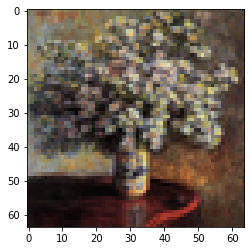

In [299]:
path = os.path.join(WikiArt_DIR, 'flower.txt')
img_list = load_img_list(path)
temp_path = os.path.join(WikiArt_DIR, "flower-painting", img_list[2])
img = get_image2(temp_path)
show_image((img+1)/2)

(78, 64, 3)


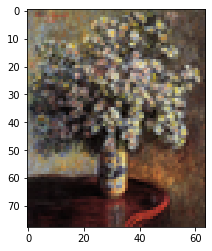

In [271]:
img = get_image(temp_path)
print(img.shape)
show_image((img+1)/2)

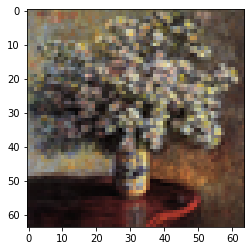

In [302]:
img = Image.open(temp_path)
img = img.resize((64, 64), resample=Image.ANTIALIAS)
#img = np.asarray(img).astype("float32")
#img = (img - 127.5) / 127.5
#show_image((img+1)/2)
show_image(img)
img.save("temp.jpg","JPEG", quality=100)

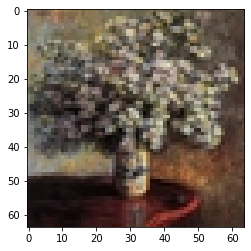

In [301]:
img = Image.open("temp.jpg")
show_image(img)

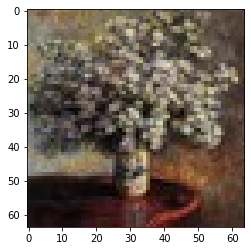

In [295]:
img = Image.open("temp.jpg")
show_image(img)

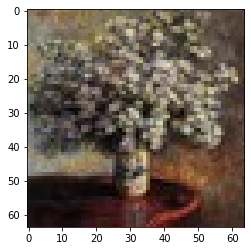

In [297]:
img = Image.open("temp.jpg")
show_image(img)

In [197]:
img_flower, label_flower = load_data_by_category(WikiArt_DIR, "flower-painting", "flower.txt")

Cannot read image 83: 0aa0e20cda65ecb535d3714d166af357c.jpg
Cannot read image 146: 13b904fb4feb1eac012827c2db8413c0c.jpg
Cannot read image 504: 4419073fd26aade2b435c3d16d2ad27fc.jpg
Cannot read image 590: 5356f3a18a88cd08c7a480189ba3f0e8c.jpg
Cannot read image 766: 6bd6265e2d5232650ad33cfeda57e551c.jpg
Cannot read image 984: 8bdd6e3f7641fb598dd7bb31ba974cb7c.jpg
Cannot read image 1270: b18270e526602be090a338728218f670c.jpg
Cannot read image 1328: ba9a58a33977b54f9b7ab74ea5e92085c.jpg
Cannot read image 1625: e787cf8526aa415871aaa7b62f1cb498c.jpg
Cannot read image 1720: f55e2bc8f0dfcc7df773cab5b6b28e53c.jpg


In [216]:
tf_flower = tf.data.Dataset.from_tensor_slices((img_flower, label_flower))

In [214]:
img_cityscape, y_cityscape = load_data_by_category(WikiArt_DIR, "cityscape", "cityscape.txt")
tf_cityscape = tf.data.Dataset.from_tensor_slices((img_cityscape, y_cityscape))

Cannot read image 154: 05742ec8d288ae1d1cef7c4215e1e92bc.jpg
Cannot read image 173: 065f33f5c6a87e47fbc8ee0d2c6132b4c.jpg
Cannot read image 179: 069221baf598540686da72a29309d0d4c.jpg
Cannot read image 264: 09f05cd3b483c1e40ef56134972d1206c.jpg
Cannot read image 356: 0d525fabce6c4284f2afdad6568e0a91c.jpg
Cannot read image 626: 17587feb0e5c5eb8a2f45b93feeeecd7c.jpg
Cannot read image 724: 1b08666008e1e073eac94a011211fd96c.jpg
Cannot read image 858: 20069629d2ca40cae609ac45234e988ec.jpg
Cannot read image 917: 22d7f2fd1a8b6a160f591a6225ecbfcdc.jpg
Cannot read image 970: 24f21fbba924d180fa7c0de6b5bdf82ec.jpg
Cannot read image 1045: 27b616dbe9af56e75fc6d4299e082197c.jpg
Cannot read image 1060: 28408b370b0a9f197d9157de73c93012c.jpg
Cannot read image 1122: 2b22889ac0f199922bb39fa446d882f6c.jpg
Cannot read image 1167: 2d3c8d9ff54422735810f7f6eec7200dc.jpg
Cannot read image 1456: 3800050daa5a55414f65ac6a6f6e979ac.jpg
Cannot read image 1500: 399d3b8929086e12ae7a29ede7f2edc4c.jpg
Cannot read image 

In [225]:
tf_data = tf_flower.concatenate(tf_cityscape)

In [248]:
len(tf_data)

8314

In [252]:
d = tf_data.batch(128)
for img, label in d:
    print(img.shape)

(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 3)
(128, 64, 64, 

In [260]:
from utils.py import load_data

new_data = load_data()

Cannot read image 83: 0aa0e20cda65ecb535d3714d166af357c.jpg
Cannot read image 146: 13b904fb4feb1eac012827c2db8413c0c.jpg
Cannot read image 504: 4419073fd26aade2b435c3d16d2ad27fc.jpg
Cannot read image 590: 5356f3a18a88cd08c7a480189ba3f0e8c.jpg
Cannot read image 766: 6bd6265e2d5232650ad33cfeda57e551c.jpg
Cannot read image 984: 8bdd6e3f7641fb598dd7bb31ba974cb7c.jpg
Cannot read image 1270: b18270e526602be090a338728218f670c.jpg


KeyboardInterrupt: 

In [320]:
data_dir = WikiArt_DIR
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(64, 64),
  batch_size=128)

normalization = tf.keras.layers.Rescaling(1./127.5, offset=-1)
train_ds = train_ds.map(lambda x, y: (normalization(x), y))

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 96013 files belonging to 14 classes.


In [319]:
first_image = x_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

-1.0 1.0


In [315]:
for i, label in train_ds.take(1):
    for j in range(10):
        print(label[j])

tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)


In [314]:
train_ds.class_names

['abstract',
 'animal-painting',
 'cityscape',
 'figurative',
 'flower-painting',
 'genre-painting',
 'landscape',
 'marina',
 'mythological-painting',
 'nude-painting-nu',
 'portrait',
 'religious-painting',
 'still-life',
 'symbolic-painting']